# 0. 학습목표

* 정상 시계열과 비정상 시계열을 구분할 줄 알아야한다.

* 정상성을 만족하지 못하는 시계열 자료는 다른 시기로 일반화 할 수 없기 때문에 정상 시계열로 전환 후에 모형을 적합해주어야 한다.

* ARIMA 모형과 분해 시계열 분석을 할 수 있다.

***

# 1. 정상성

* 우리는 강정상성과 약정상 중에서 약정상성에 대해서만 다룬다.

* 정의 : 시계열 자료의 확률적인 성질 (평균, 분산, 공분산, 분포)들이 시간의 흐름(시점)에 따라 불변한다.

* 평균이 일정하다 $\to$ **"뚜렷한 추세가 없다"** 라는 뜻과 동일하다.
    * 평균이 일정하지 않은 시계열은 **차분(difference)**을 통해 정상화할 수 있다.

* 분산이 일정하지 않을 경우 적절한 변수 **변환(Transform)**을 통해 정상화할 수 있다.

***

# 2. 시계열자료 분석 방법

## 가. 분석 방법

### A. 단기 예측 - 이동평균법

* 과거로부터 현재까지의 시계열 자료를 대상으로 일정기간별 이동평균을 계산하고, 이들의 추세를 파악하여 다음 기간을 예측하는 방법

 * 즉 표본평균처럼 관측값 전부에 동일한 가중치를 주는 대신에 최근 $m$ 개의 값들만을 이용하여 평균을 구하는 방법이다.

* 예측보다는 원 시계열 자료에서 계절변동과 불규칙 변동을 제거하여 추세변동과 순환변동만 가진 시계열로 변환하는 방법으로도 사용됨
    * 이론적인 설명은 저건데 모형 적합시에는 $\hat {Z}_t = \hat {T}_t + \hat {S}_t$ 로 예측값을 추정함
    * 가법모형은 계절성분의 진폭이 시계열 수준에 상관없이 일정할 때 사용 $\hat {Z}_t = \hat {T}_t + \hat {S}_t$
    * 승법모형은 계절성분의 진폭이 시계열 수준에 따라 달라질 때 사용 $\hat {Z}_t = \hat {T}_t \times \hat {S}_t$
    

* $n+1$ 시점의 데이터를 $m$개의 데이터를 가지고 예측하는 경우는 다음과 같다.

$$F_{n+1} = \frac {1}{m}(Z_n + Z_{n-1} + \dots Z_{n-m+1}) =\frac 1m \sum_{t}^{n}Z_t, \quad t=n-m+1$$

#### Practice with R

In [2]:
library(forecast) ## 예측값을 구하기 위한 패키지
library(TTR) ## 이동평균법을 이용하기 위한 패키지
library(lmtest) ## 더비-왓슨 검정 
library(tidyverse) ## 전처리 패키지

In [3]:
setwd("C:\\Users\\lee\\Desktop\\고급시계열 분석\\제5판_시계열분석_프로그램\\제5판 시계열분석 data")

* 데이터 호출 : 주기는 12로 월별 데이터임

In [4]:
z <- scan("food.txt")
t <- 1:length(z)
food <- ts(z, start=c(1981,1), frequency=12) 

* 시도표 확인 <br>
    `1`. 추세성분이 보인다. <br>
    `2`. 계절성분이 보인다. <br>
    `3`. 이분산성이 보인다. <br>

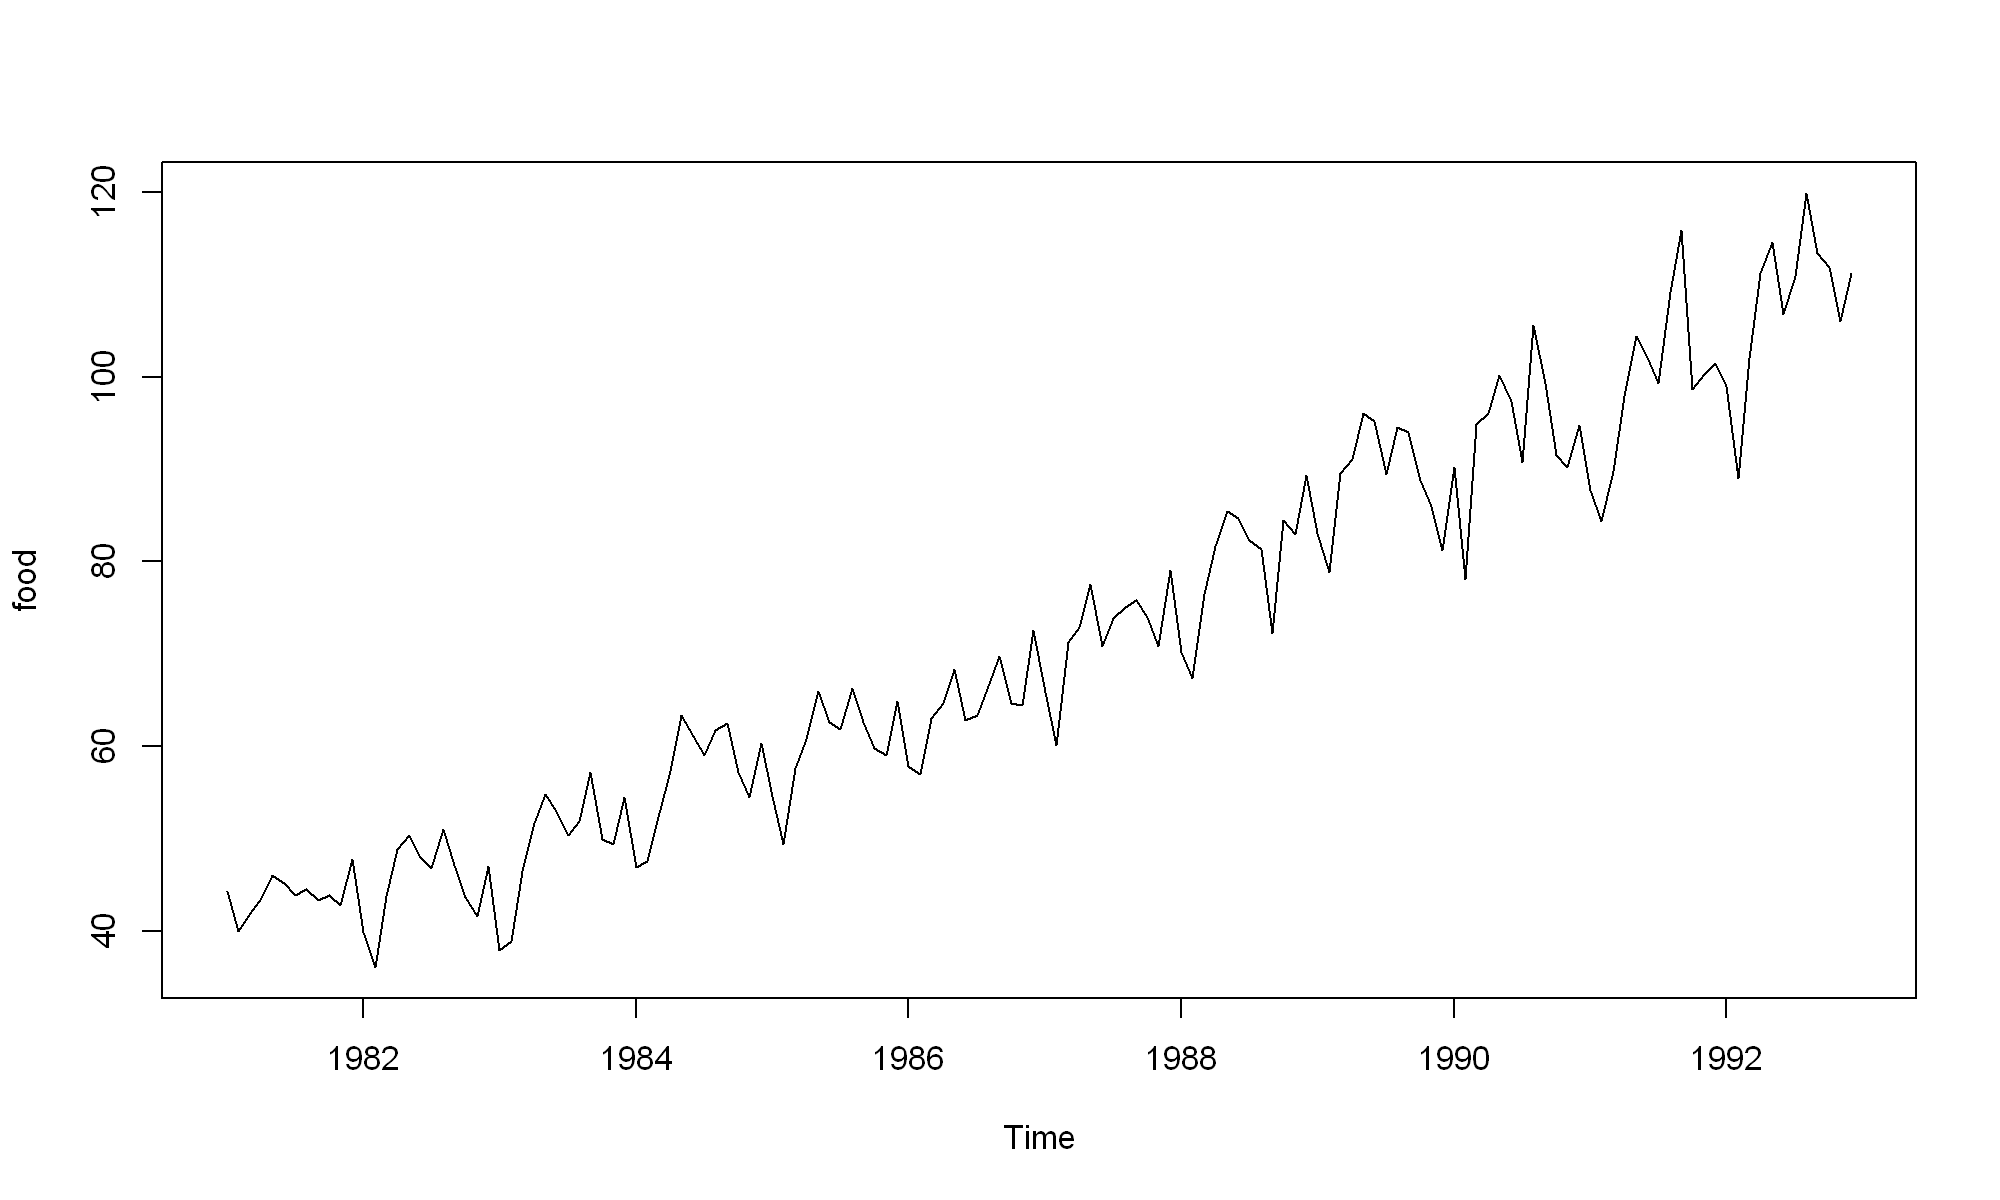

In [5]:
options(repr.plot.res=200,repr.plot.height=6,repr.plot.width=10)
plot.ts(food)

* 이분산성을 제거하기 위해 로그변환을 시도

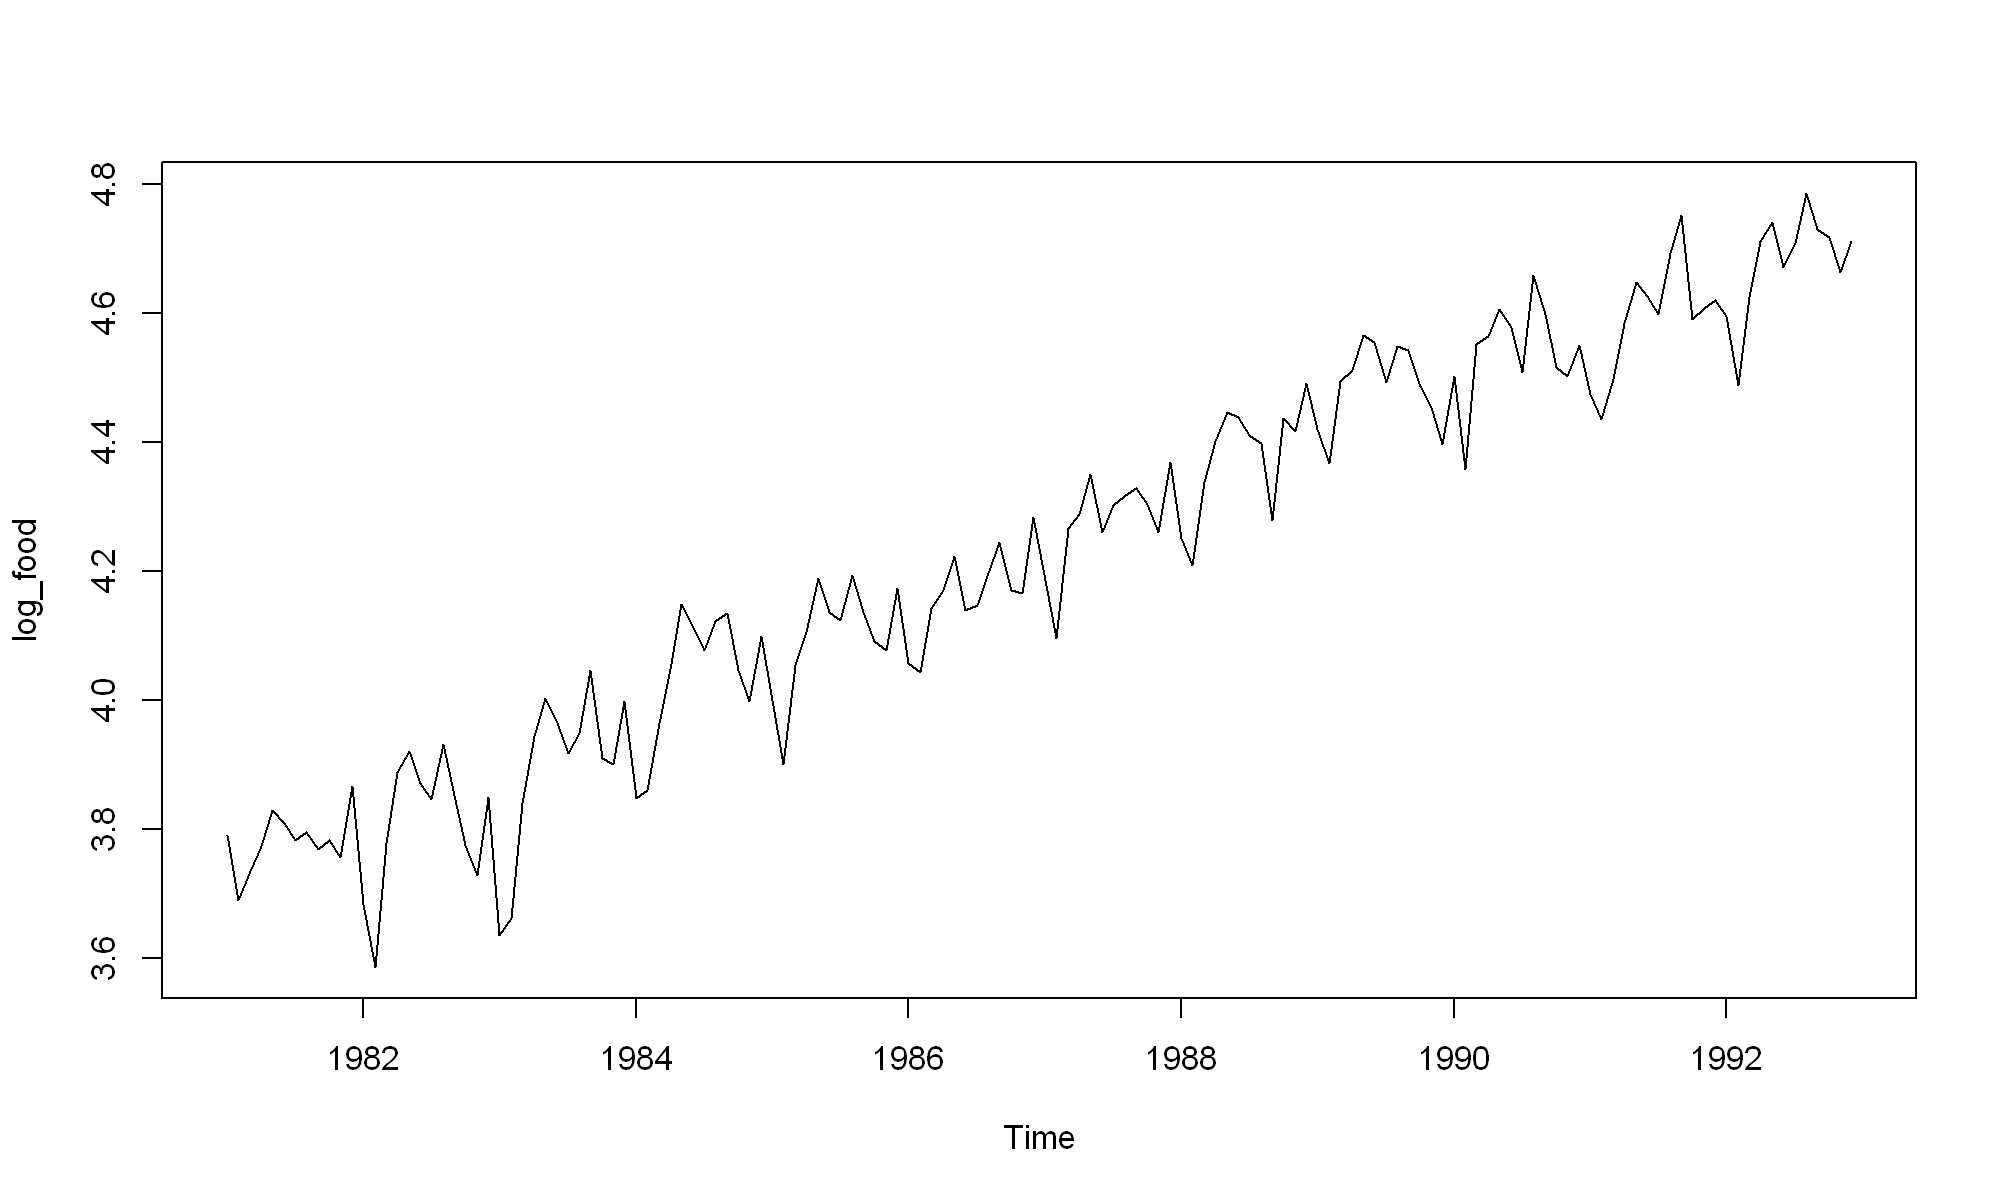

In [6]:
log_food <- log(food)
plot.ts(log_food)

#### stl

* **stl** function을 이용하여 모델 적합

In [7]:
stl_fit1  <- stl(log_food,s.window=12) ## s.window=12 : 계절성분의 주기가 12이다.

In [8]:
stl_fit1$time.series[1:10,]

seasonal,trend,remainder
-0.09035504,3.789108,0.09223150
-0.14793139,3.787232,0.04957932
-0.01989614,3.785355,-0.03017285
0.03829580,3.783478,-0.04901299
0.09453872,3.782254,-0.04815173
0.04378729,3.781031,-0.01593573
0.01632246,3.779807,-0.01421511
0.05405767,3.779134,-0.03770230
0.03906545,3.778461,-0.04937347
-0.01779740,3.777788,0.02192421


* 계절성분, 추세성분, 불규칙성분의 값들을 볼 수 있음.

* 추세성분으로 추정한 경우 $\hat {\beta}_0 + \hat{\beta}_1z_t= 0.07 + 3.7z_t$로 앞서 구한 데이터와 동일(이건 수업시간에 한거에 나와있음)

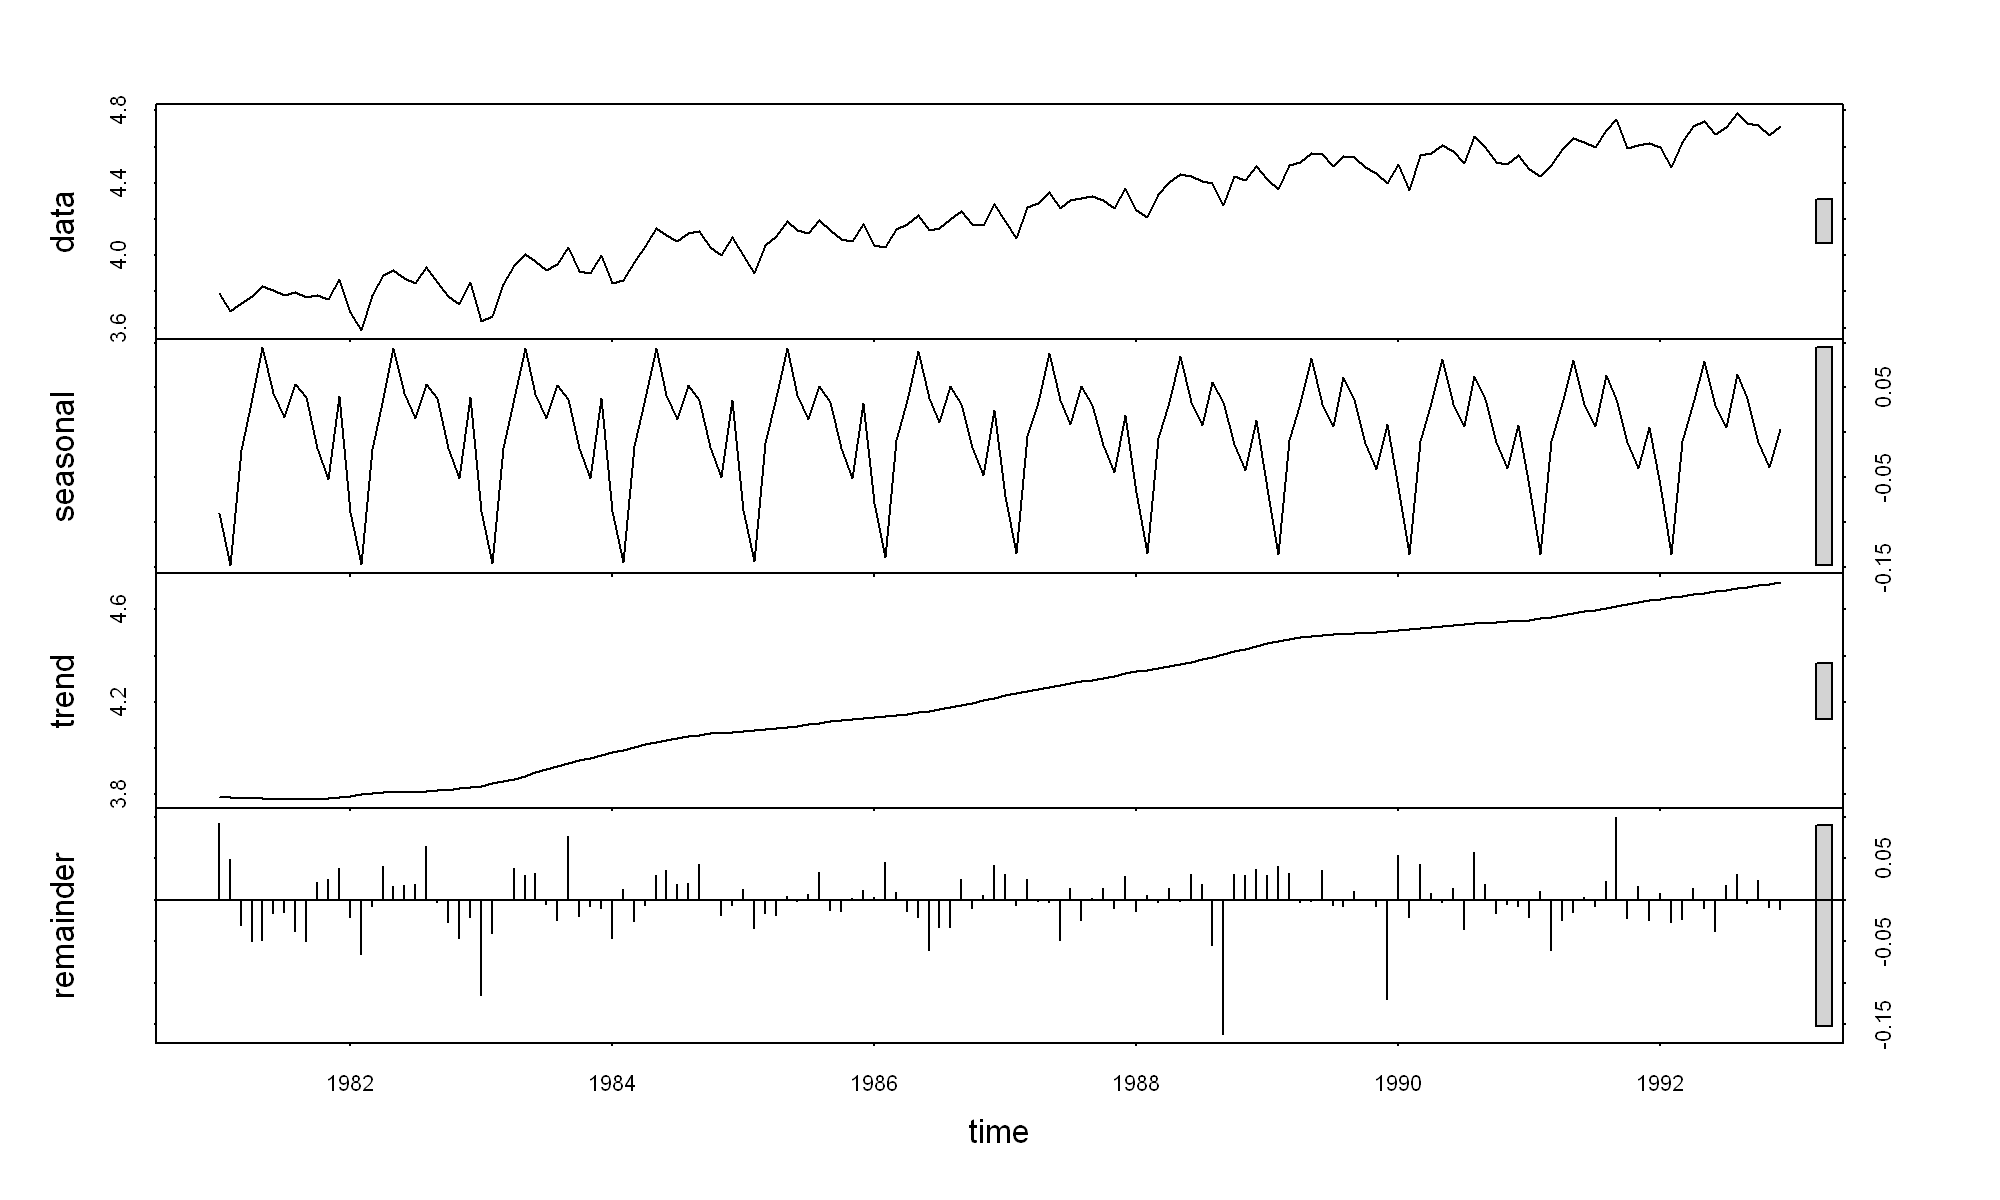

In [9]:
plot(stl_fit1)

* 추정값을 구해보자


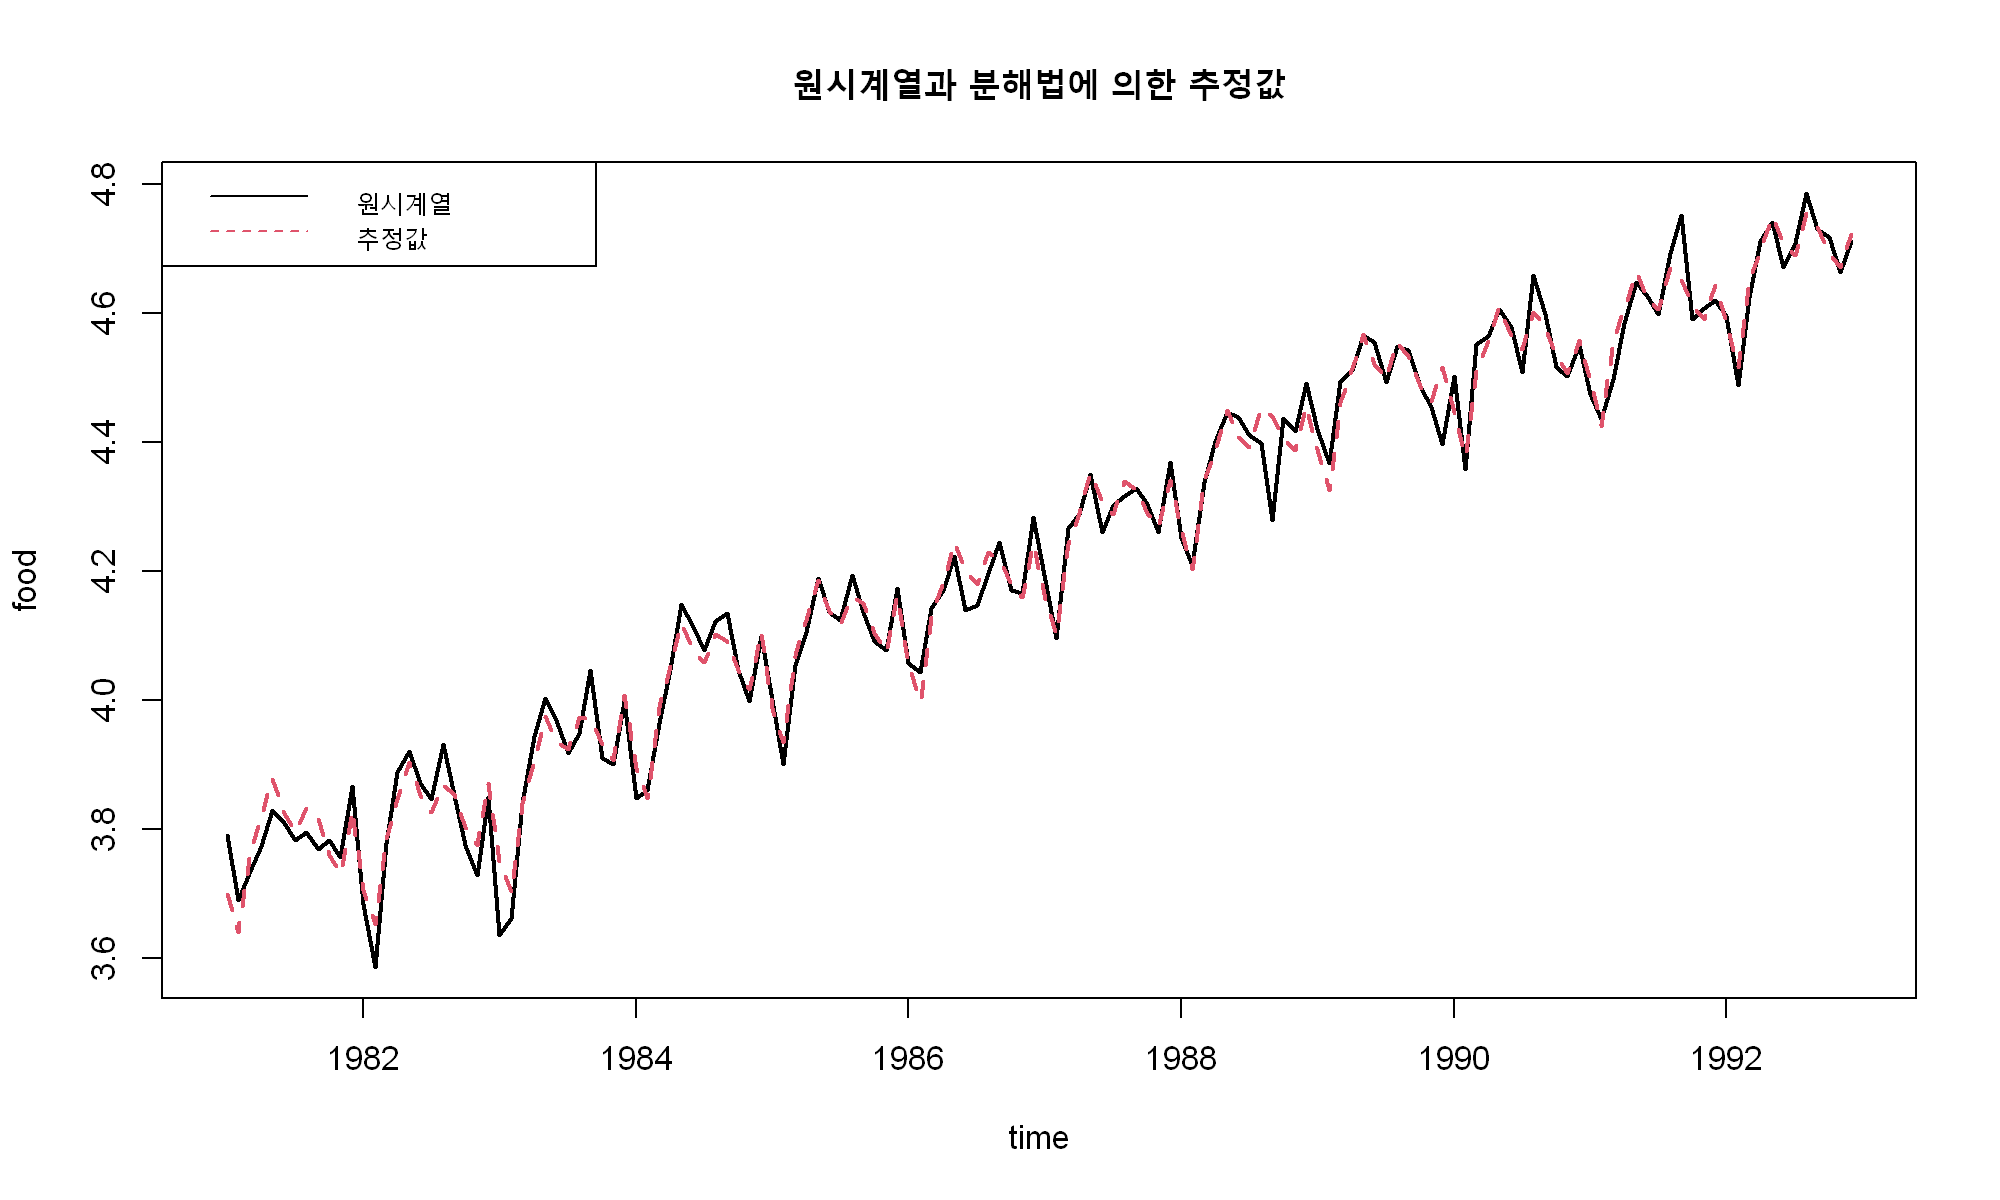

In [10]:
pred_stl <- stl_fit1$time.series[,1] + stl_fit1$time.series[,2] ## 추세성분 + 계절성분

ts.plot(log_food, pred_stl, col=1:2, lty=1:2, ylab="food", xlab="time",
        main="원시계열과 분해법에 의한 추정값",lwd=2)
legend("topleft", lty=1:2, col=1:2, c("원시계열", "추정값"))

In [11]:
irregular <- log_food-pred_stl
sum(irregular^2)/(length(log_food)-1) ## MSE 계산

[1] 0.001245258

#### decompose

* **decompose** function을 이용하여 모형 적합

In [69]:
dec_fit  <- decompose(log_food)

In [70]:
dec_fit$trend[1:10]

[1]       NA       NA       NA       NA       NA       NA 3.776909 3.768171
 [9] 3.765650 3.772193

In [71]:
dec_fit$seasonal[1:10]

[1] -0.07990209 -0.14604380 -0.01274493  0.04049678  0.09068184  0.03967867
 [7]  0.01048177  0.05876191  0.04134155 -0.01793742

In [72]:
dec_fit$random[1:10] ## 불규칙성분

[1]           NA           NA           NA           NA           NA
 [6]           NA -0.005476607 -0.031444194 -0.038838544  0.027659131

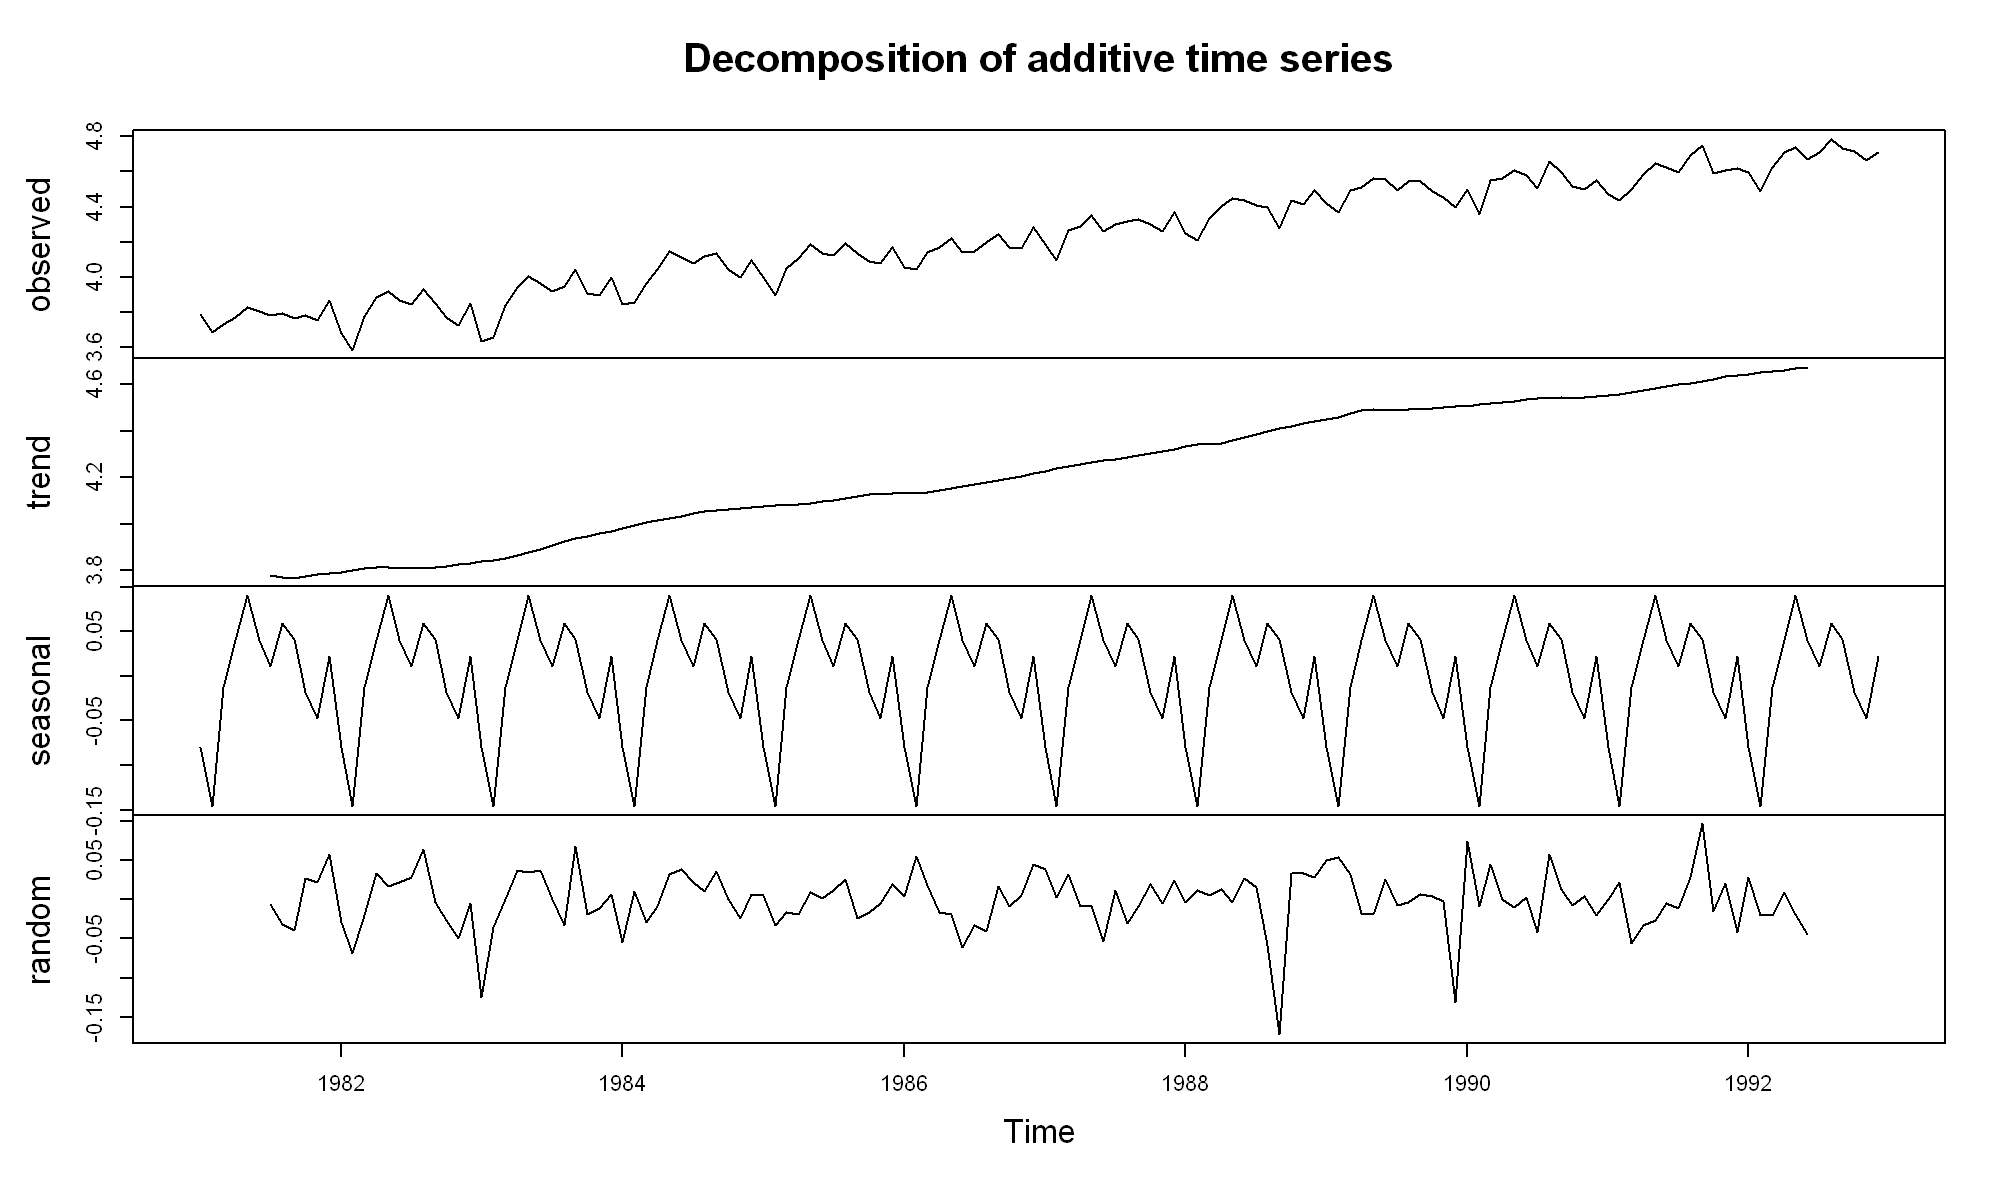

In [73]:
plot(dec_fit)

* 추정치 구하기

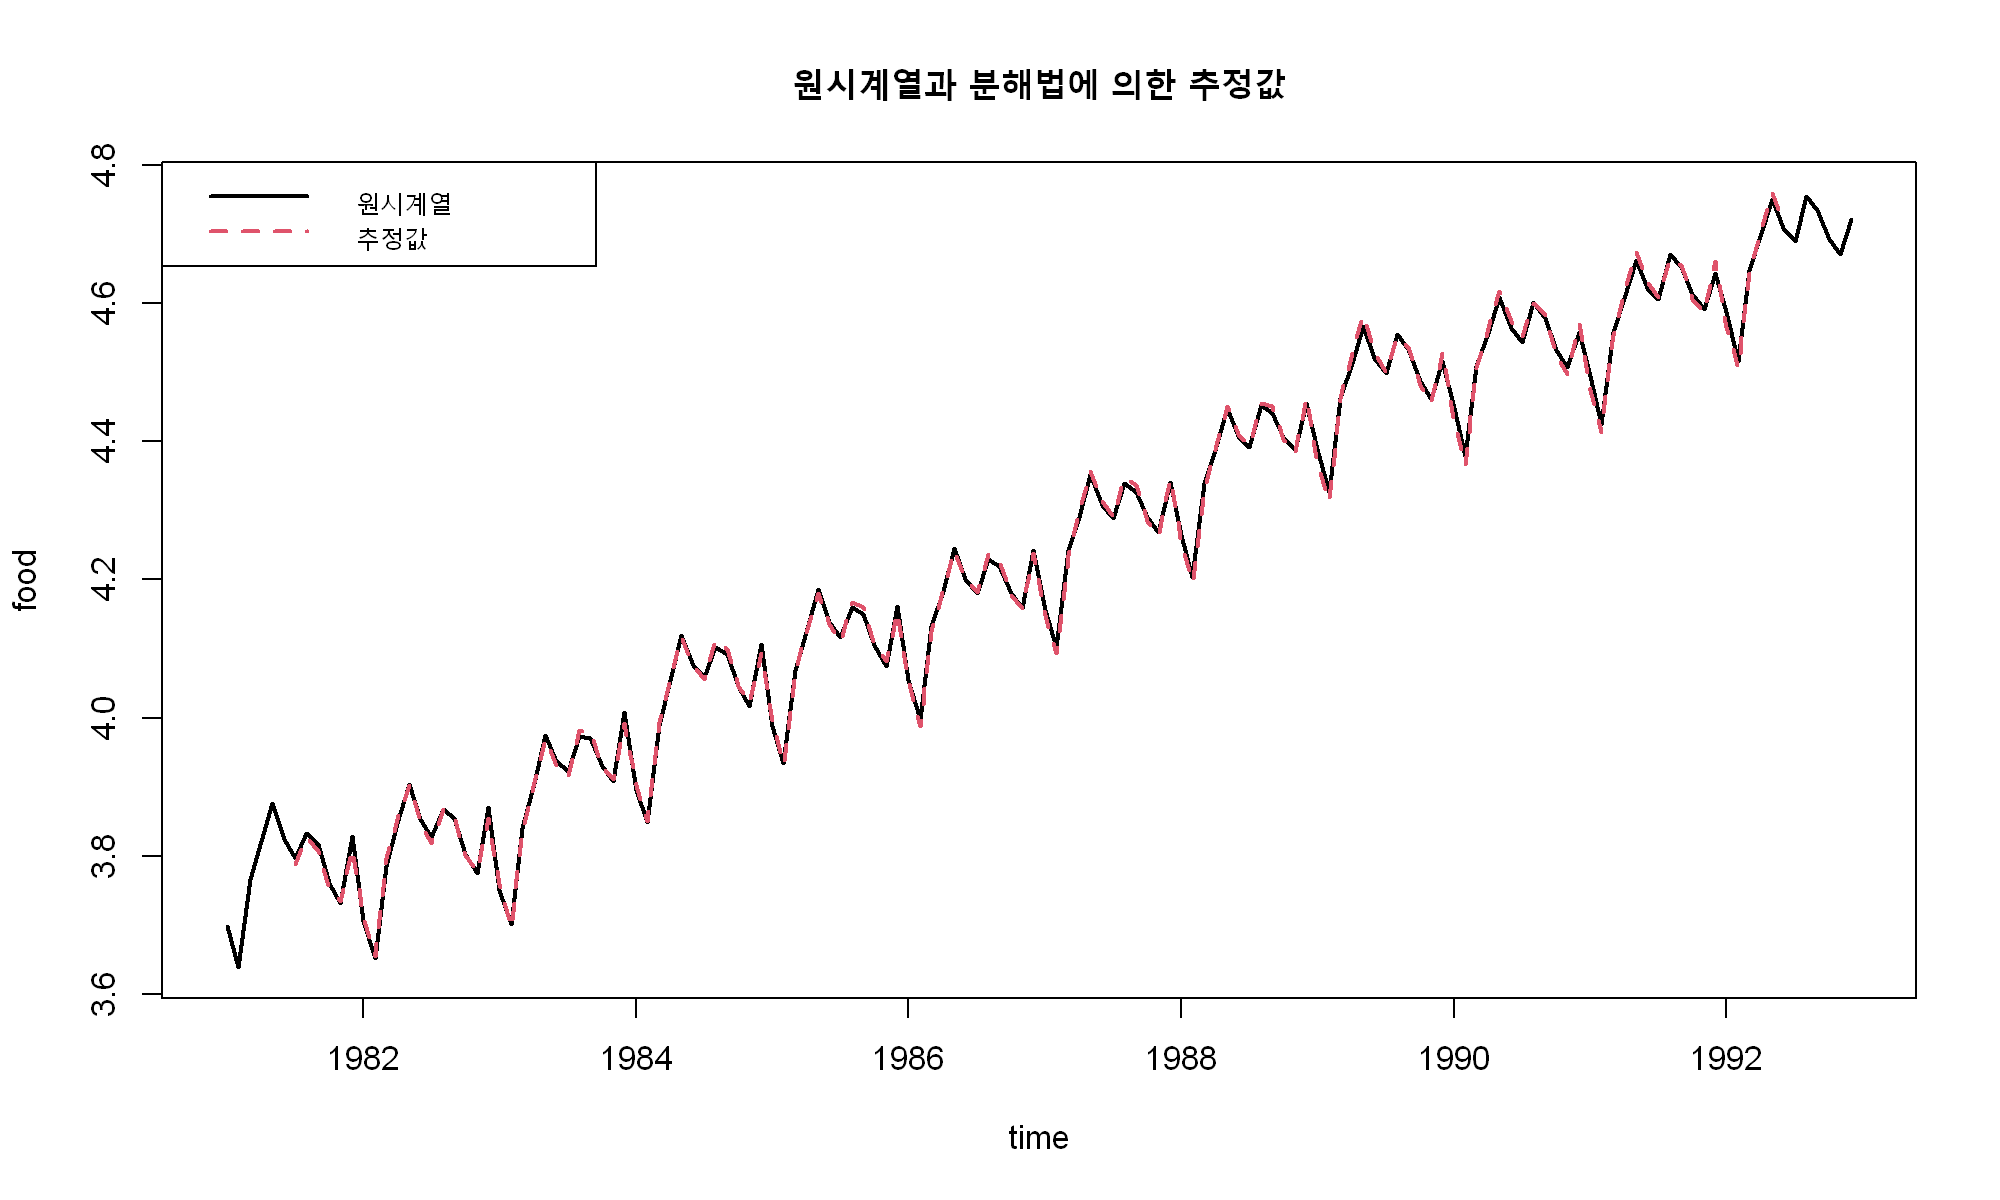

In [79]:
pred_dec <-dec_fit$trend+dec_fit$seasonal

ts.plot(pred_stl, pred_dec, col=1:2, lty=1:2, ylab="food", xlab="time",
        main="원시계열과 분해법에 의한 추정값",lwd=2)
legend("topleft", lty=1:2, col=1:2, c("원시계열", "추정값"),lwd=2)

* stl vs decompose

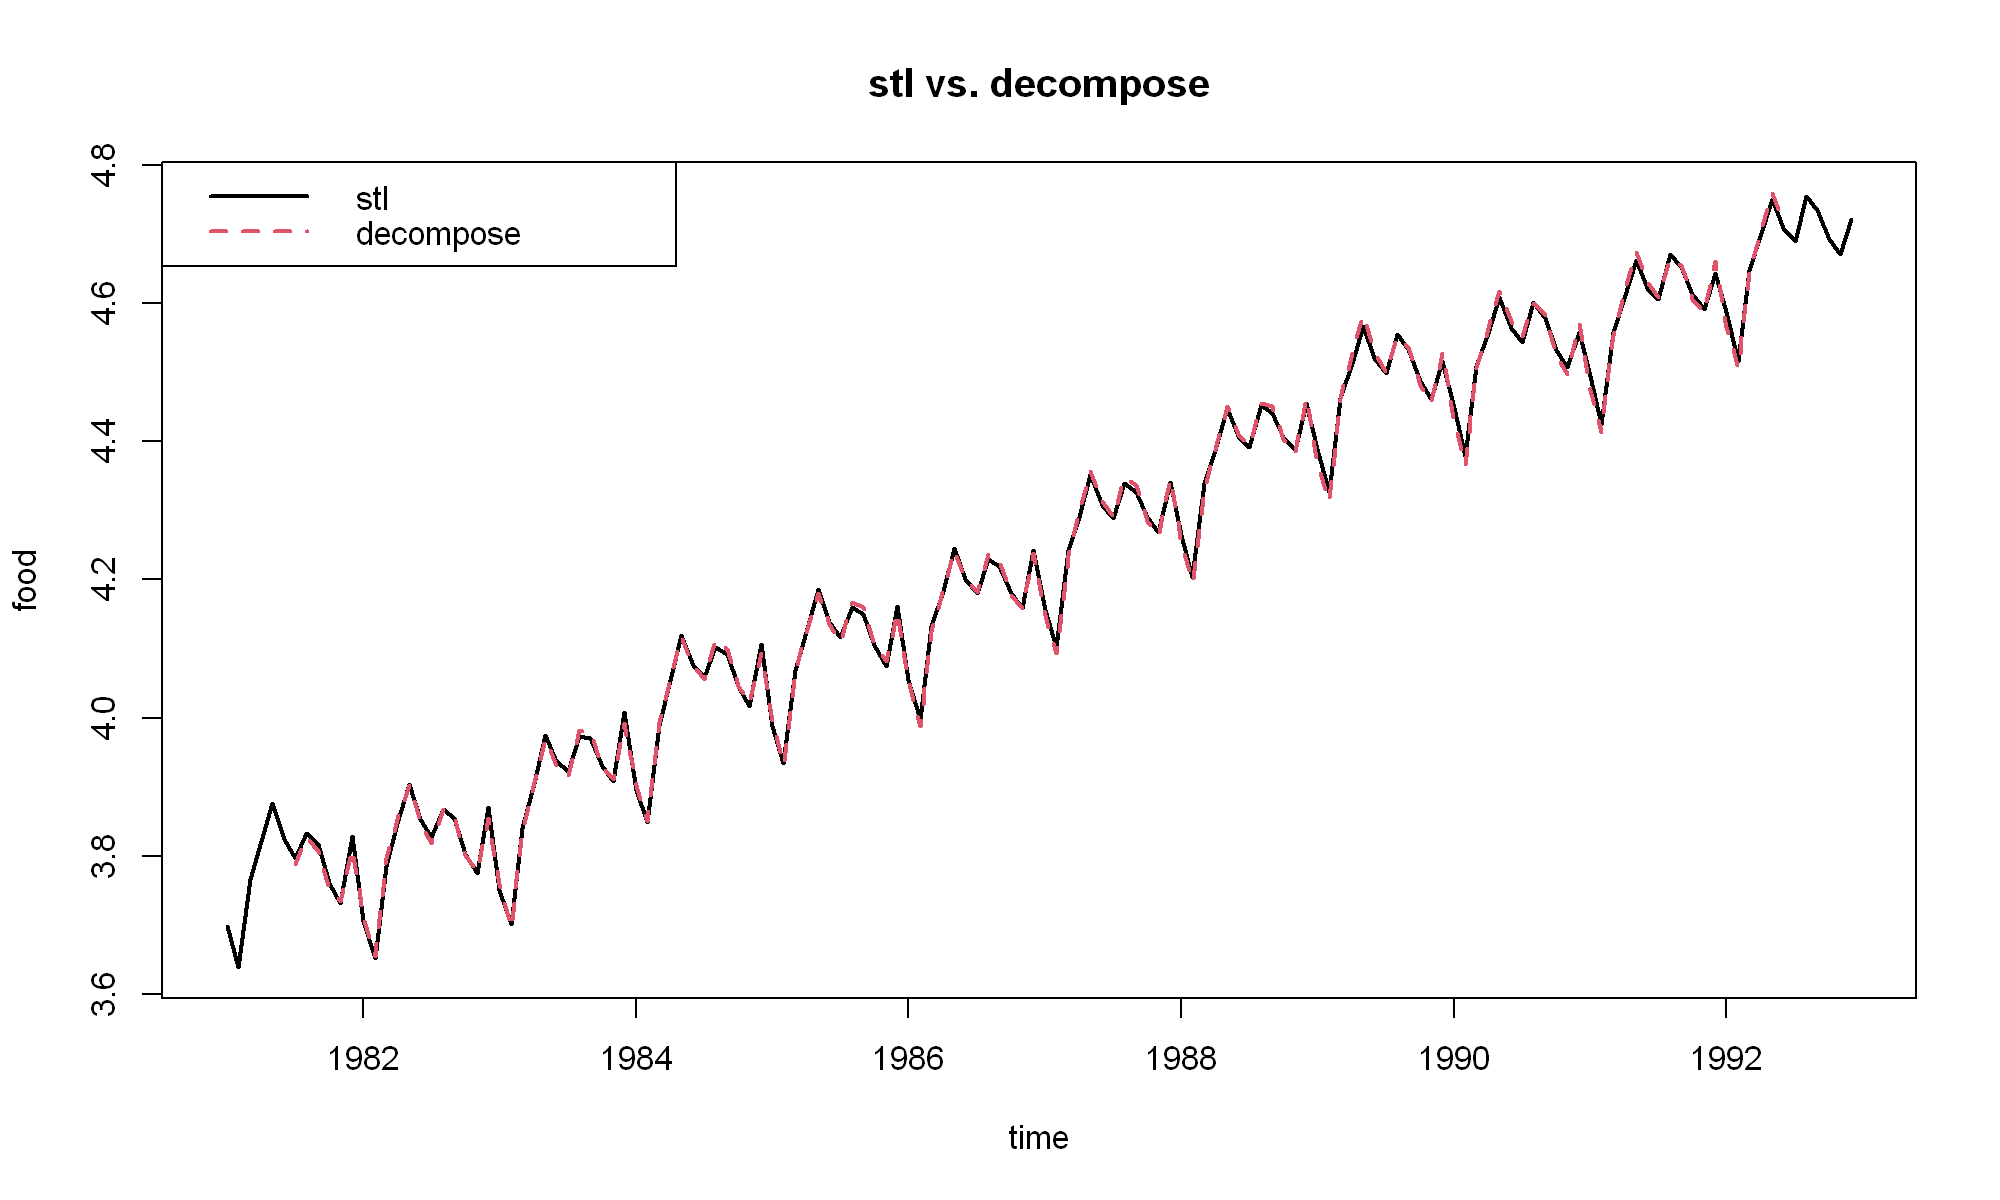

In [83]:
ts.plot(pred_stl, pred_dec, col=1:2, lty=1:2, ylab="food", xlab="time",
        main="stl vs. decompose",lwd=2)
legend("topleft", lty=1:2, col=1:2, c("stl", "decompose"),lwd=2)

* stl과 달리 decompose는 승법모형을 지원해준다.

In [84]:
dec_fit2 <- decompose(food, type = "multiplicative")
dec_fit2$trend[1:10]

[1]       NA       NA       NA       NA       NA       NA 43.72917 43.37917
 [9] 43.29167 43.58750

In [85]:
dec_fit2$seasonal[1:10]

[1] 0.9219246 0.8621213 0.9844960 1.0380042 1.0916505 1.0378593 1.0080029
 [8] 1.0591710 1.0427540 0.9807592

In [86]:
dec_fit2$random[1:10]

[1]        NA        NA        NA        NA        NA        NA 0.9959362
 [8] 0.9685292 0.9591835 1.0269284

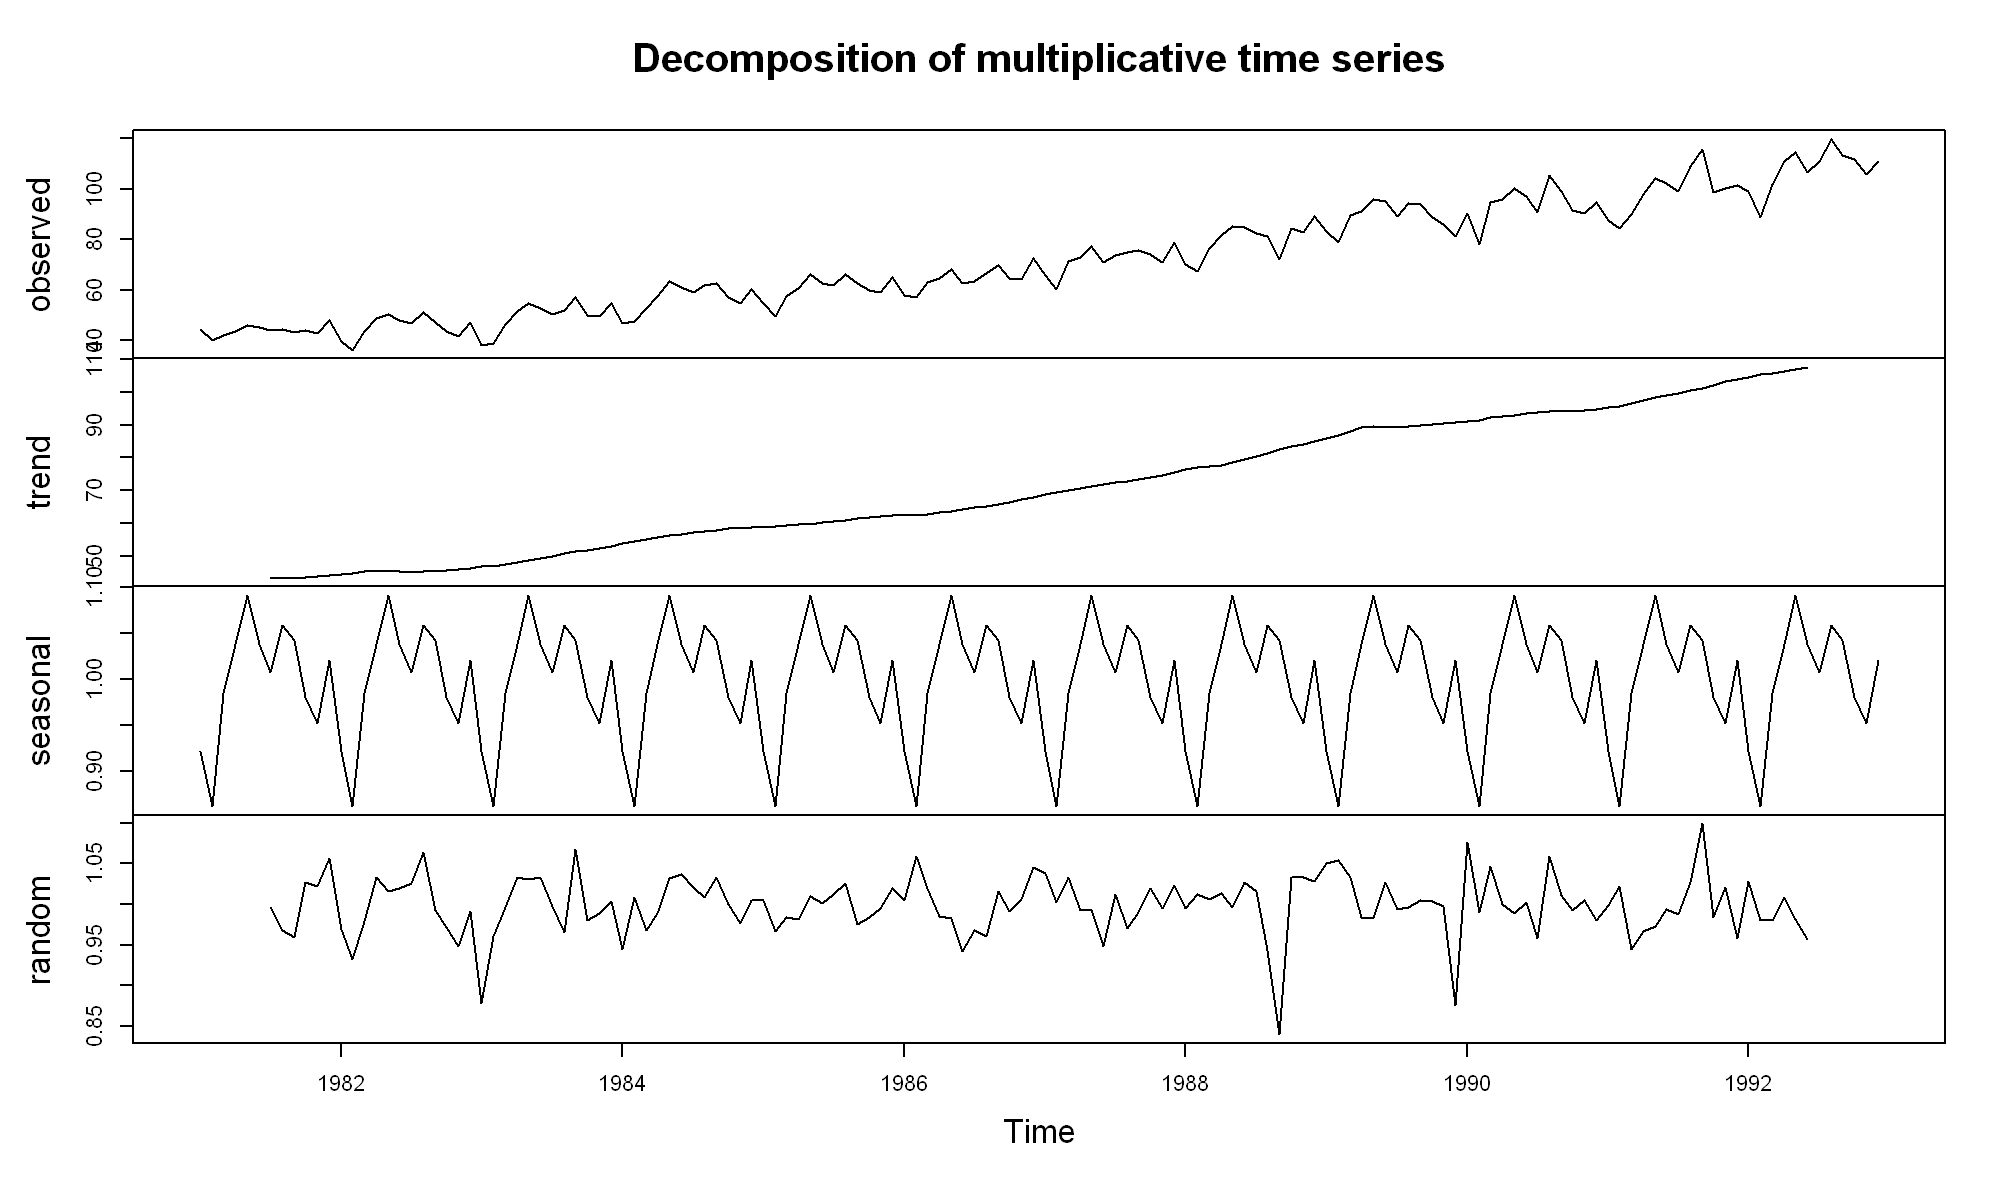

In [87]:
plot(dec_fit2)

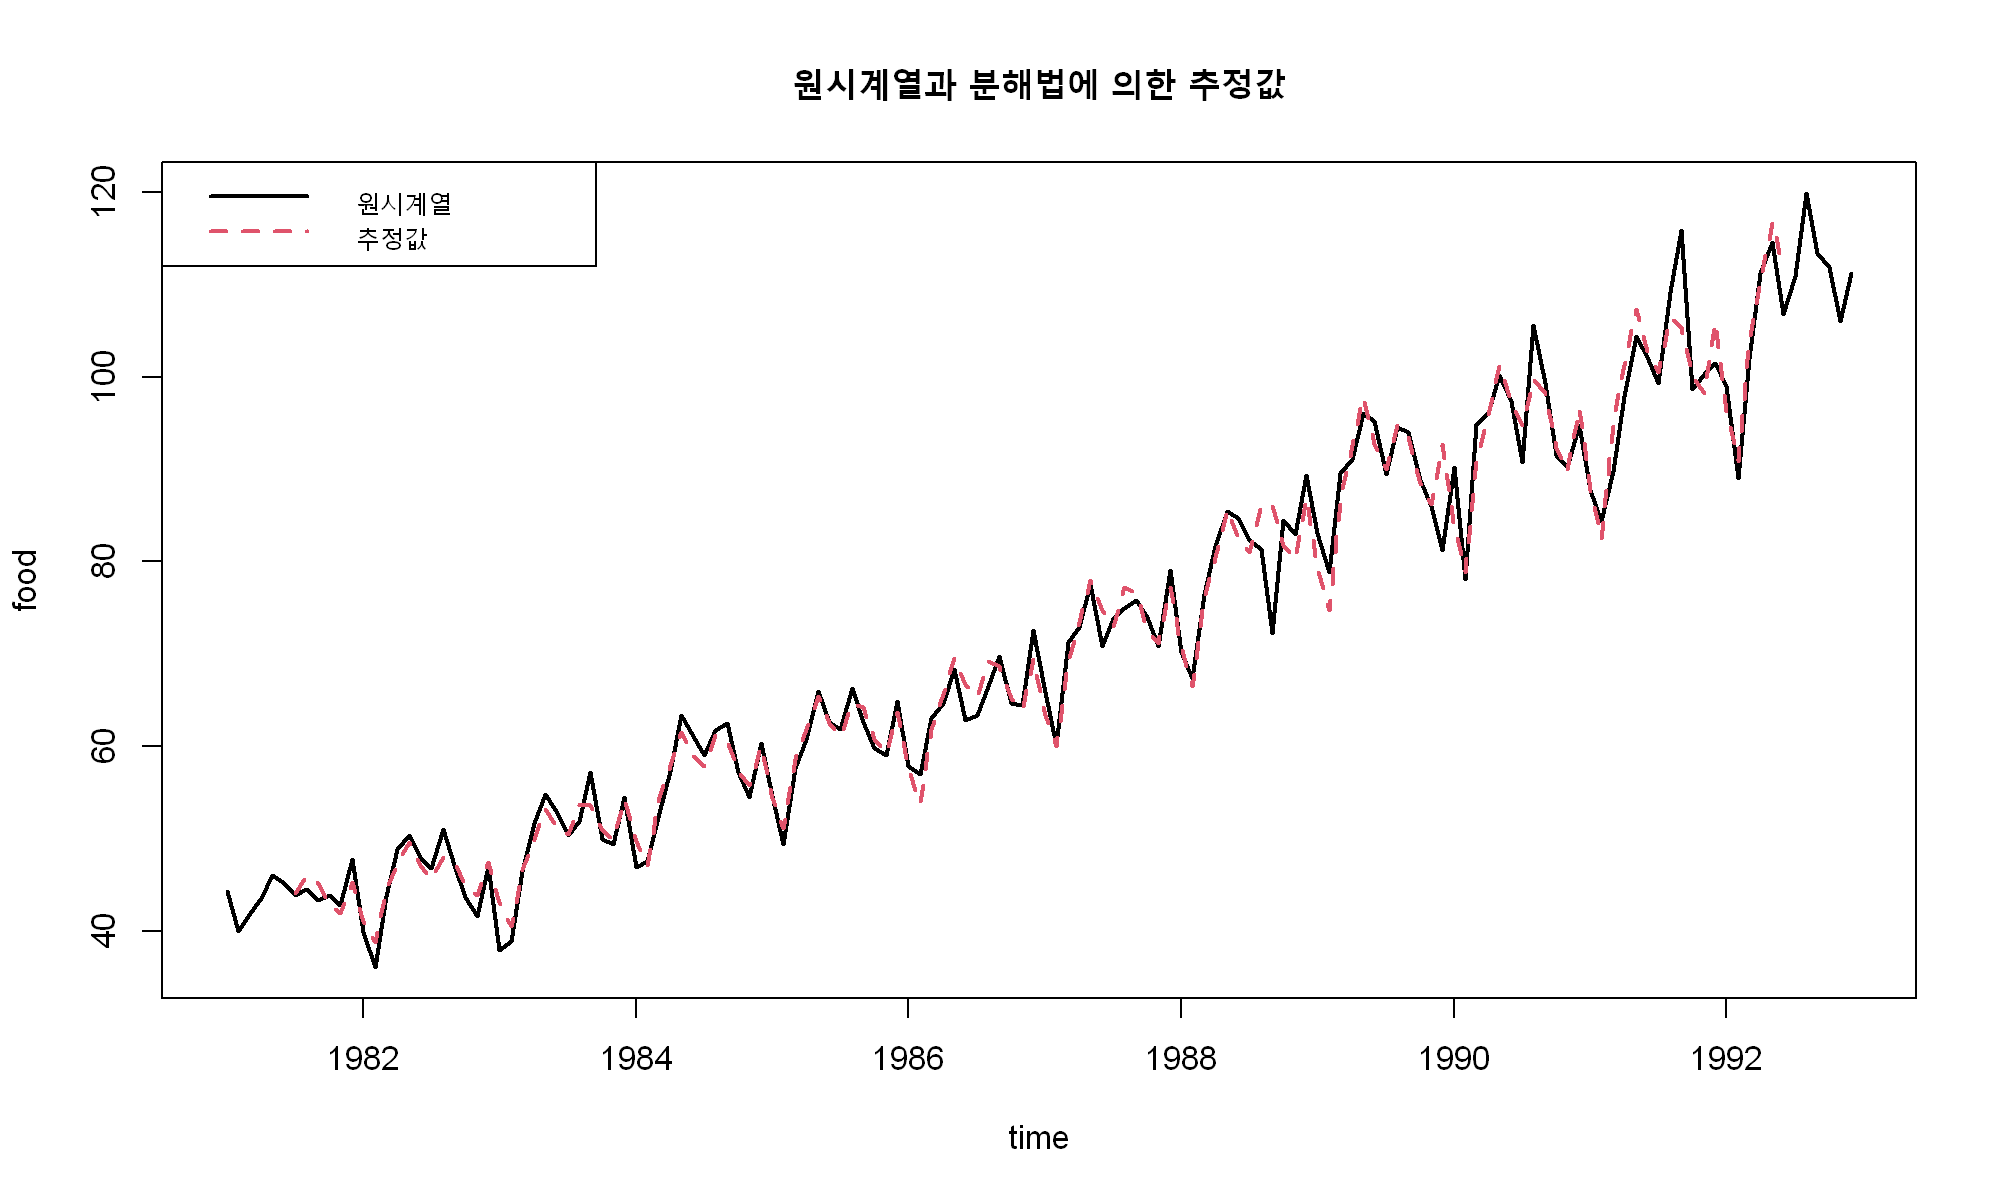

In [89]:
pred_dec2 <-dec_fit2$trend*dec_fit2$seasonal

ts.plot(food, pred_dec2, col=1:2, lty=1:2, ylab="food", xlab="time",
        main="원시계열과 분해법에 의한 추정값",lwd=2)
legend("topleft", lty=1:2, col=1:2, c("원시계열", "추정값"),lwd=2)

* 가법모형 vs 승법모형

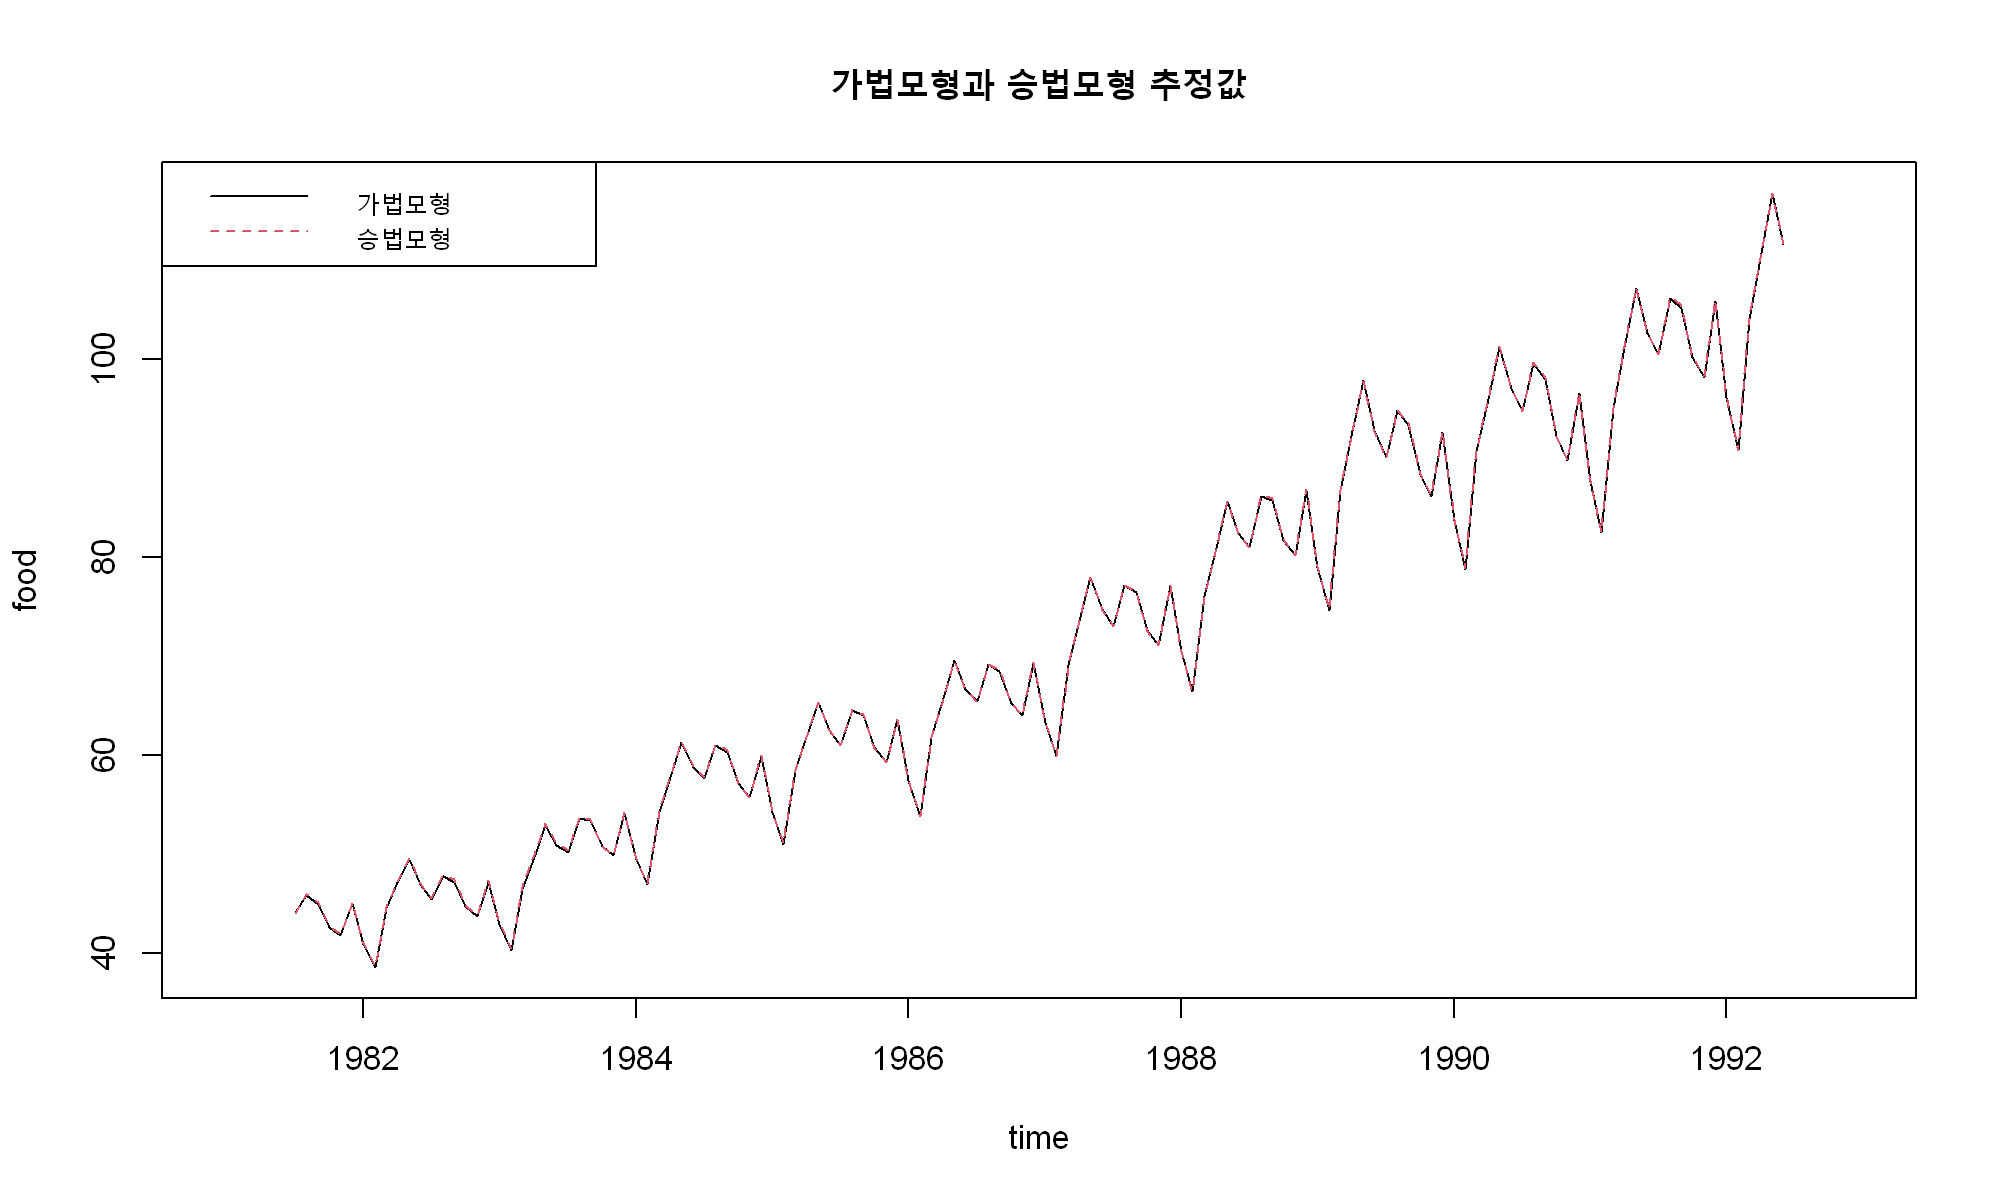

In [90]:
ts.plot(exp(pred_dec), pred_dec2, col=1:2, lty=1:2, ylab="food", xlab="time",
        main="가법모형과 승법모형 추정값")
legend("topleft", lty=1:2, col=1:2, c("가법모형", "승법모형"))

* 승법모형과 가법모형 비교 결과 거의 동일한 모형임을 확인할 수 있다.

***

### B. 단기 예측 - 지수평활법

* 이동평균법이 $m$개의 데이터의 평균을 이용하여(=동일한 가중치를 부여) $n+1$ 시점의 예측값을 구했다면

* 지수평활법은 최근 시점에 관측치에 더 많은 가중치를 부여하여 미래를 예측하는 방법이다.

$F_{n+1} = \alpha Z_n + \alpha(1-\alpha) Z_{n-1} + \dots \alpha(1-\alpha)^nZ_0 \dots $

* $\alpha=$ 지수평활계수로 작을수록 과거시점에 가중치를 더 많이 주고, 클 수록 현시점에 가중치를 많이 준다.
    * $\alpha$는 예측오차를 비교하여 예측오차가 가장 작은값을 선택하는 것이 바람직함
    * 불규칙변동이 큰 시계열의 경우 작은 값을, 작을 경우 큰 값을 적용

* 또한 이동평균법과 달리 모든 $m$개가 아닌 전체 데이터를 고려하여 예측값을 산출한다.

* 추세성분과 계절성분이 없을 경우 $\to$ 단순지수평활법
* 추세성분이 있고 계절성분이 없는 경우 $\to$ 이중지수평활법
* 추세성분과 계절성이 모두 관측된 경우 $\to$ winters 계절지수 평활법

#### Practice with R

#### 단순지수 평활법

In [105]:
rain  <- scan("precip1.txt",skip=1)
rainseries <- ts(rain,start=c(1813))
rainseries ## 1년 주기 데이터

A Time Series:
  [1] 23.56 26.07 21.86 31.24 23.65 23.88 26.41 22.67 31.69 23.86 24.11 32.43
 [13] 23.26 22.57 23.00 27.88 25.32 25.08 27.76 19.82 24.78 20.12 24.34 27.42
 [25] 19.44 21.63 27.49 19.43 31.13 23.09 25.85 22.65 22.75 26.36 17.70 29.81
 [37] 22.93 19.22 20.63 35.34 25.89 18.65 23.06 22.21 22.18 18.77 28.21 32.24
 [49] 22.27 27.57 21.59 16.93 29.48 31.60 26.25 23.40 25.42 21.32 25.02 33.86
 [61] 22.67 18.82 28.44 26.16 28.17 34.08 33.82 30.28 27.92 27.14 24.40 20.35
 [73] 26.64 27.01 19.21 27.74 23.85 21.23 28.15 22.61 19.80 27.94 21.47 23.52
 [85] 22.86 17.69 22.54 23.28 22.17 20.84 38.10 20.65 22.97 24.26 23.01 23.67
 [97] 26.75 25.36 24.79 27.88

* 시도료를 살펴본결과 추세와 계절성분이 관측되지 않아 단순지수평활법을 사용하겠음

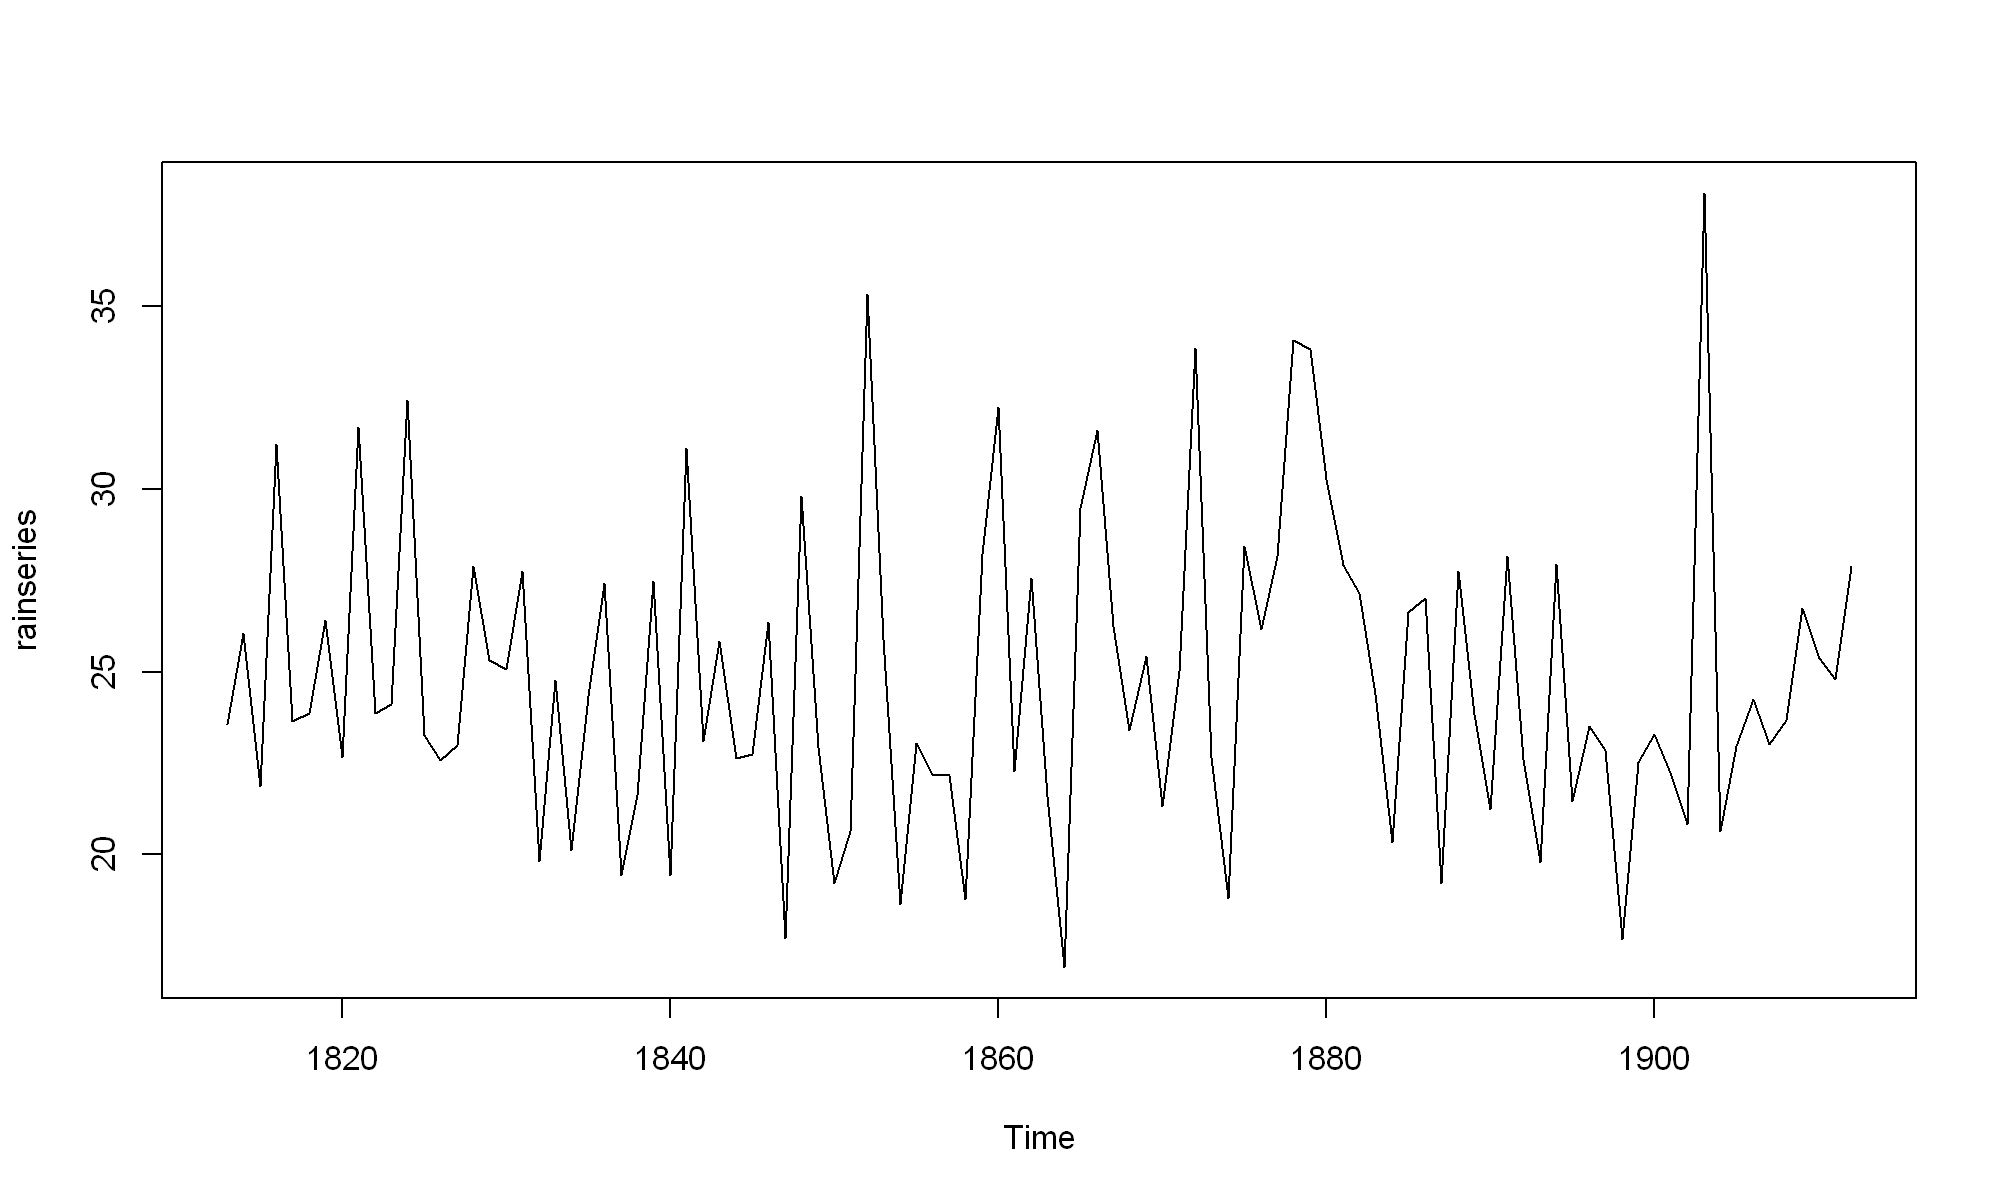

In [106]:
plot.ts(rainseries)

* [단순지수평활법]  HoltWinters

In [111]:
rainforecasts = HoltWinters(rainseries, beta=FALSE, gamma=FALSE) 
rainforecasts ## alpha=단순지수 평활법, beta = 추세성분 가중치 , gamma = 계절성분 가중치
## alpha 값을 지정하지 않으면 최적의 alpha를 찾아줌

Holt-Winters exponential smoothing without trend and without seasonal component.

Call:
HoltWinters(x = rainseries, beta = FALSE, gamma = FALSE)

Smoothing parameters:
 alpha: 0.02412151
 beta : FALSE
 gamma: FALSE

Coefficients:
      [,1]
a 24.67819

* $\alpha = 0.024\dots$ 로 산출
* $\alpha$가 작다는 것은 과거값의 가중치를 더 많이 주는 것이므로 **smoothing** 효과가 더욱 커진다.

In [113]:
head(rainforecasts$fitted)

,xhat,level
1814,23.56000,23.56000
1815,23.62054,23.62054
1816,23.57808,23.57808
1817,23.76290,23.76290
1818,23.76017,23.76017
1819,23.76306,23.76306


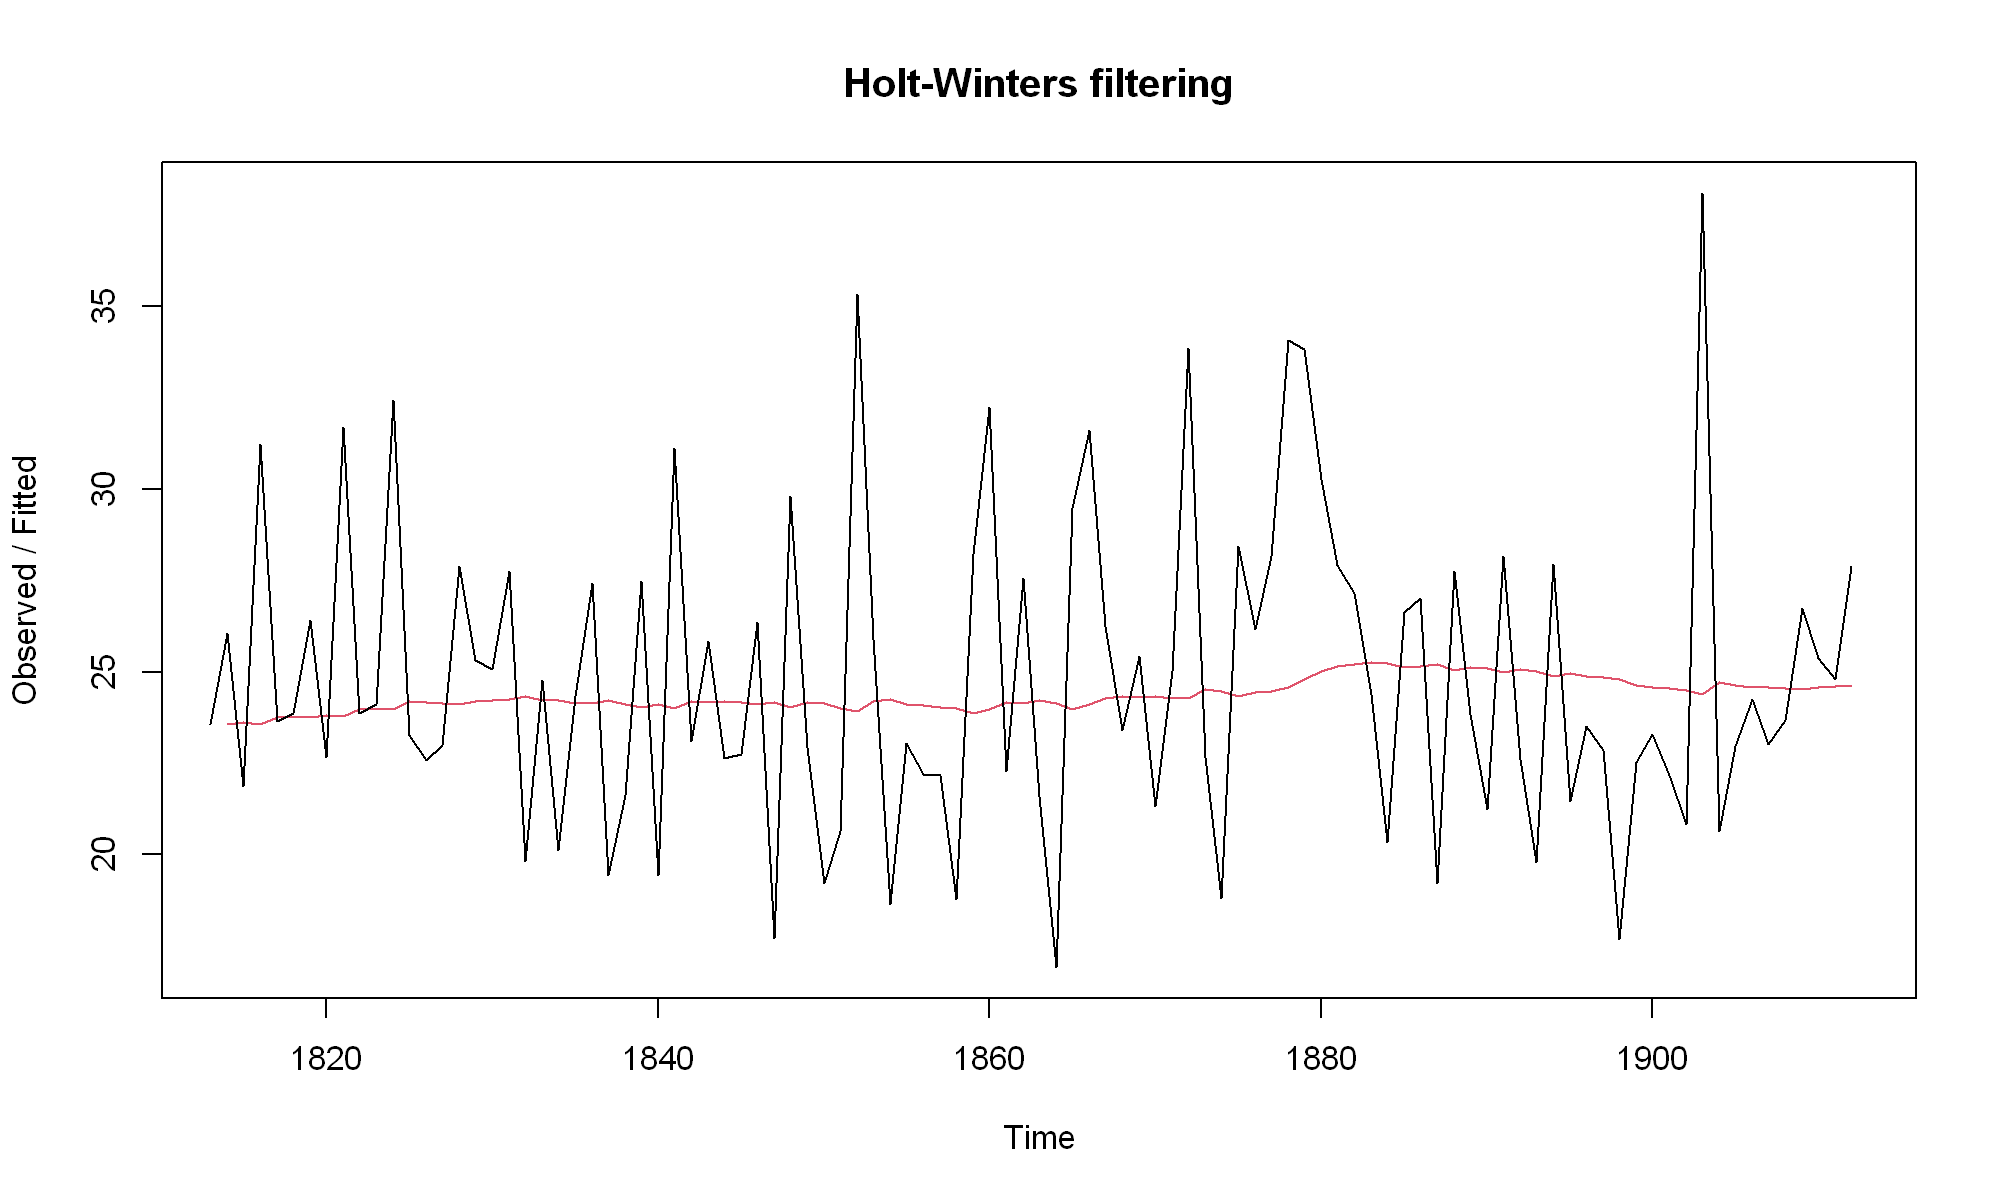

In [116]:
plot(rainforecasts) ## 빨간색은 smoothing 효과가 반영된 것이다.

* 오차제곱합 계산

In [117]:
rainforecasts$SSE

[1] 1828.855

* $\alpha$ 값을 변화해가며 비교

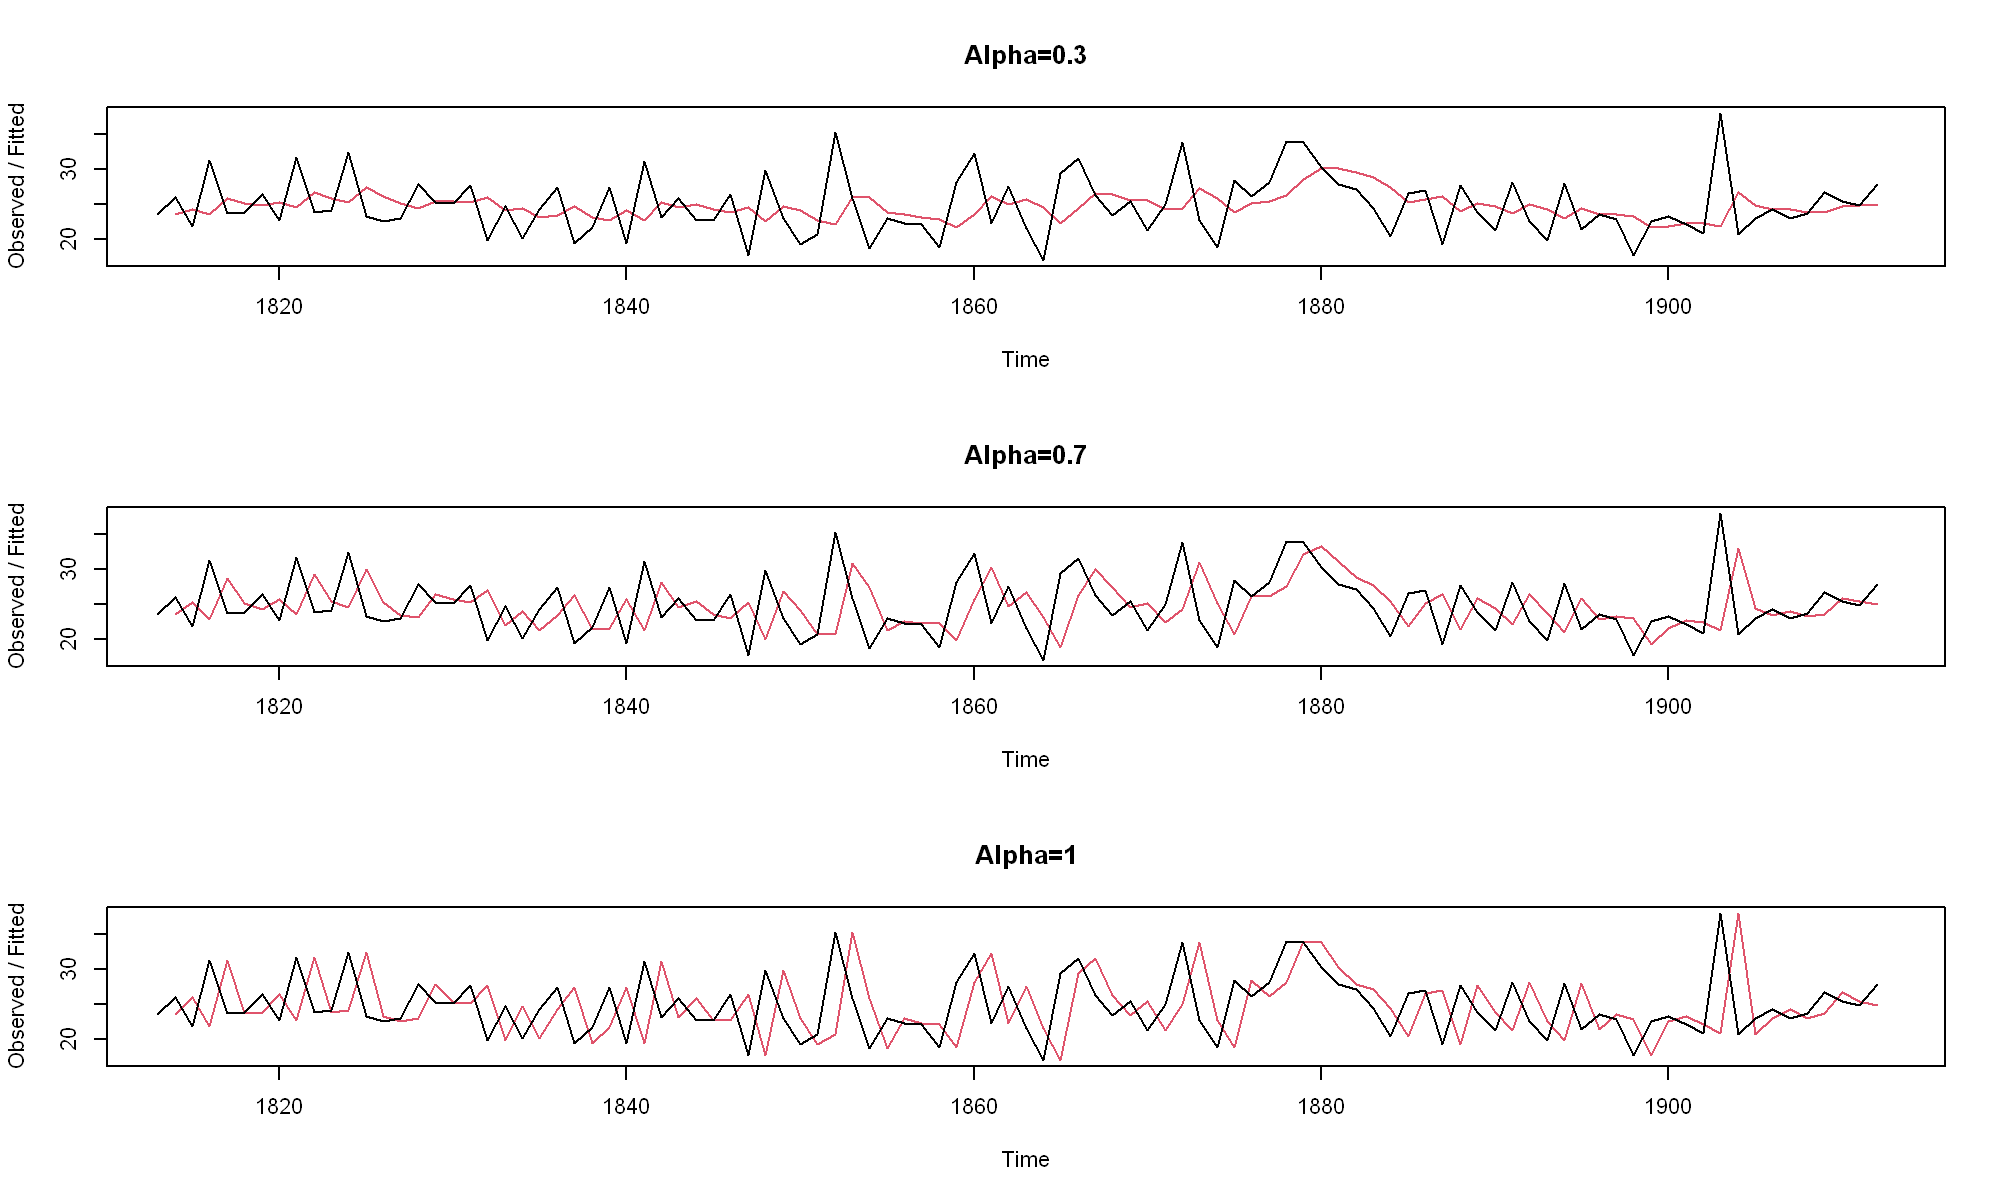

In [120]:
par(mfrow=c(3,1))
plot(HoltWinters(rainseries, alpha=0.3,
                 beta=FALSE, gamma=FALSE), main="Alpha=0.3")

plot(HoltWinters(rainseries, alpha=0.7,
                 beta=FALSE, gamma=FALSE), main="Alpha=0.7")

plot(HoltWinters(rainseries, alpha=1,
                 beta=FALSE, gamma=FALSE), main="Alpha=1") ## 1은 직전값만 보겠다는 뜻이다.

In [121]:
alpha1=HoltWinters(rainseries, alpha=1, beta=FALSE, gamma=FALSE)
alpha1$SSE
alpha07=HoltWinters(rainseries, alpha=0.7, beta=FALSE, gamma=FALSE)
alpha07$SSE
alpha03=HoltWinters(rainseries, alpha=0.3, beta=FALSE, gamma=FALSE)
alpha03$SSE

[1] 3738.178

[1] 2849.299

[1] 2101.56

* [단순지수평활] 초기값 변경 $\to$ 기존의 경우 관측값의 첫 번째 값을 사용

In [124]:
rainforecasts35 = HoltWinters(rainseries, beta=FALSE, gamma=FALSE, l.start=35)
rainforecasts35

Holt-Winters exponential smoothing without trend and without seasonal component.

Call:
HoltWinters(x = rainseries, beta = FALSE, gamma = FALSE, l.start = 35)

Smoothing parameters:
 alpha: 0.1955854
 beta : FALSE
 gamma: FALSE

Coefficients:
      [,1]
a 25.28555

* $\alpha$ 값이 앞에 초기값 설정 전 보다 작아짐

* 스무딩 효과도 줄어들었다.

In [130]:
rainforecasts35$SSE

[1] 2209.422

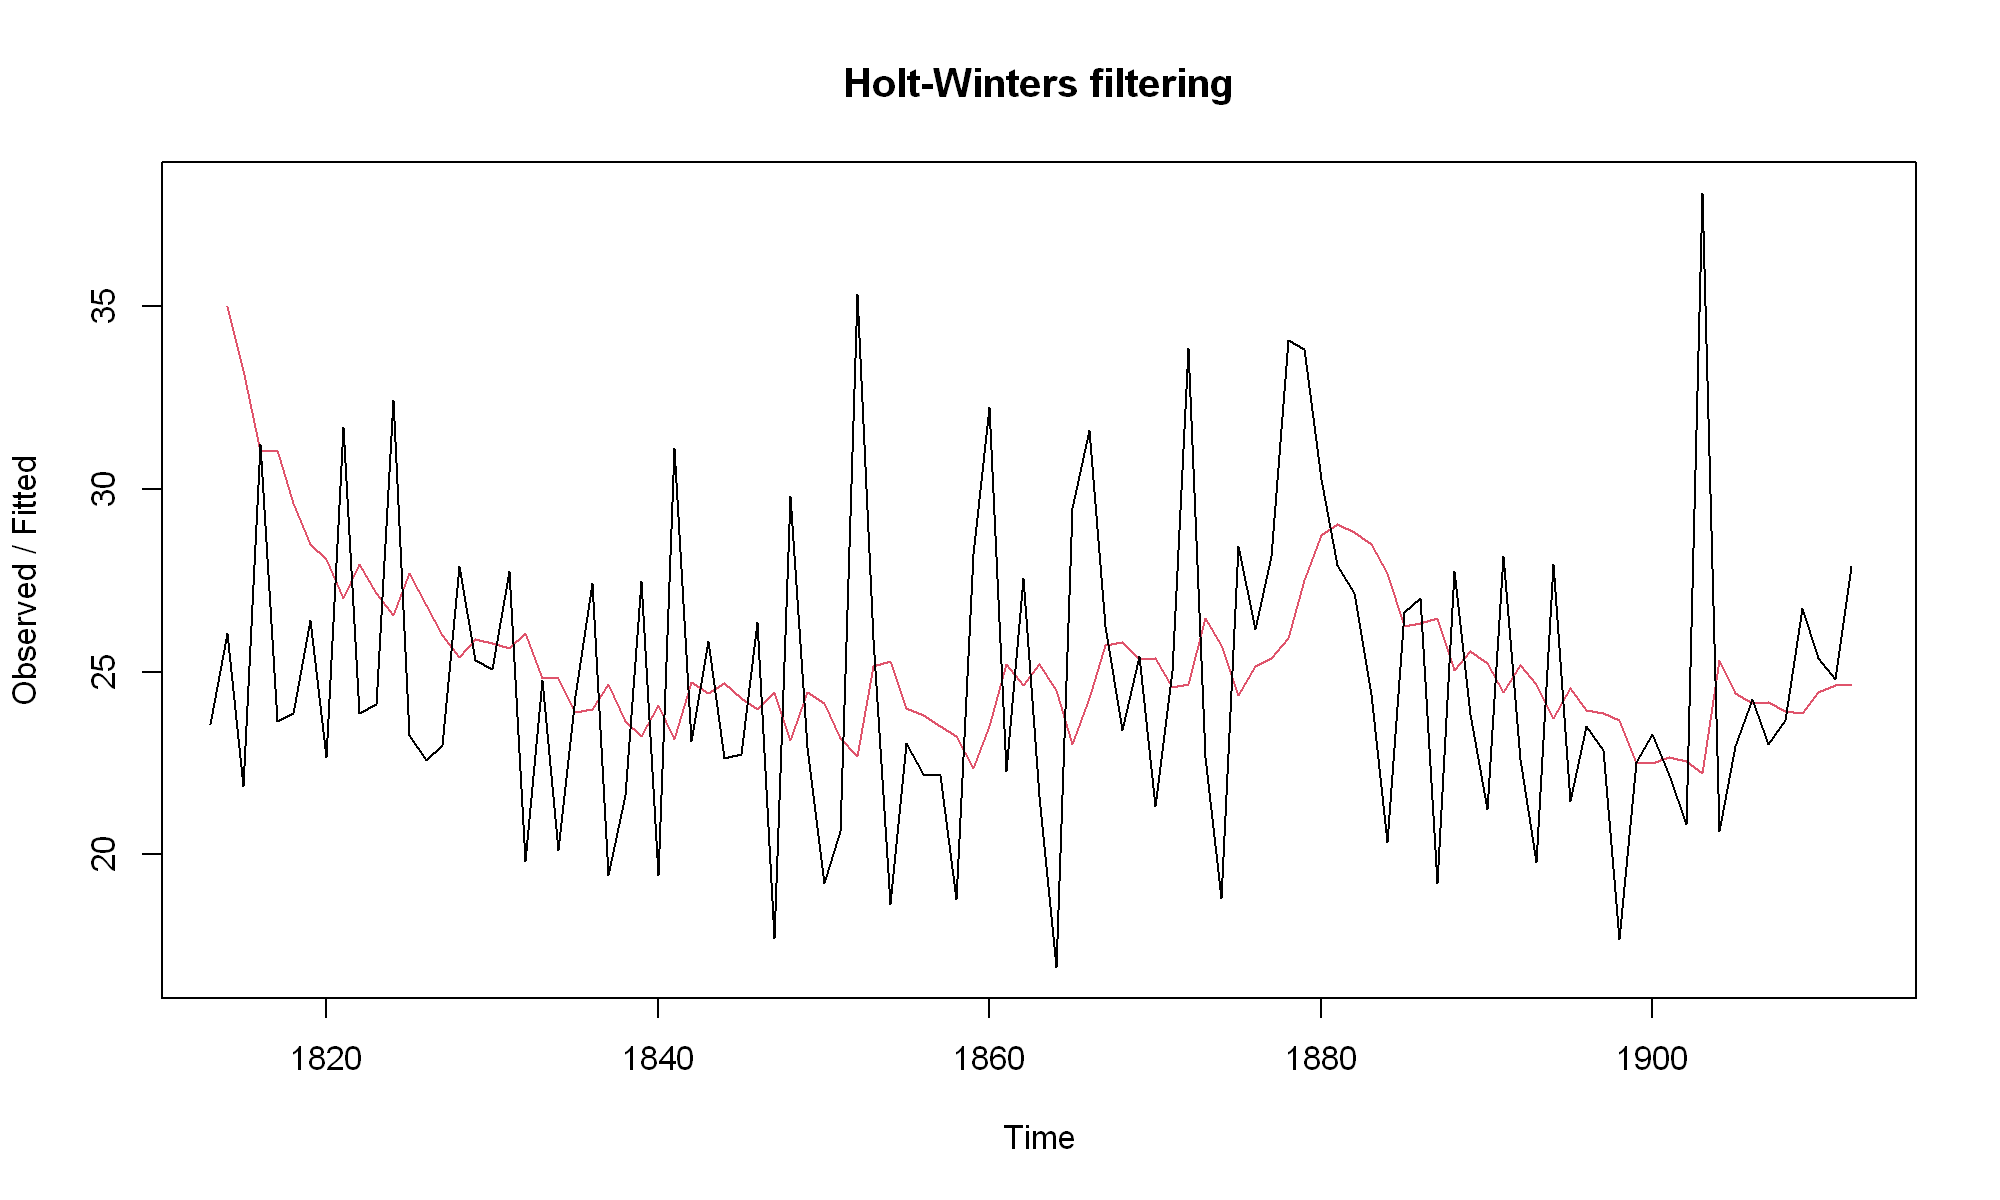

In [127]:
plot(rainforecasts35)

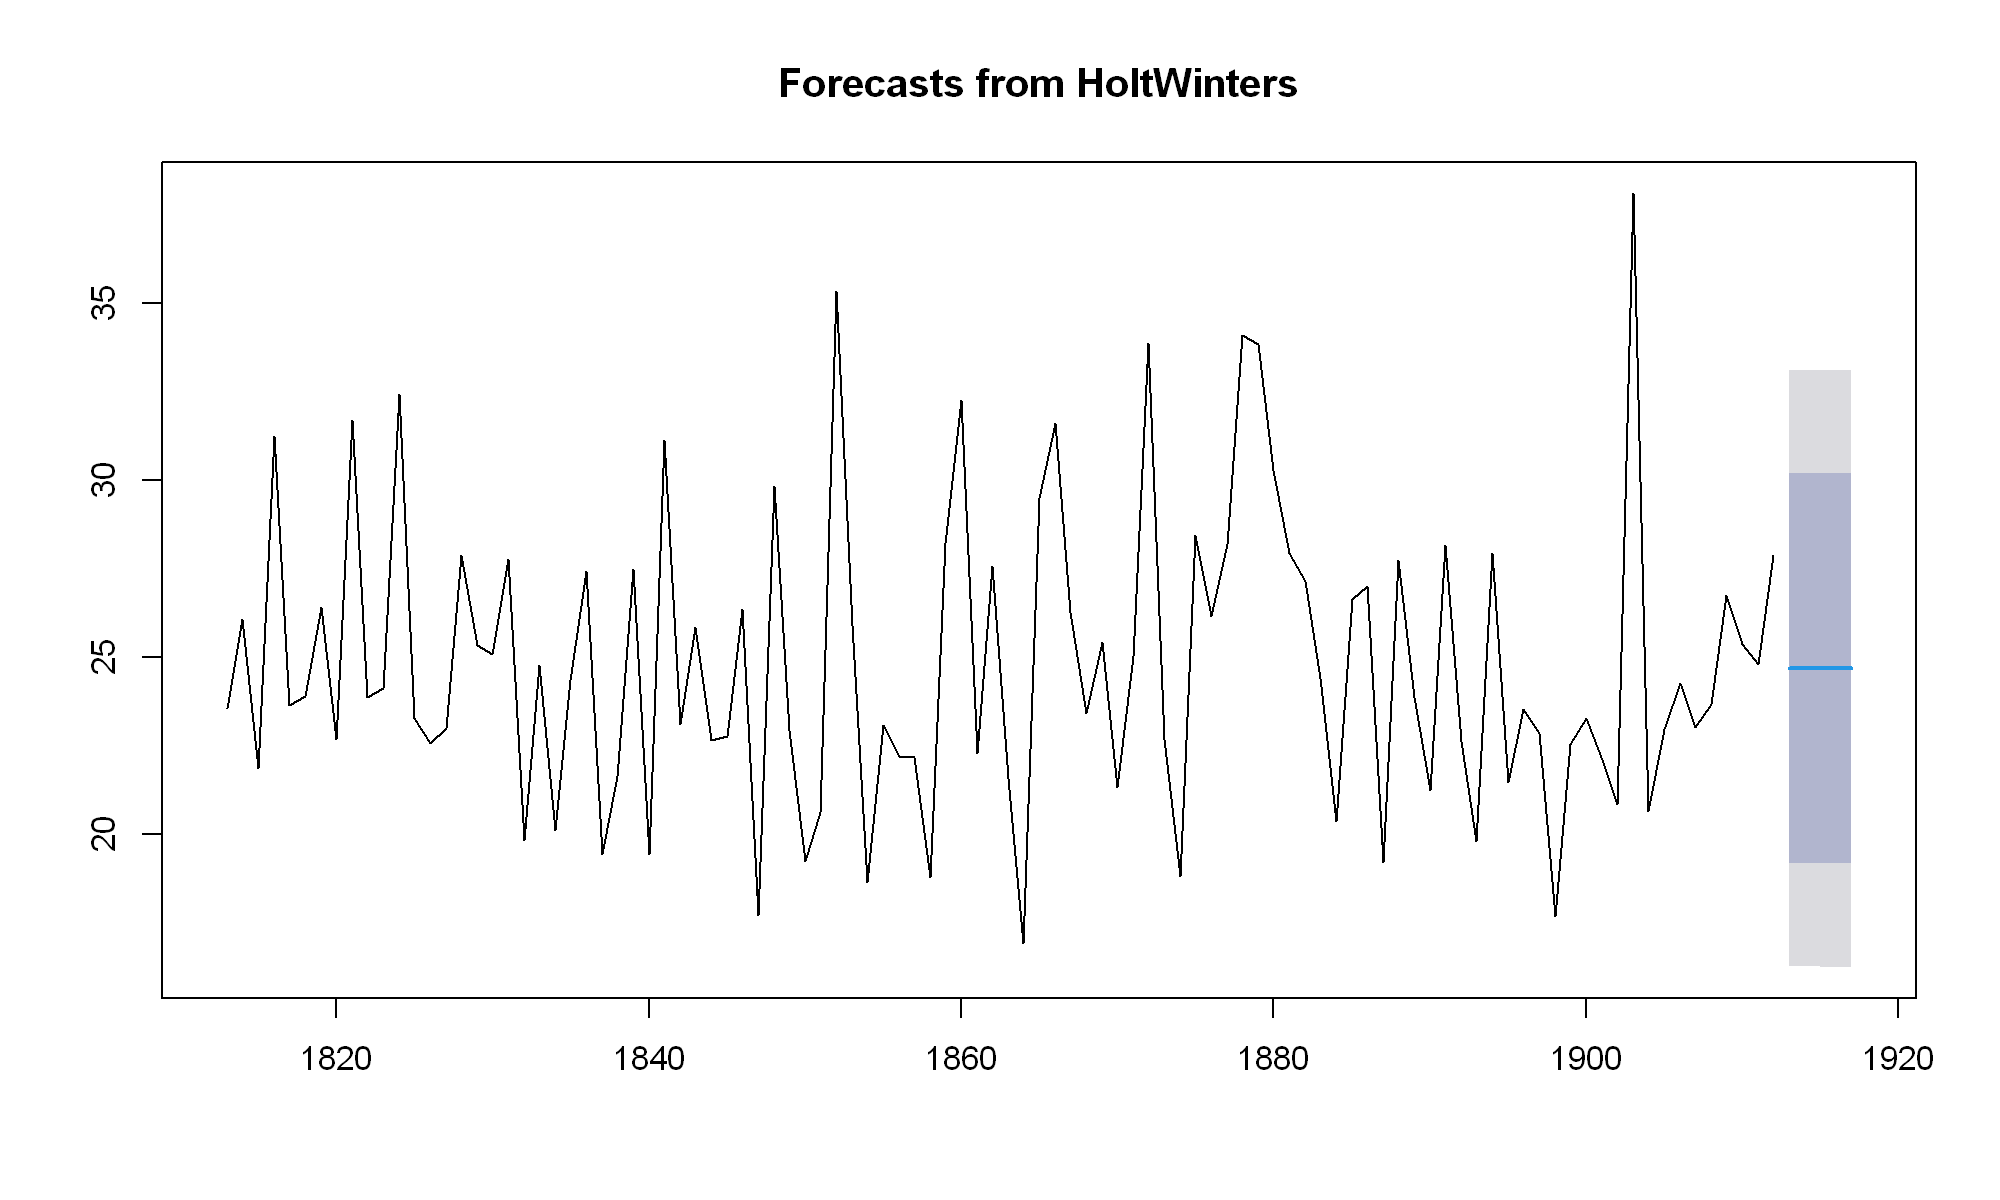

In [132]:
rainforecasts2 <- forecast(rainforecasts, h=5) ## h=예측할 시점, 즉 5개 시점을 예측해서 보겠다
plot(rainforecasts2) ## 회색은 95%신뢰구간, 보라색은 80%신뢰구간

In [134]:
Z <- scan("mindex.txt")

In [137]:
mindex  <- ts(Z,start=c(1986,1),frequency = 12) ## 1986년 1월부터 주기가 12인 데이터를 생성

In [138]:
mindex

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
1986,9.3,10.7,13.3,14.1,17.8,18.1,19.4,18.8,19.1,18.4,18.0,17.0
1987,19.5,20.1,19.4,15.7,15.6,16.1,14.9,16.0,14.6,18.3,18.2,23.0
1988,22.2,22.1,18.8,17.7,13.8,12.7,16.5,15.6,16.3,10.7,10.4,7.0
1989,4.7,4.5,4.0,6.0,6.2,5.7,4.4,4.2,5.0,5.8,6.4,4.9
1990,7.9,8.2,11.8,10.0,11.1,11.7,12.4,15.2,14.0,15.2,12.9,18.0
1991,14.4,12.7,8.3,11.5,11.9,11.6,10.3,8.5,11.6,12.3,14.5,11.1
1992,11.8,12.4,12.7,9.8,10.0,10.2,9.6,6.9,5.3,4.8,4.6,1.9
1993,3.8,4.7,7.7,7.0,7.2,7.8,8.6,11.4,10.7,11.8,11.3,16.0
1994,13.2,12.0,8.5,11.4,,,,,,,,


* 시도표를 확인해본 결과 추세와 계절 성분이 없는 것을 확인하였다. 따라서 단순지수평활법을 적용

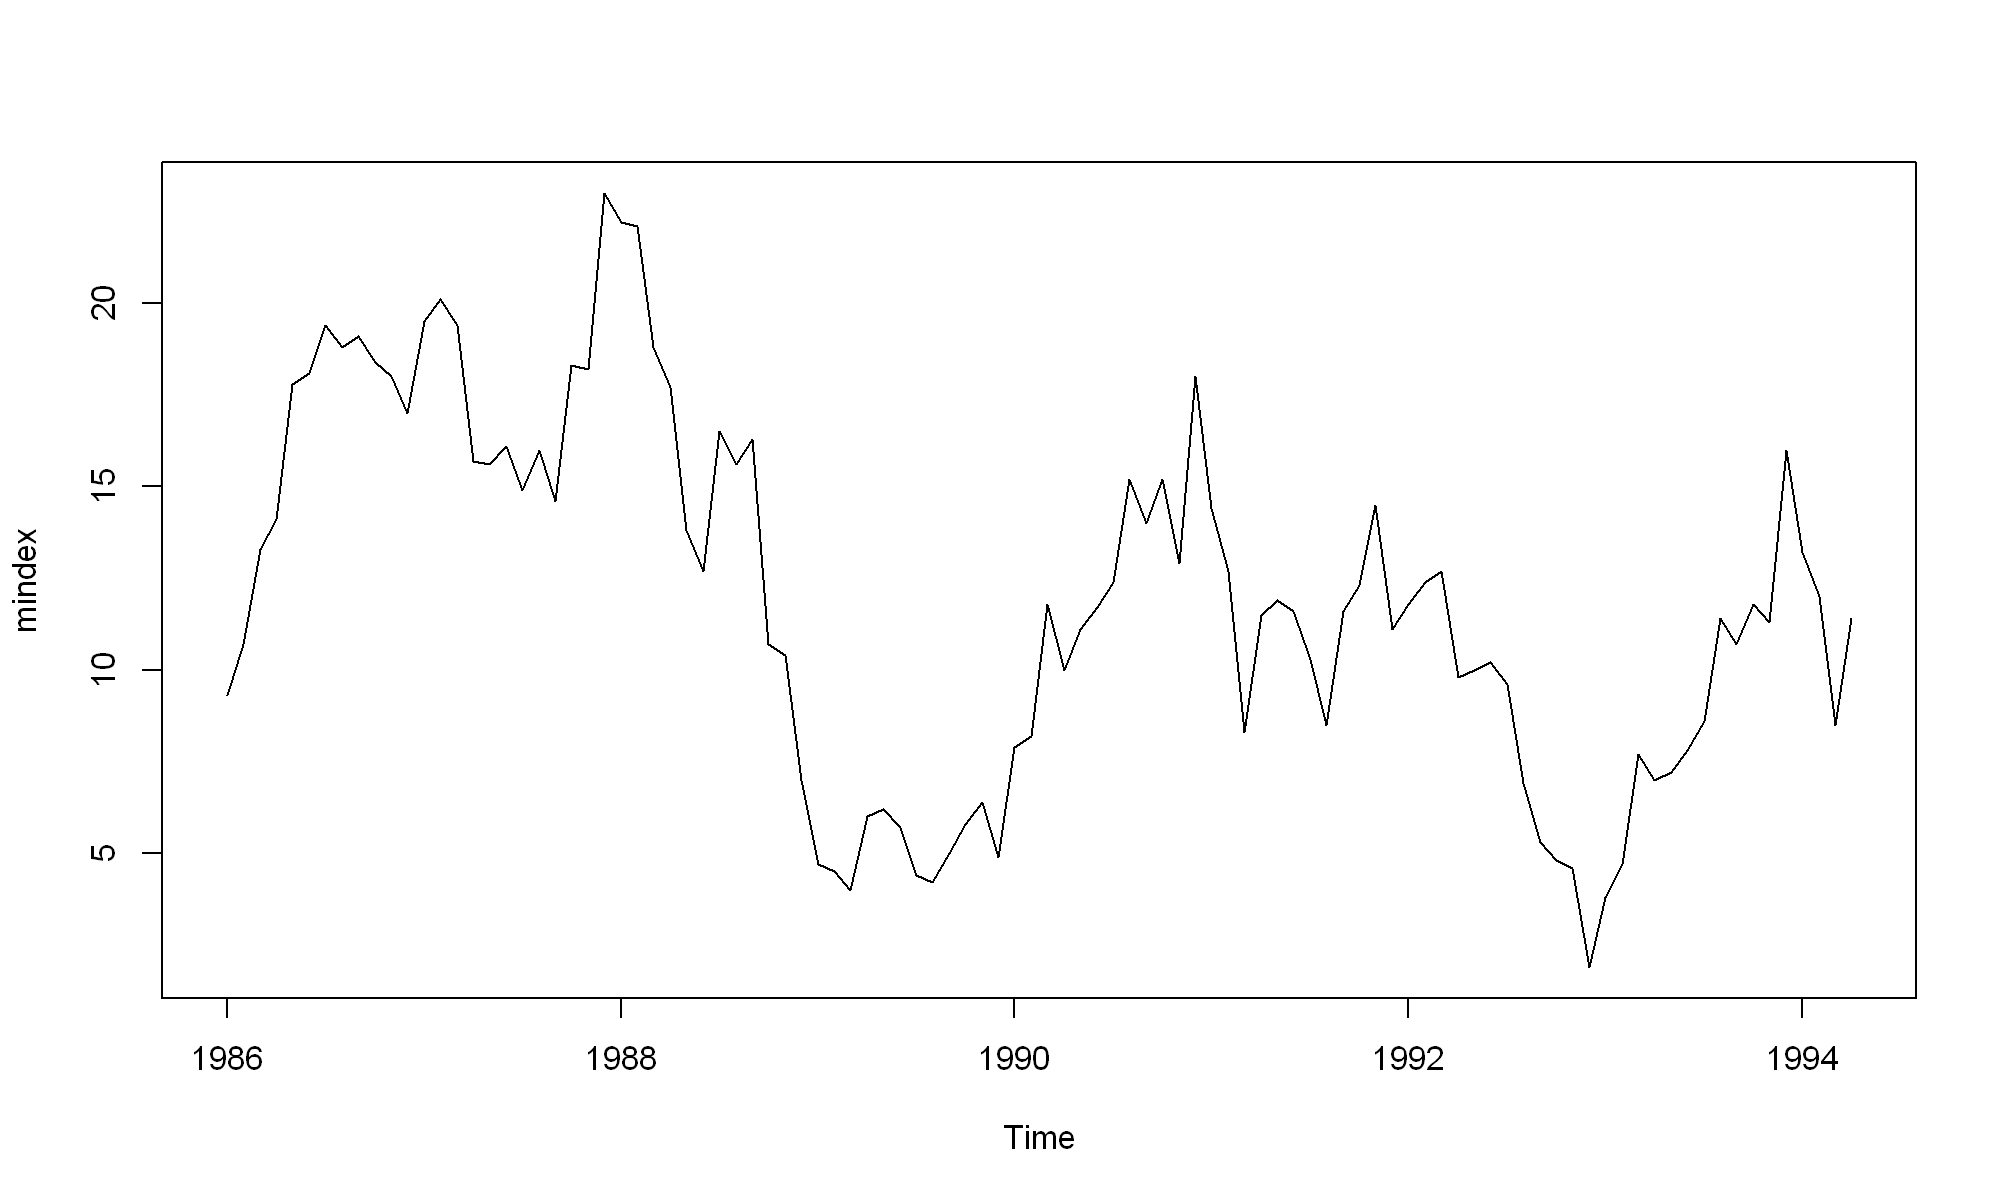

In [139]:
plot.ts(mindex)

In [140]:
mindexforecasts = HoltWinters(mindex, beta=FALSE, gamma=FALSE)
mindexforecasts

Holt-Winters exponential smoothing without trend and without seasonal component.

Call:
HoltWinters(x = mindex, beta = FALSE, gamma = FALSE)

Smoothing parameters:
 alpha: 0.9036403
 beta : FALSE
 gamma: FALSE

Coefficients:
      [,1]
a 11.15433

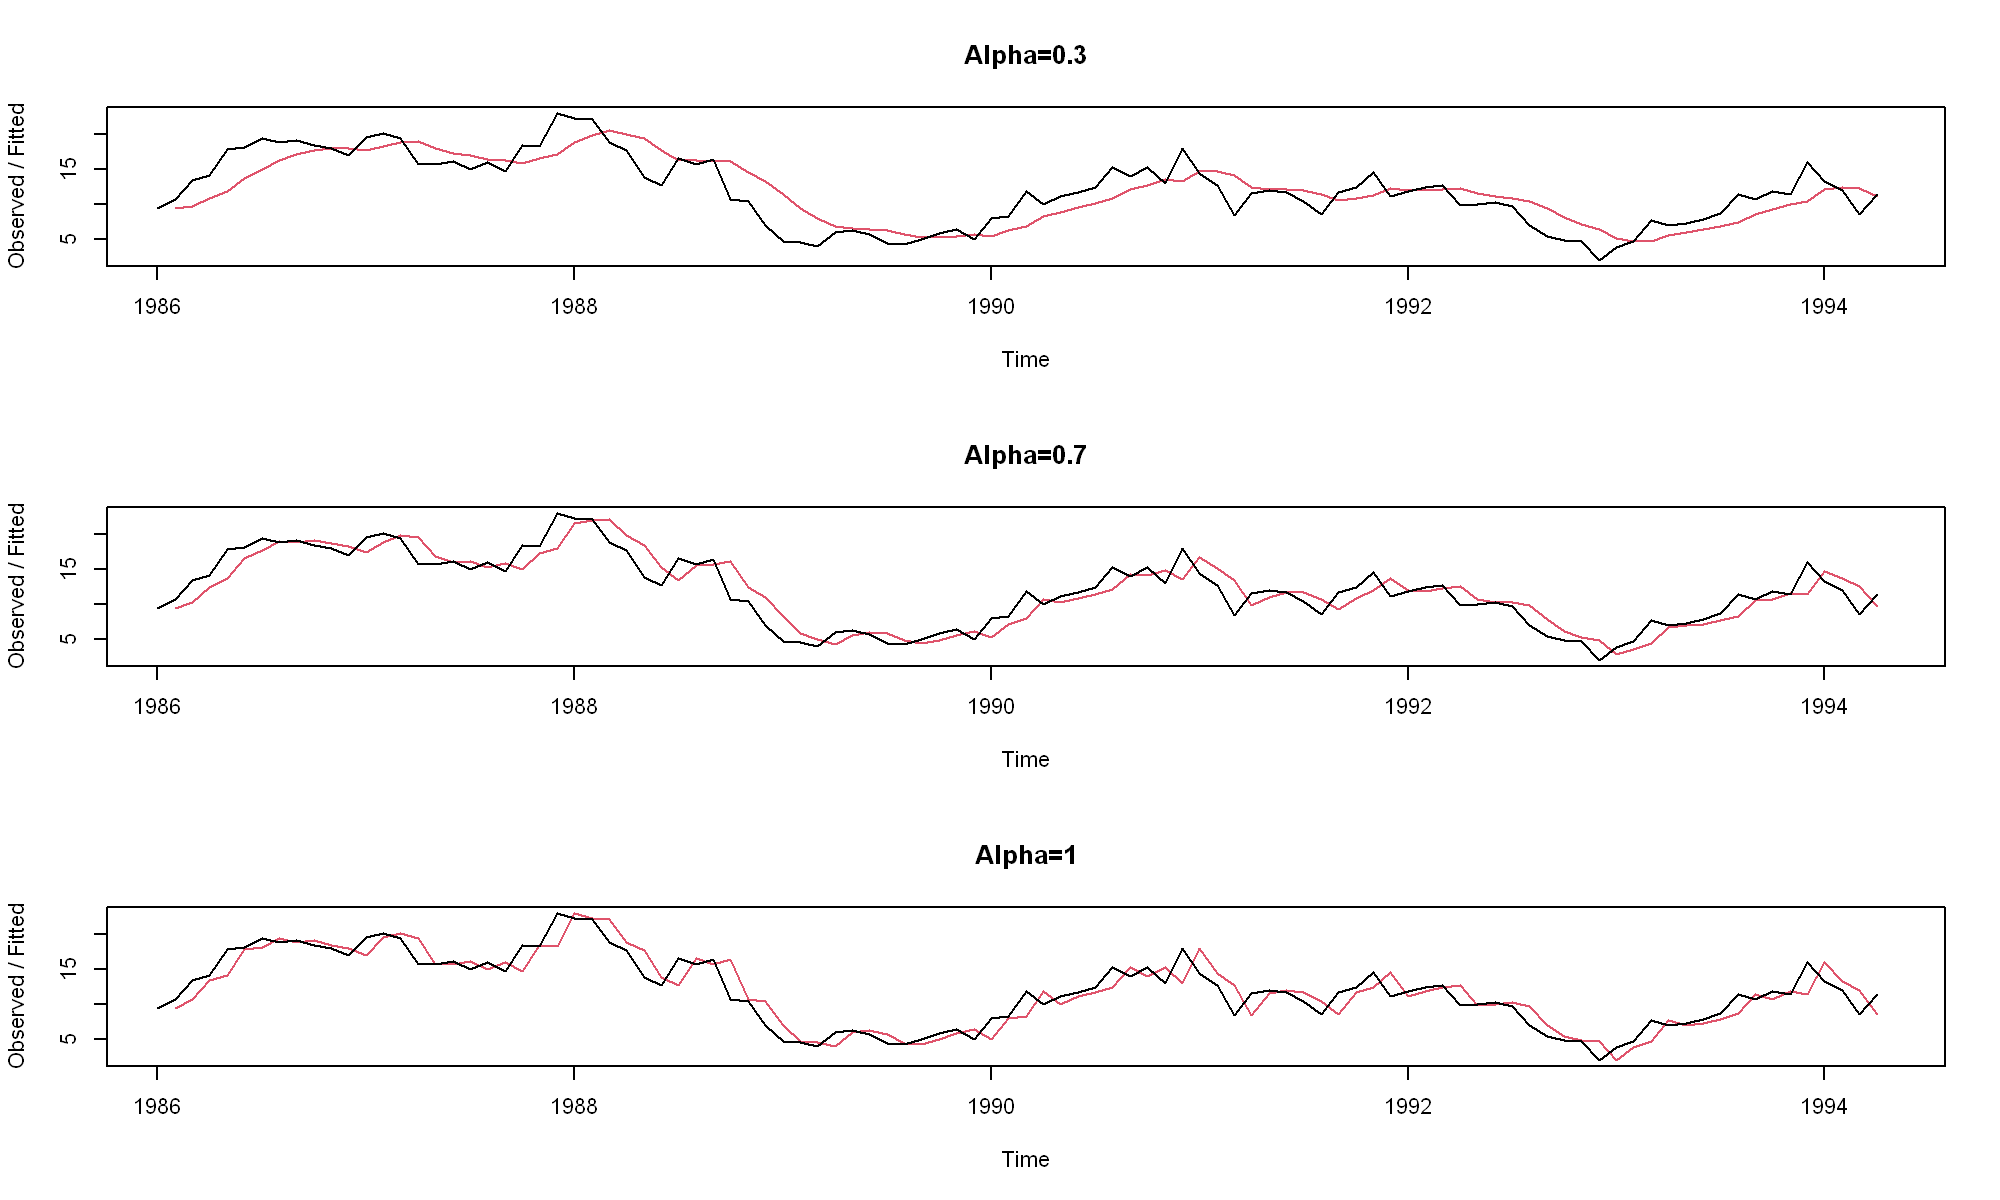

In [141]:
par(mfrow=c(3,1))
plot(HoltWinters(mindex, alpha=0.3,
                 beta=FALSE, gamma=FALSE), main="Alpha=0.3")

plot(HoltWinters(mindex, alpha=0.7,
                 beta=FALSE, gamma=FALSE), main="Alpha=0.7")

plot(HoltWinters(mindex, alpha=1,
                 beta=FALSE, gamma=FALSE), main="Alpha=1")

In [142]:
alpha1=HoltWinters(mindex, alpha=1, beta=FALSE, gamma=FALSE)
alpha1$SSE
alpha07=HoltWinters(mindex, alpha=0.7, beta=FALSE, gamma=FALSE)
alpha07$SSE
alpha03=HoltWinters(mindex, alpha=0.3, beta=FALSE, gamma=FALSE)
alpha03$SSE

[1] 443.23

[1] 462.5034

[1] 792.9686

* 직접적으로 최적의 평활상수를 구해보자

In [149]:
w <-c(seq(0.1,0.8,0.1), seq(0.81, 0.99, 0.01)) 
sse <- sapply(w, function(x) 
  return(sum(ses(mindex, alpha = x)$residuals^2)))

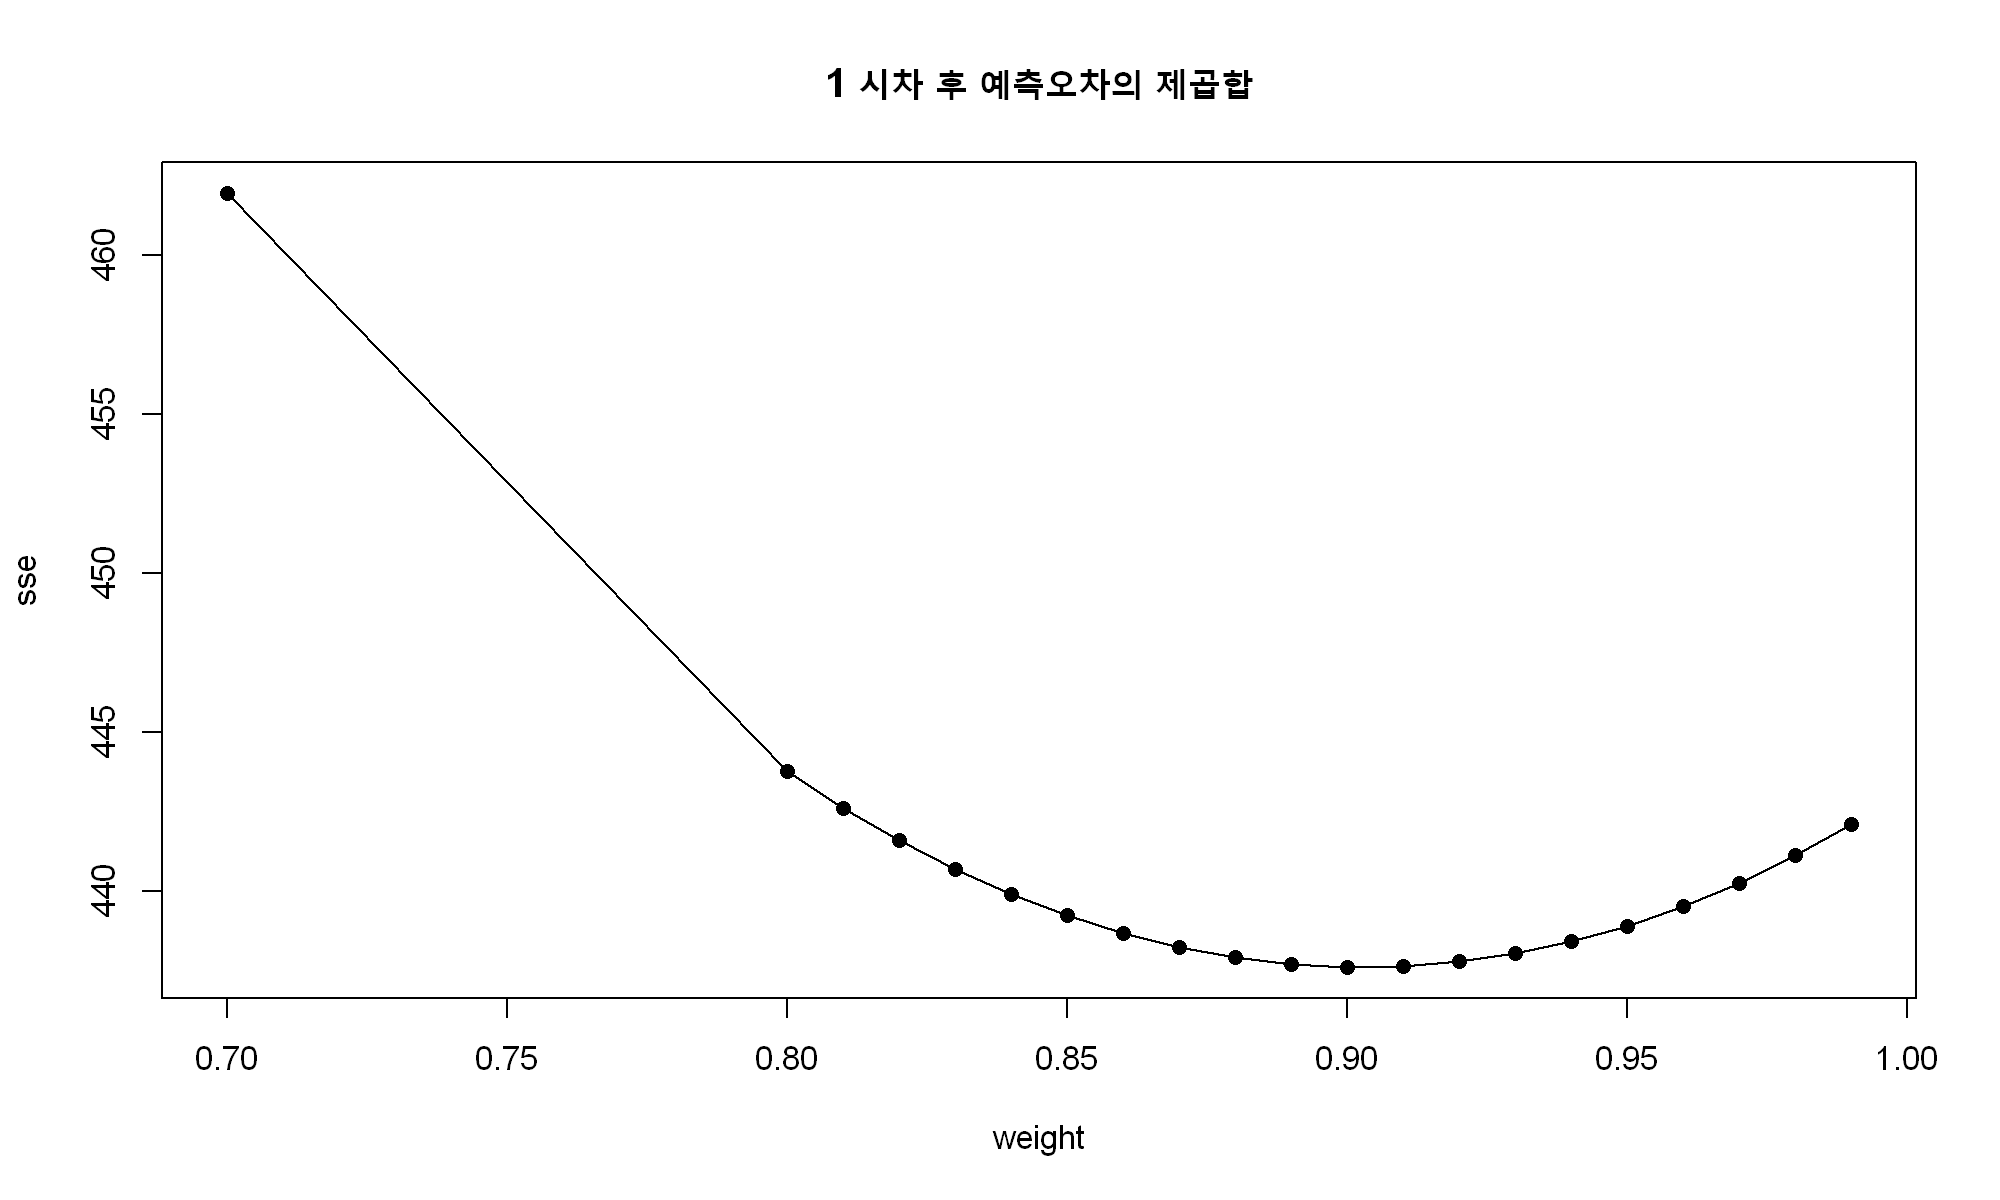

In [145]:
w1 = w[-c(1:6)]  # xaxis from 0.7 to 1.0
sse1 = sse[-c(1:6)]
plot(w1,sse1, type="o", xlab="weight", ylab="sse", pch=16,
     main="1 시차 후 예측오차의 제곱합")

In [146]:
opt_w <- w[which.min(sse)]  # 최적 평활상수값
opt_w

[1] 0.9

In [153]:
fit1 <- ses(mindex, alpha=w[which.min(sse)], h=6) ## ses 함수는 더 예측할 시점을 설정하여 모형을 적합할 수 있음
fit1

         Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
May 1994       11.14643 8.438328 13.85454 7.004743 15.28812
Jun 1994       11.14643 7.503050 14.78982 5.574359 16.71851
Jul 1994       11.14643 6.762982 15.52989 4.442522 17.85034
Aug 1994       11.14643 6.130952 16.16192 3.475916 18.81695
Sep 1994       11.14643 5.570103 16.72276 2.618171 19.67470
Oct 1994       11.14643 5.060723 17.23214 1.839142 20.45372

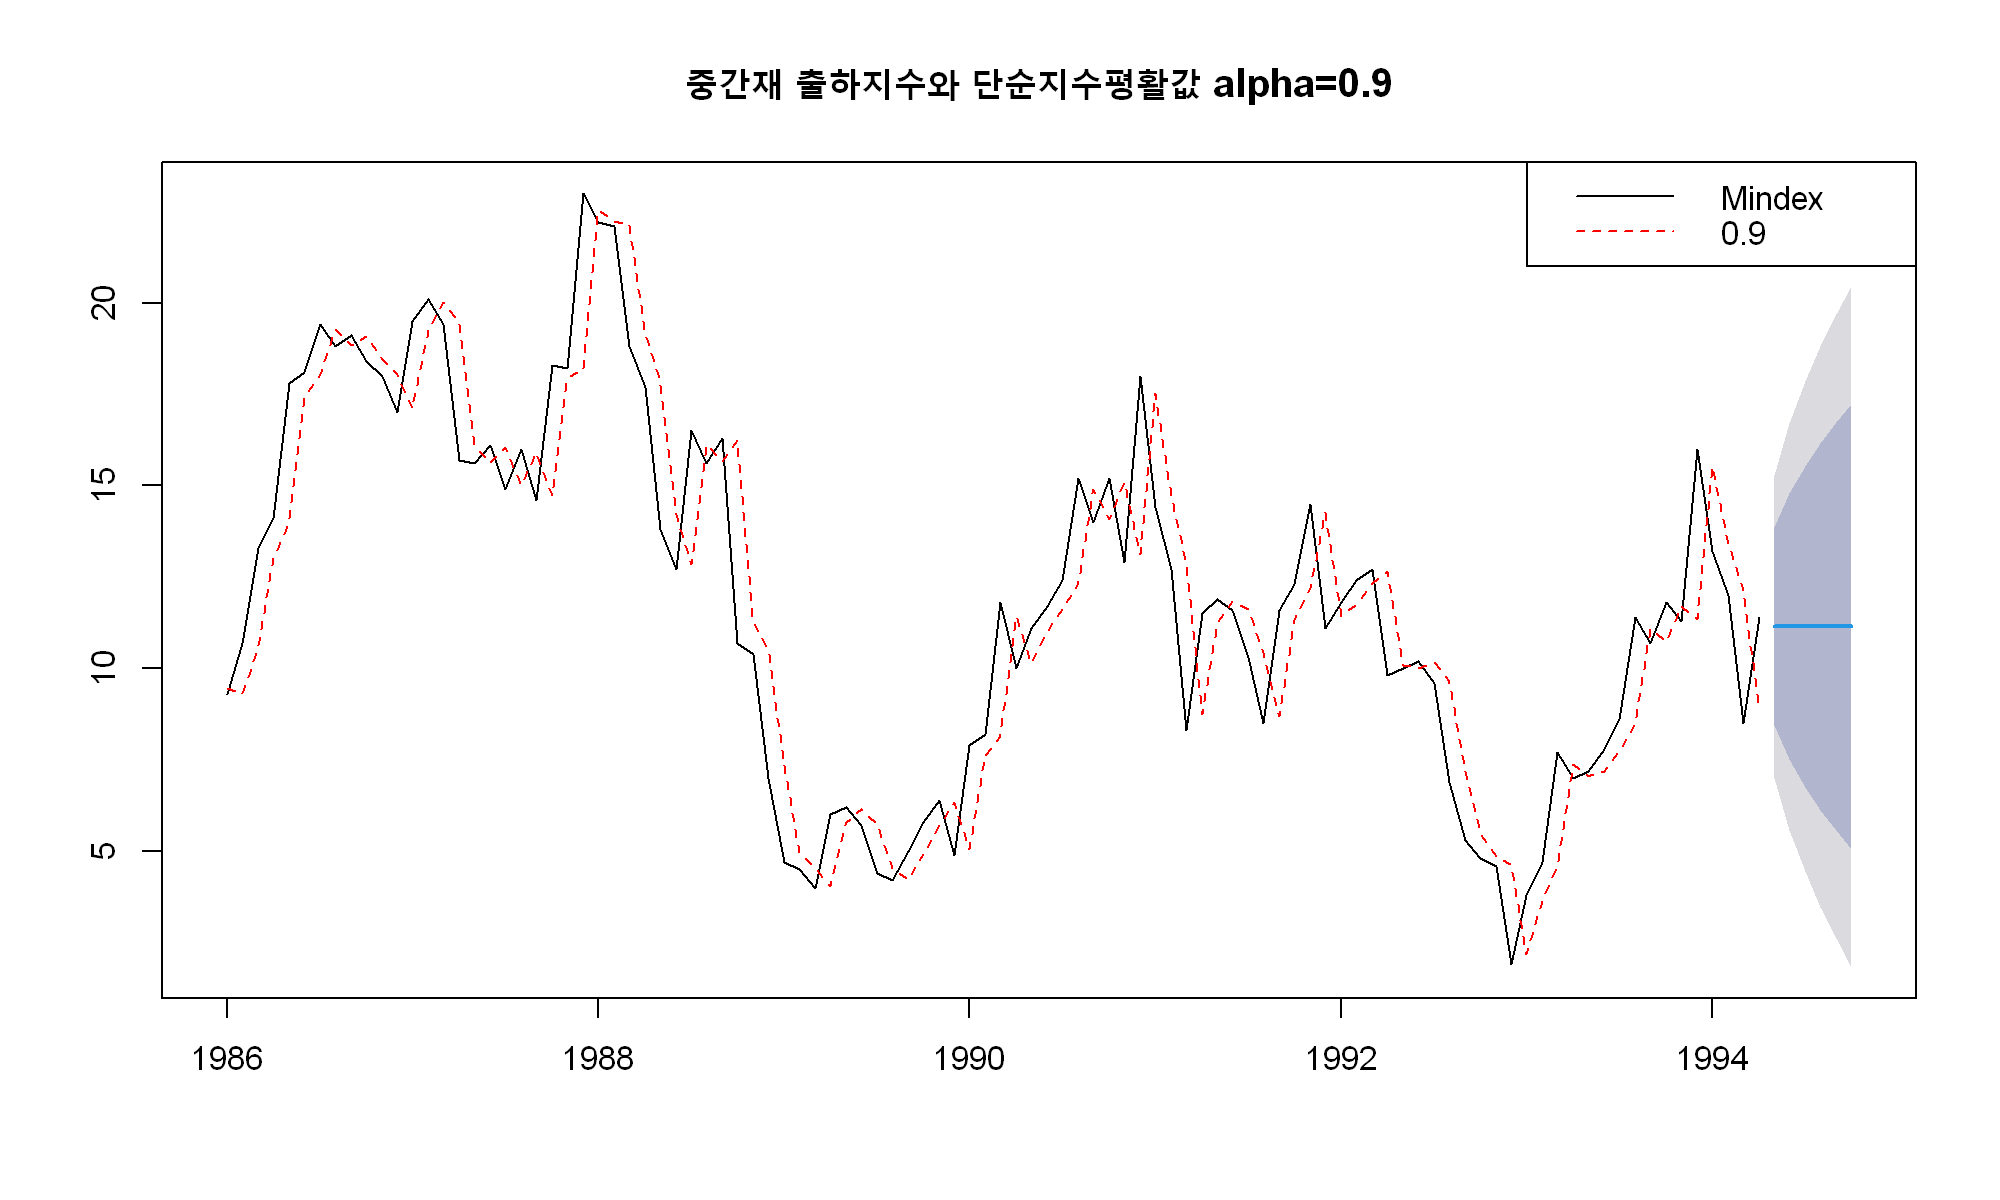

In [152]:
plot(fit1, xlab="", ylab="", 
     main=paste0("중간재 출하지수와 단순지수평활값 alpha=",opt_w), 
     lty=1,col="black" )
lines(fitted(fit1), col="red", lty=2)
legend("topright", legend=c("Mindex", opt_w), 
       lty=1:2,col=c("black","red"))

#### 이중지수 평활법

* 치맛단 길이 데이터를 사용

In [159]:
skirts=scan("http://robjhyndman.com/tsdldata/roberts/skirts.dat",
            skip=5)
skirtsseries <- ts(skirts,start=c(1866))
skirtsseries # 주기가 1년인 데이터

A Time Series:
 [1]  608  617  625  636  657  691  728  784  816  876  949  997 1027 1047 1049
[16] 1018 1021 1012 1018  991  962  921  871  829  822  820  802  821  819  791
[31]  746  726  661  620  588  568  542  551  541  557  556  534  528  529  523
[46]  531

* 시도표를 살펴본 결과 올라가다가 내려가는? 추세를 볼 수 있다.
* 또한 추세가 일정한 것보다는 시간에 따라 추세가 변하는 것을 볼 수 있다
* 따라서 일반적인 추세모형을 적합할 수 없으므로 이중지수평활법을 사용

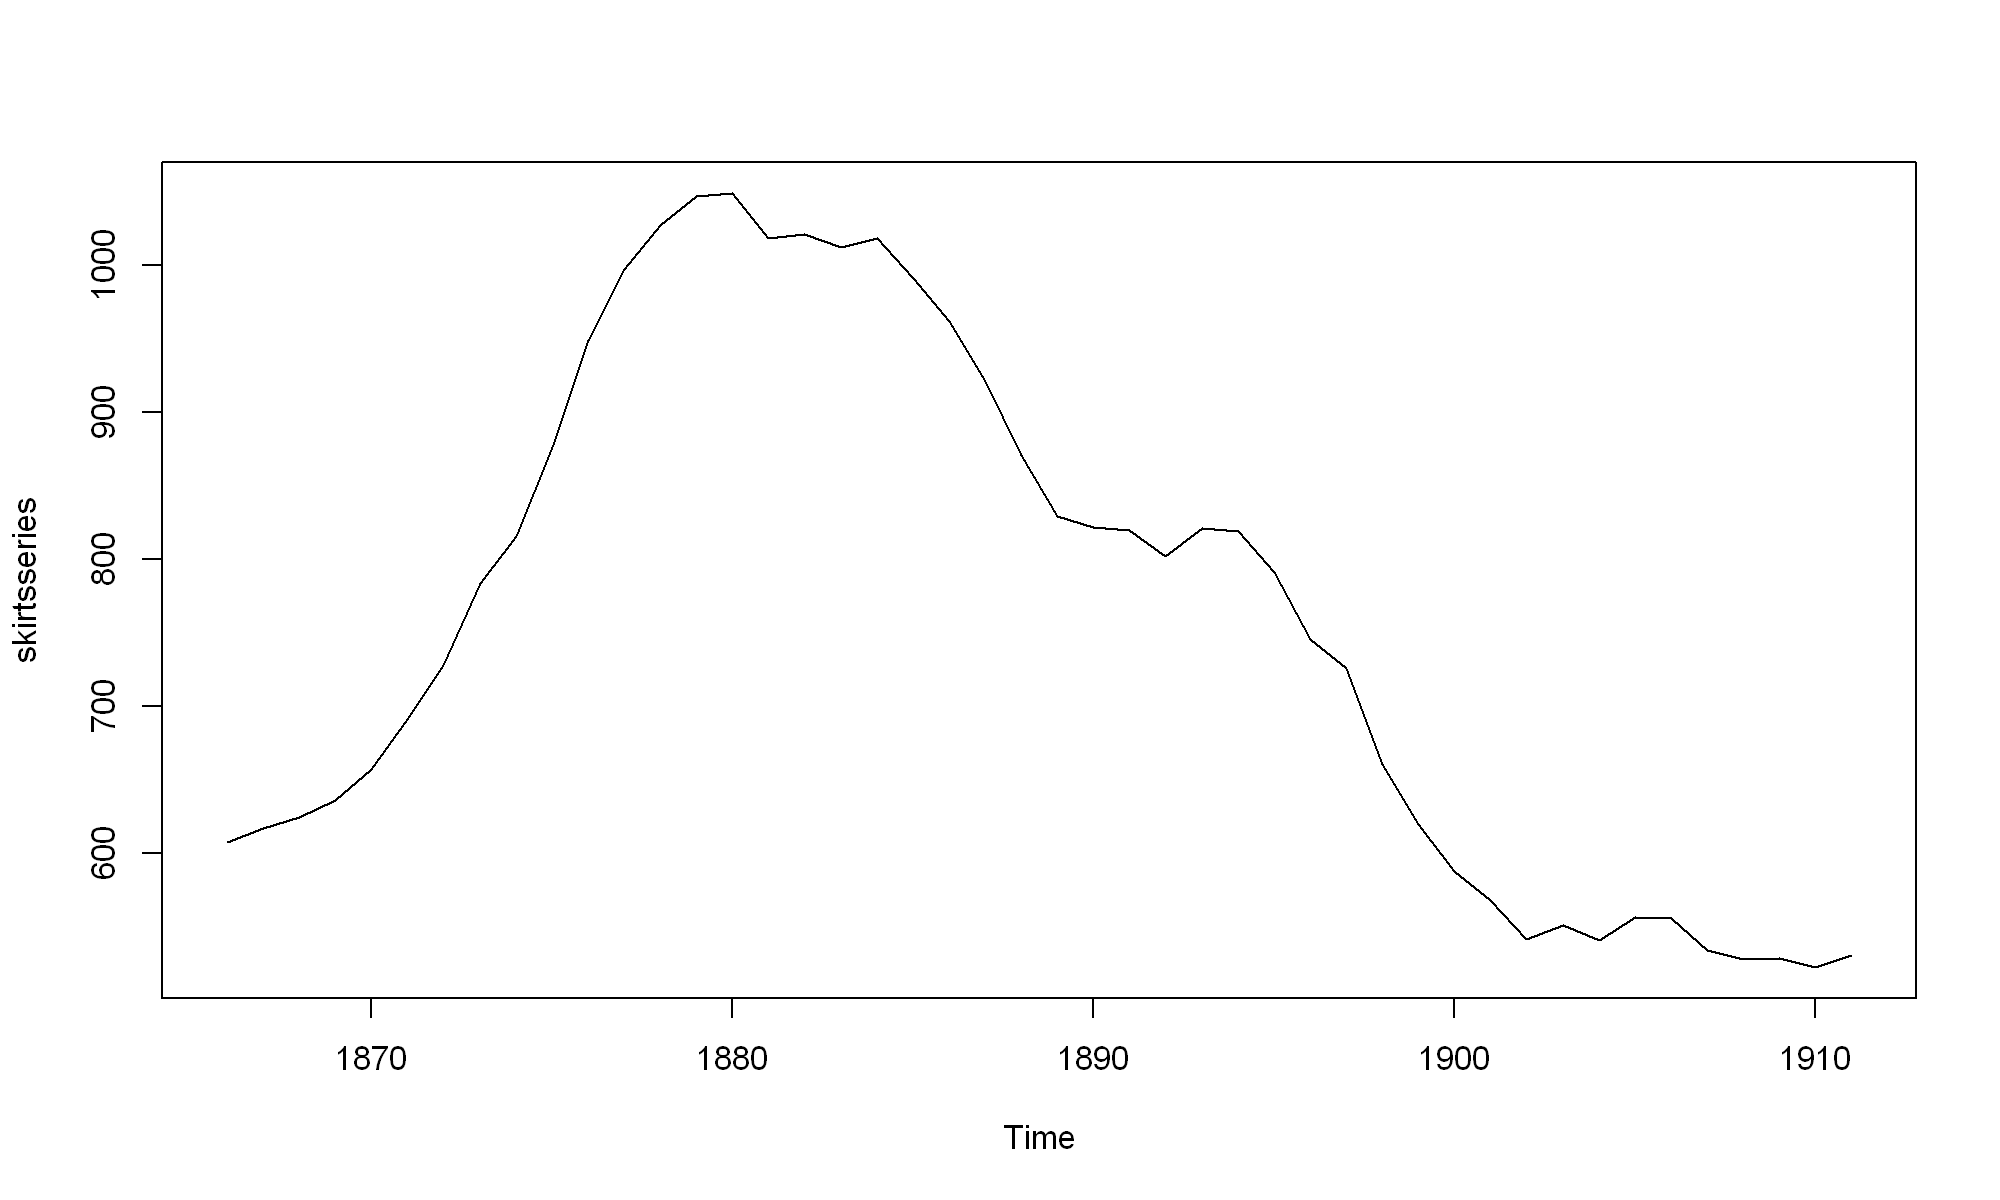

In [160]:
plot.ts(skirtsseries)

[이중지수평활법] gamma =F

In [161]:
skirtforecasts <- HoltWinters(skirtsseries, gamma=FALSE)
skirtforecasts 

Holt-Winters exponential smoothing with trend and without seasonal component.

Call:
HoltWinters(x = skirtsseries, gamma = FALSE)

Smoothing parameters:
 alpha: 0.8383481
 beta : 1
 gamma: FALSE

Coefficients:
        [,1]
a 529.308585
b   5.690464

* $\beta = 1, \alpha = 0.83\dots$로  최근값에 가중치가 더 많이 들어간 것으로 확인된다.

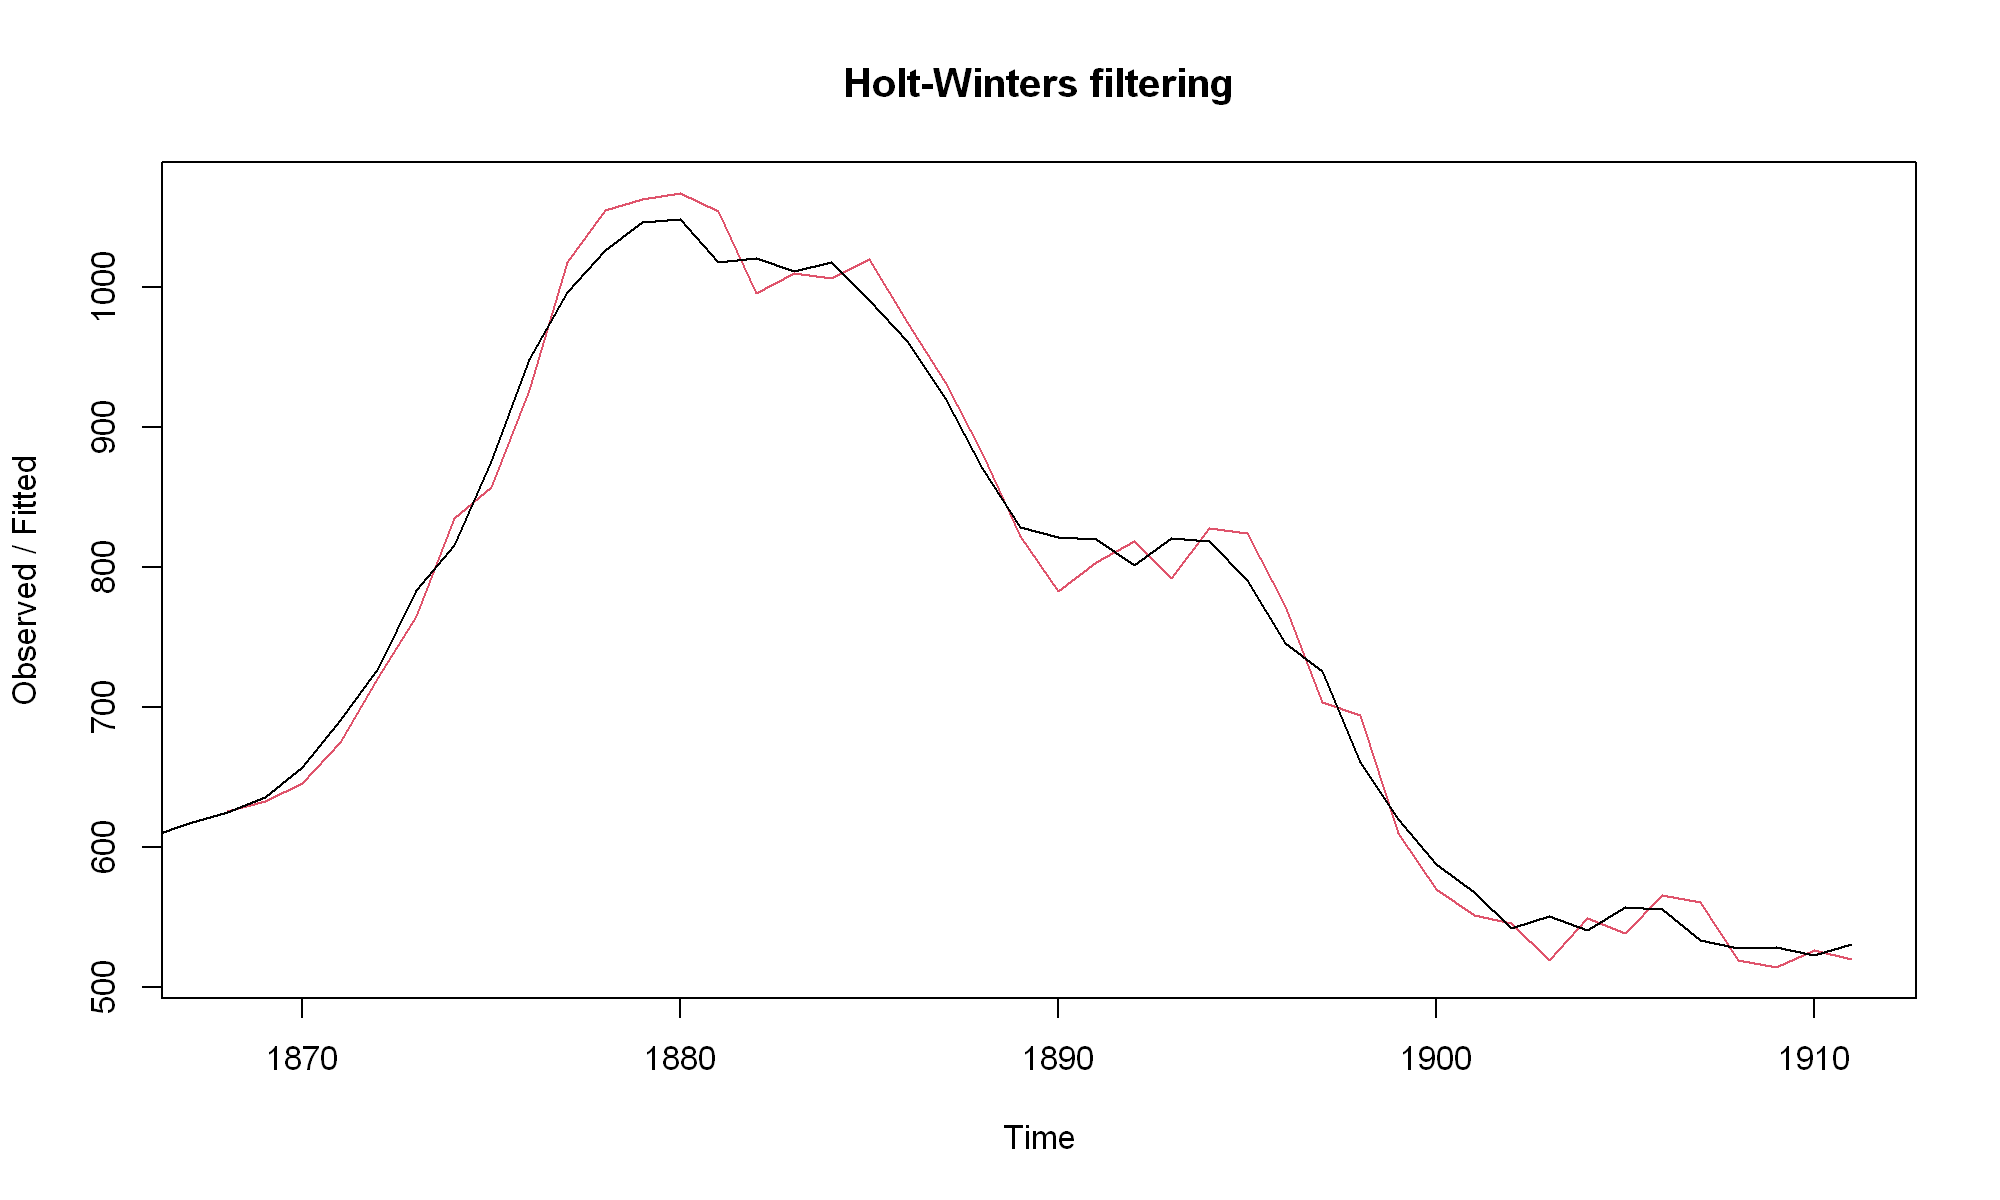

In [162]:
plot(skirtforecasts)

[이중지수평활법] 예측

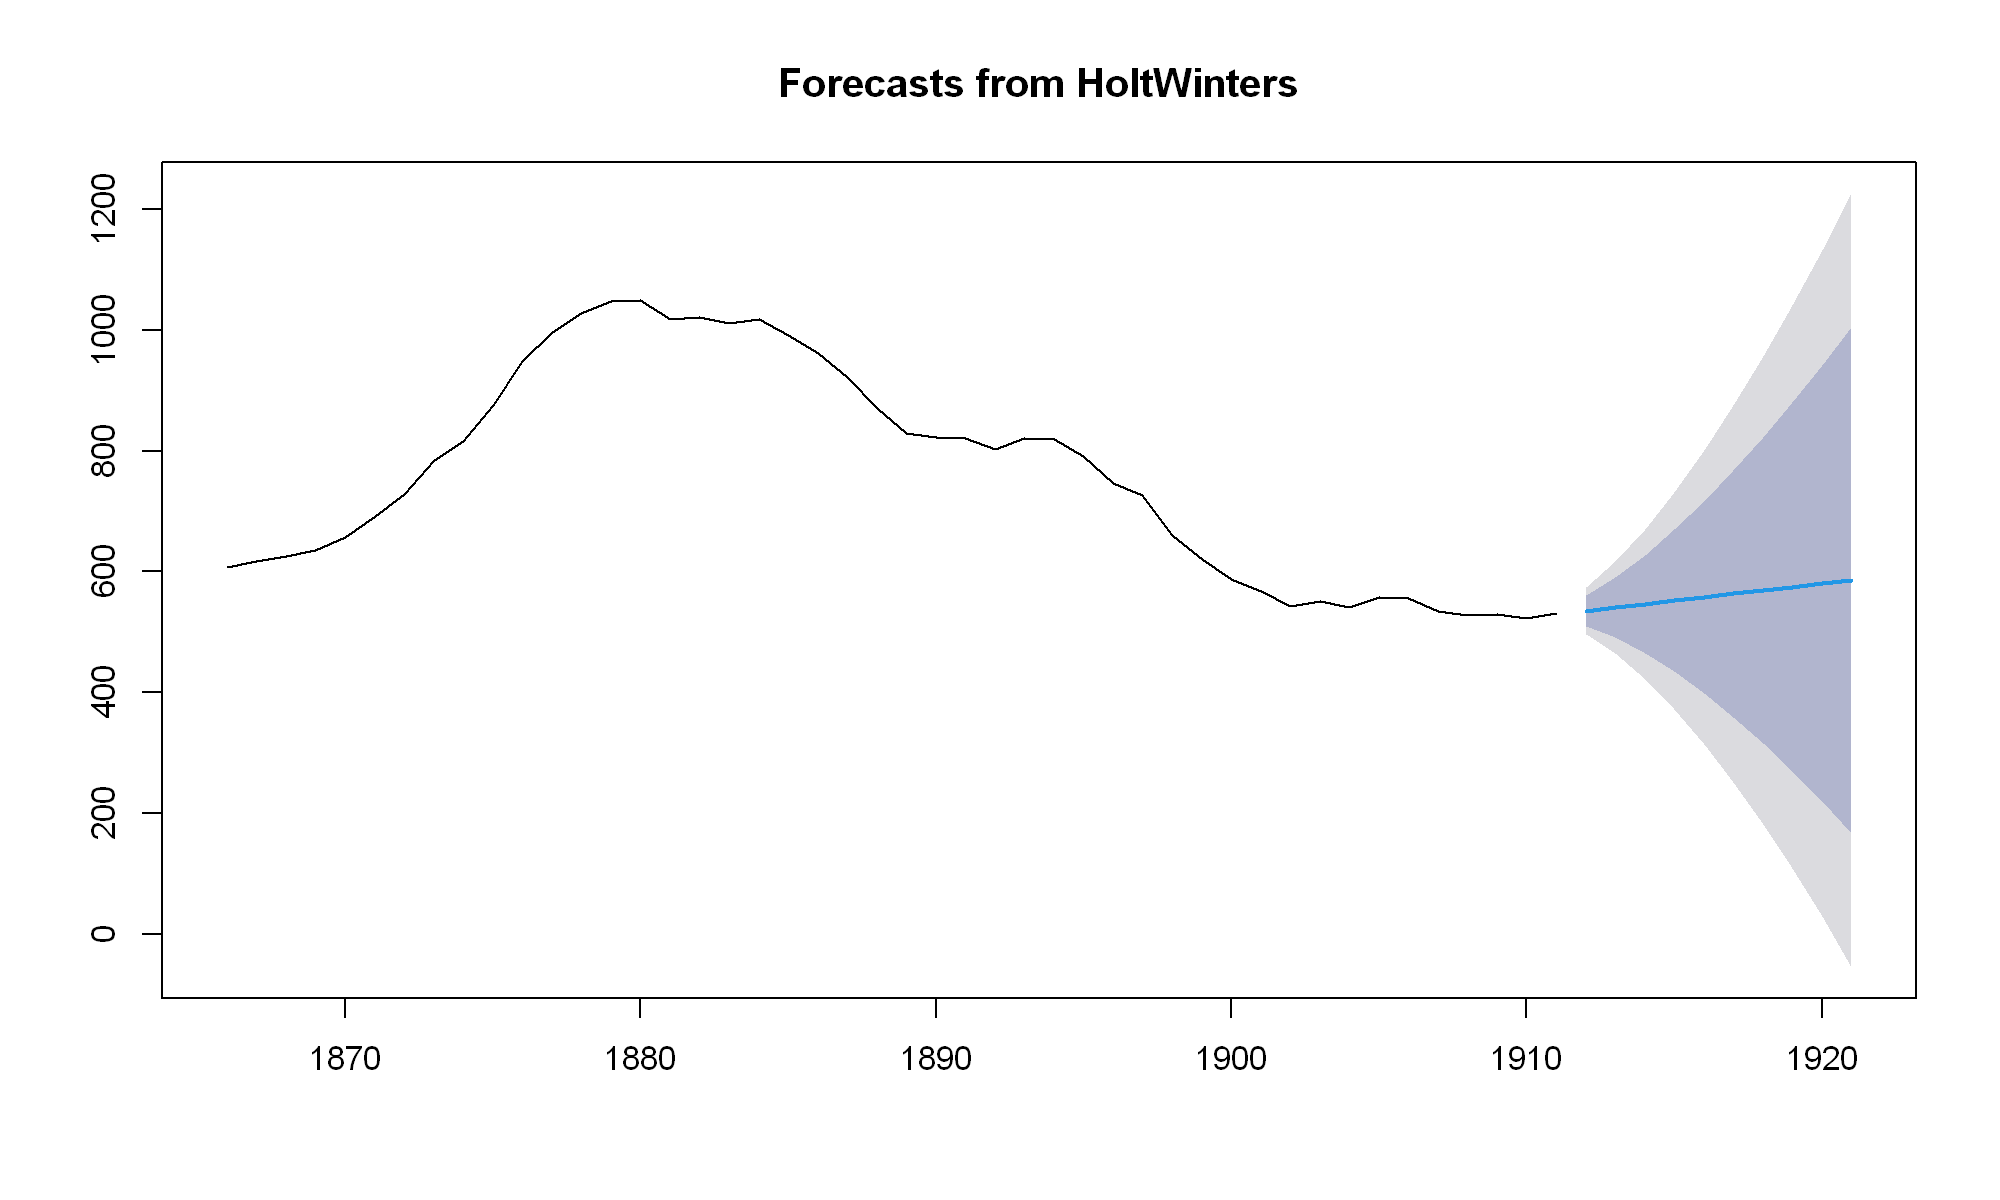

In [164]:
skirtsforecasts2=forecast(skirtforecasts, h=10)
plot(skirtsforecasts2)

In [167]:
z <- scan("stock.txt")
stock <- ts(z, start=c(1984,1), frequency=12)
stock

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
1984,118.60,129.84,129.12,133.23,131.74,133.53,133.15,135.08,134.74,132.21,132.94,138.34
1985,139.98,135.72,134.30,136.14,133.17,137.35,135.77,136.54,136.34,140.21,145.26,135.37
1986,157.54,168.83,187.77,206.02,209.57,239.30,260.24,268.28,262.02,243.64,257.00,237.30
1987,289.09,320.53,365.85,368.66,383.97,387.28,454.00,483.98,481.52,509.43,477.53,489.00
1988,579.48,644.36,624.94,643.46,673.32,710.98,696.84,693.39,675.05,713.39,778.15,884.34
1989,884.23,902.21,965.89,959.12,936.94,900.75,886.35,922.35,951.58,913.00,898.67,901.80
1990,898.00,867.18,845.48,785.50,771.65,766.70,698.17,637.42,602.21,682.79,696.44,712.46
1991,647.53,654.72,670.55,638.34,630.19,604.73,646.25,710.56,684.34,705.16,668.07,625.06


* 레벨과 추세가 시간에 따라 변하는 것을 알 수 있다.

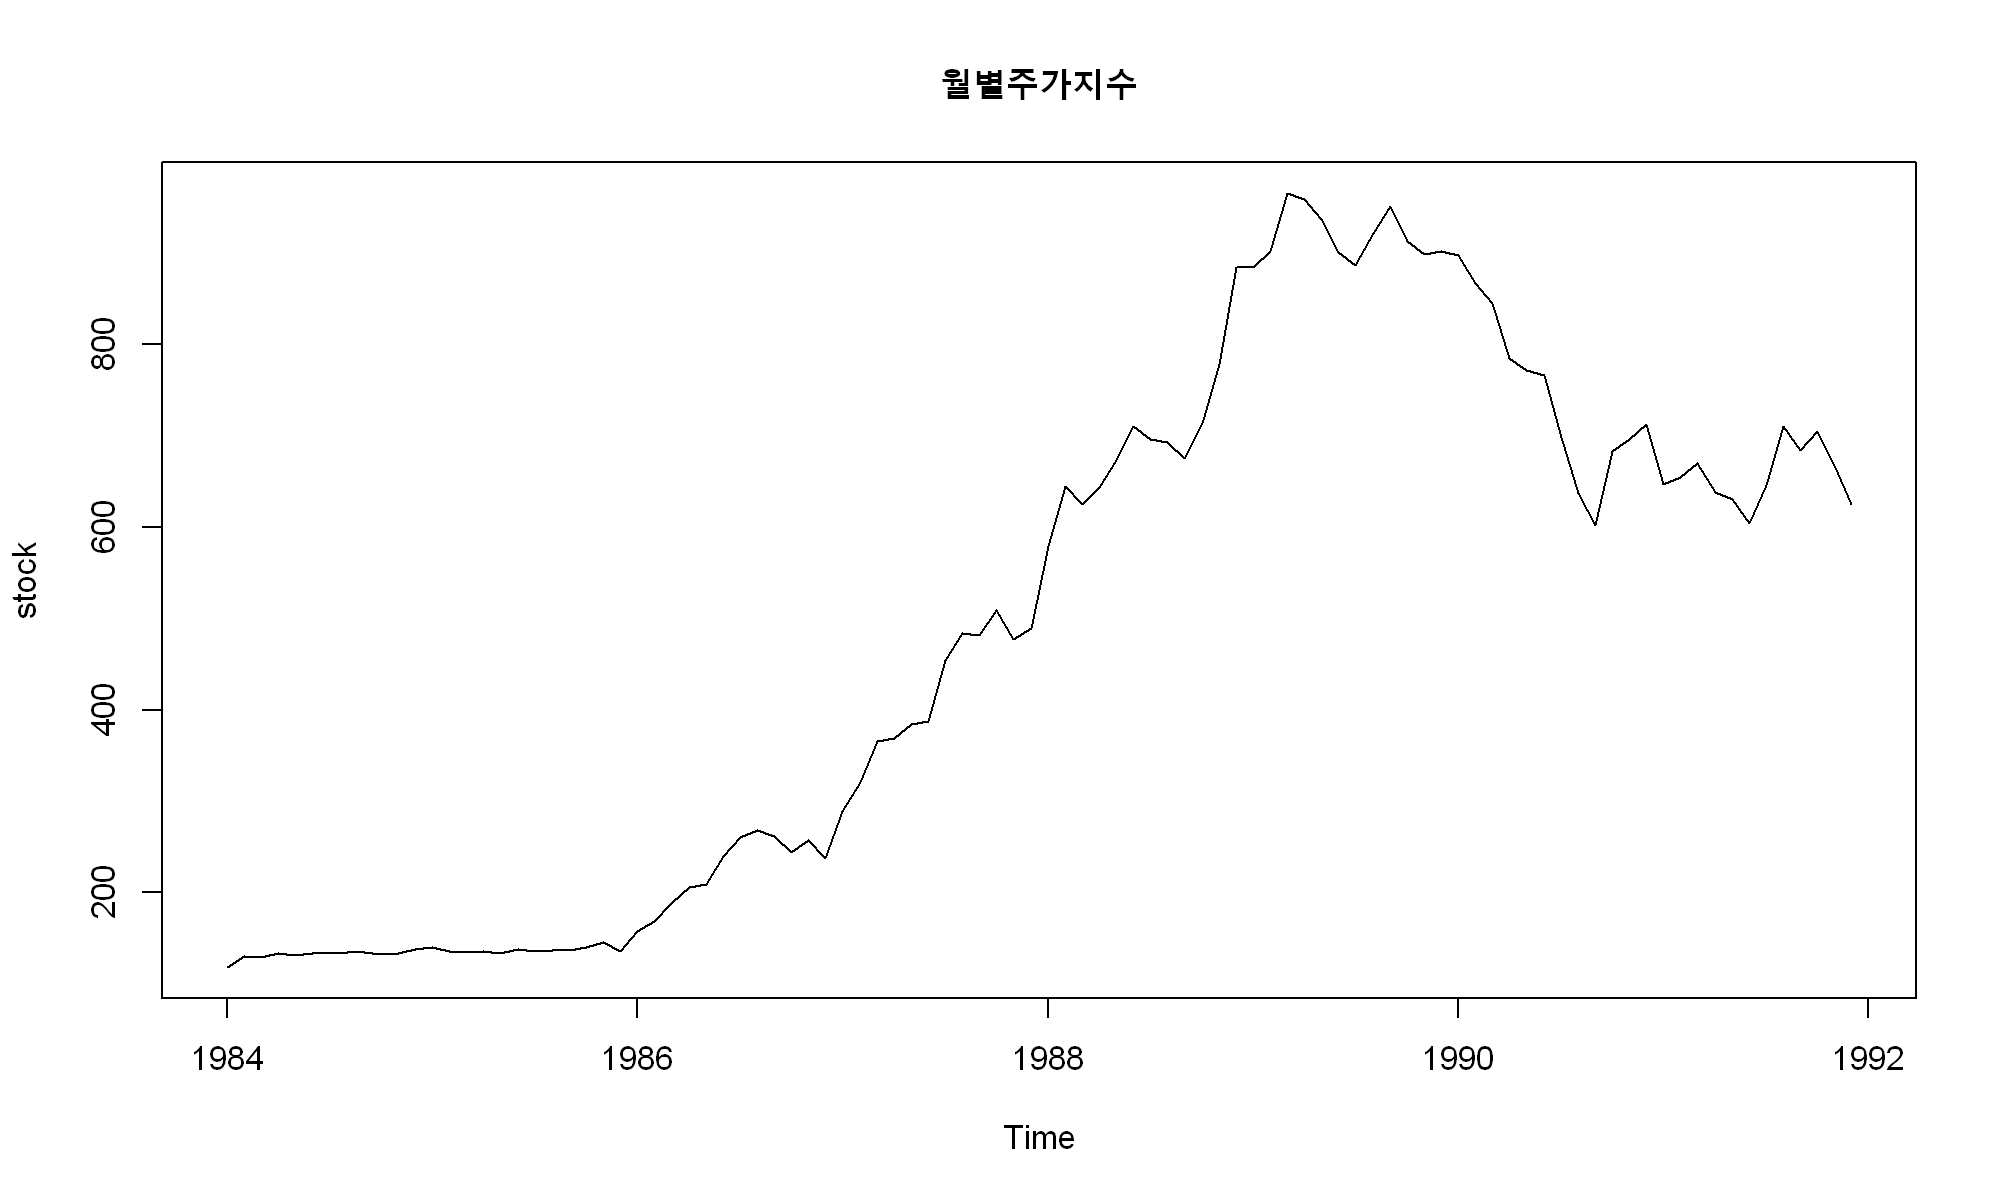

In [168]:
plot.ts(stock, main='월별주가지수')

In [170]:
fit4 = HoltWinters(stock, alpha=0.6, beta=0.6, gamma=FALSE) 
fit4

Holt-Winters exponential smoothing with trend and without seasonal component.

Call:
HoltWinters(x = stock, alpha = 0.6, beta = 0.6, gamma = FALSE)

Smoothing parameters:
 alpha: 0.6
 beta : 0.6
 gamma: FALSE

Coefficients:
       [,1]
a 650.78081
b -26.14166

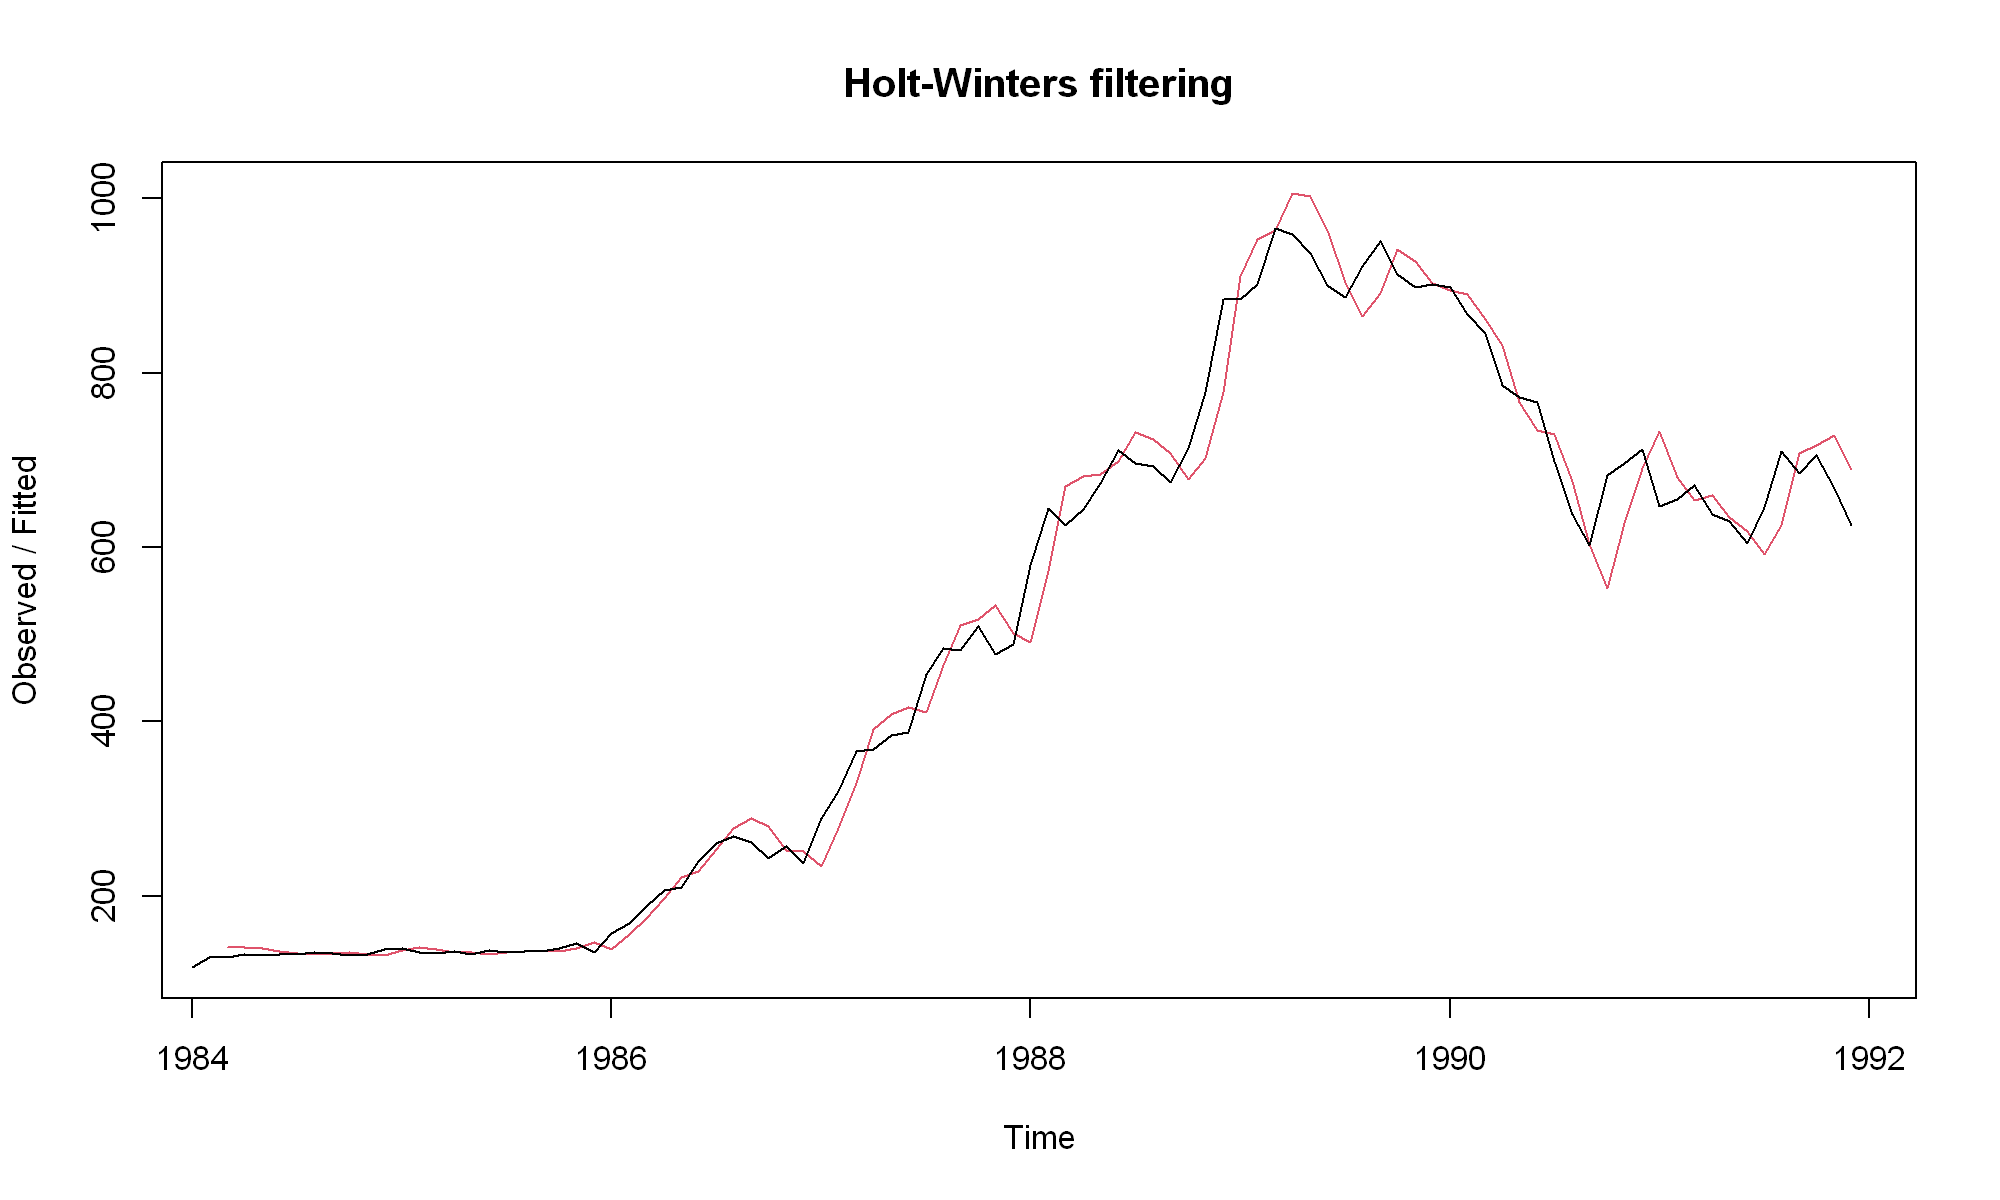

In [171]:
plot(fit4)

* $\alpha=1, \beta = 0.109\dots$  알파는 최근값, 베타는 과거값에 가중치를 더 많이 주었다.

In [172]:
fit5 = HoltWinters(stock, gamma=FALSE) 
fit5

Holt-Winters exponential smoothing with trend and without seasonal component.

Call:
HoltWinters(x = stock, gamma = FALSE)

Smoothing parameters:
 alpha: 1
 beta : 0.1094451
 gamma: FALSE

Coefficients:
        [,1]
a 625.060000
b  -7.097122

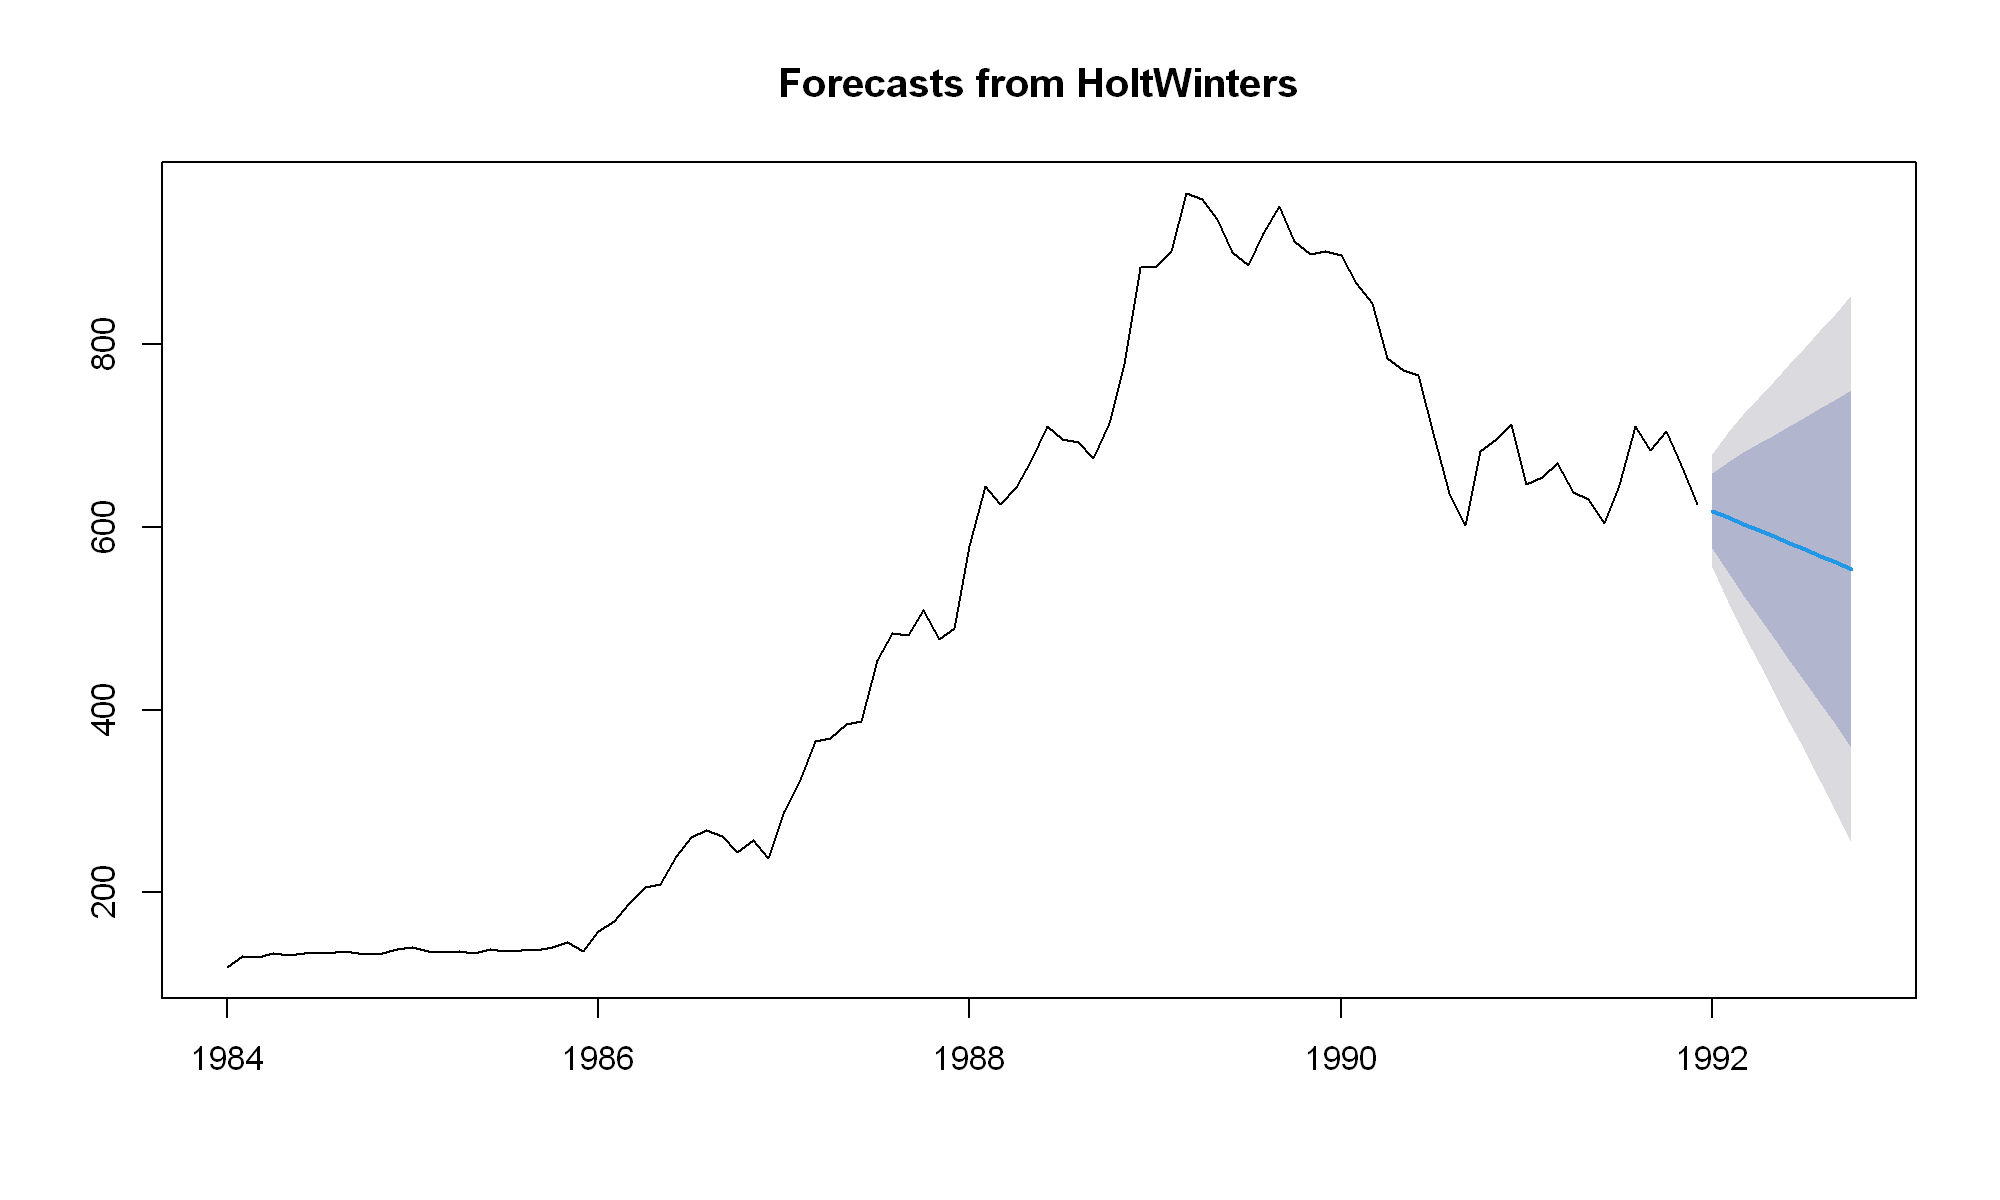

In [174]:
fit5_2=forecast(fit5, h=10)
plot(fit5_2)

#### 계절지수 평활법

In [175]:
souvenir=scan("http://robjhyndman.com/tsdldata/data/fancy.dat")
souvenirtimeseries=ts(souvenir, frequency=12, start=c(1987,1))

souvenirtimeseries

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
1987,1664.81,2397.53,2840.71,3547.29,3752.96,3714.74,4349.61,3566.34,5021.82,6423.48,7600.60,19756.21
1988,2499.81,5198.24,7225.14,4806.03,5900.88,4951.34,6179.12,4752.15,5496.43,5835.10,12600.08,28541.72
1989,4717.02,5702.63,9957.58,5304.78,6492.43,6630.80,7349.62,8176.62,8573.17,9690.50,15151.84,34061.01
1990,5921.10,5814.58,12421.25,6369.77,7609.12,7224.75,8121.22,7979.25,8093.06,8476.70,17914.66,30114.41
1991,4826.64,6470.23,9638.77,8821.17,8722.37,10209.48,11276.55,12552.22,11637.39,13606.89,21822.11,45060.69
1992,7615.03,9849.69,14558.40,11587.33,9332.56,13082.09,16732.78,19888.61,23933.38,25391.35,36024.80,80721.71
1993,10243.24,11266.88,21826.84,17357.33,15997.79,18601.53,26155.15,28586.52,30505.41,30821.33,46634.38,104660.67


* 시도표를 그려본 결과 추세성분과 계절성분이 관측되었고 이분산성도 관측되었음
* 따라서 로그변환 후 계절지수평활법을 적용

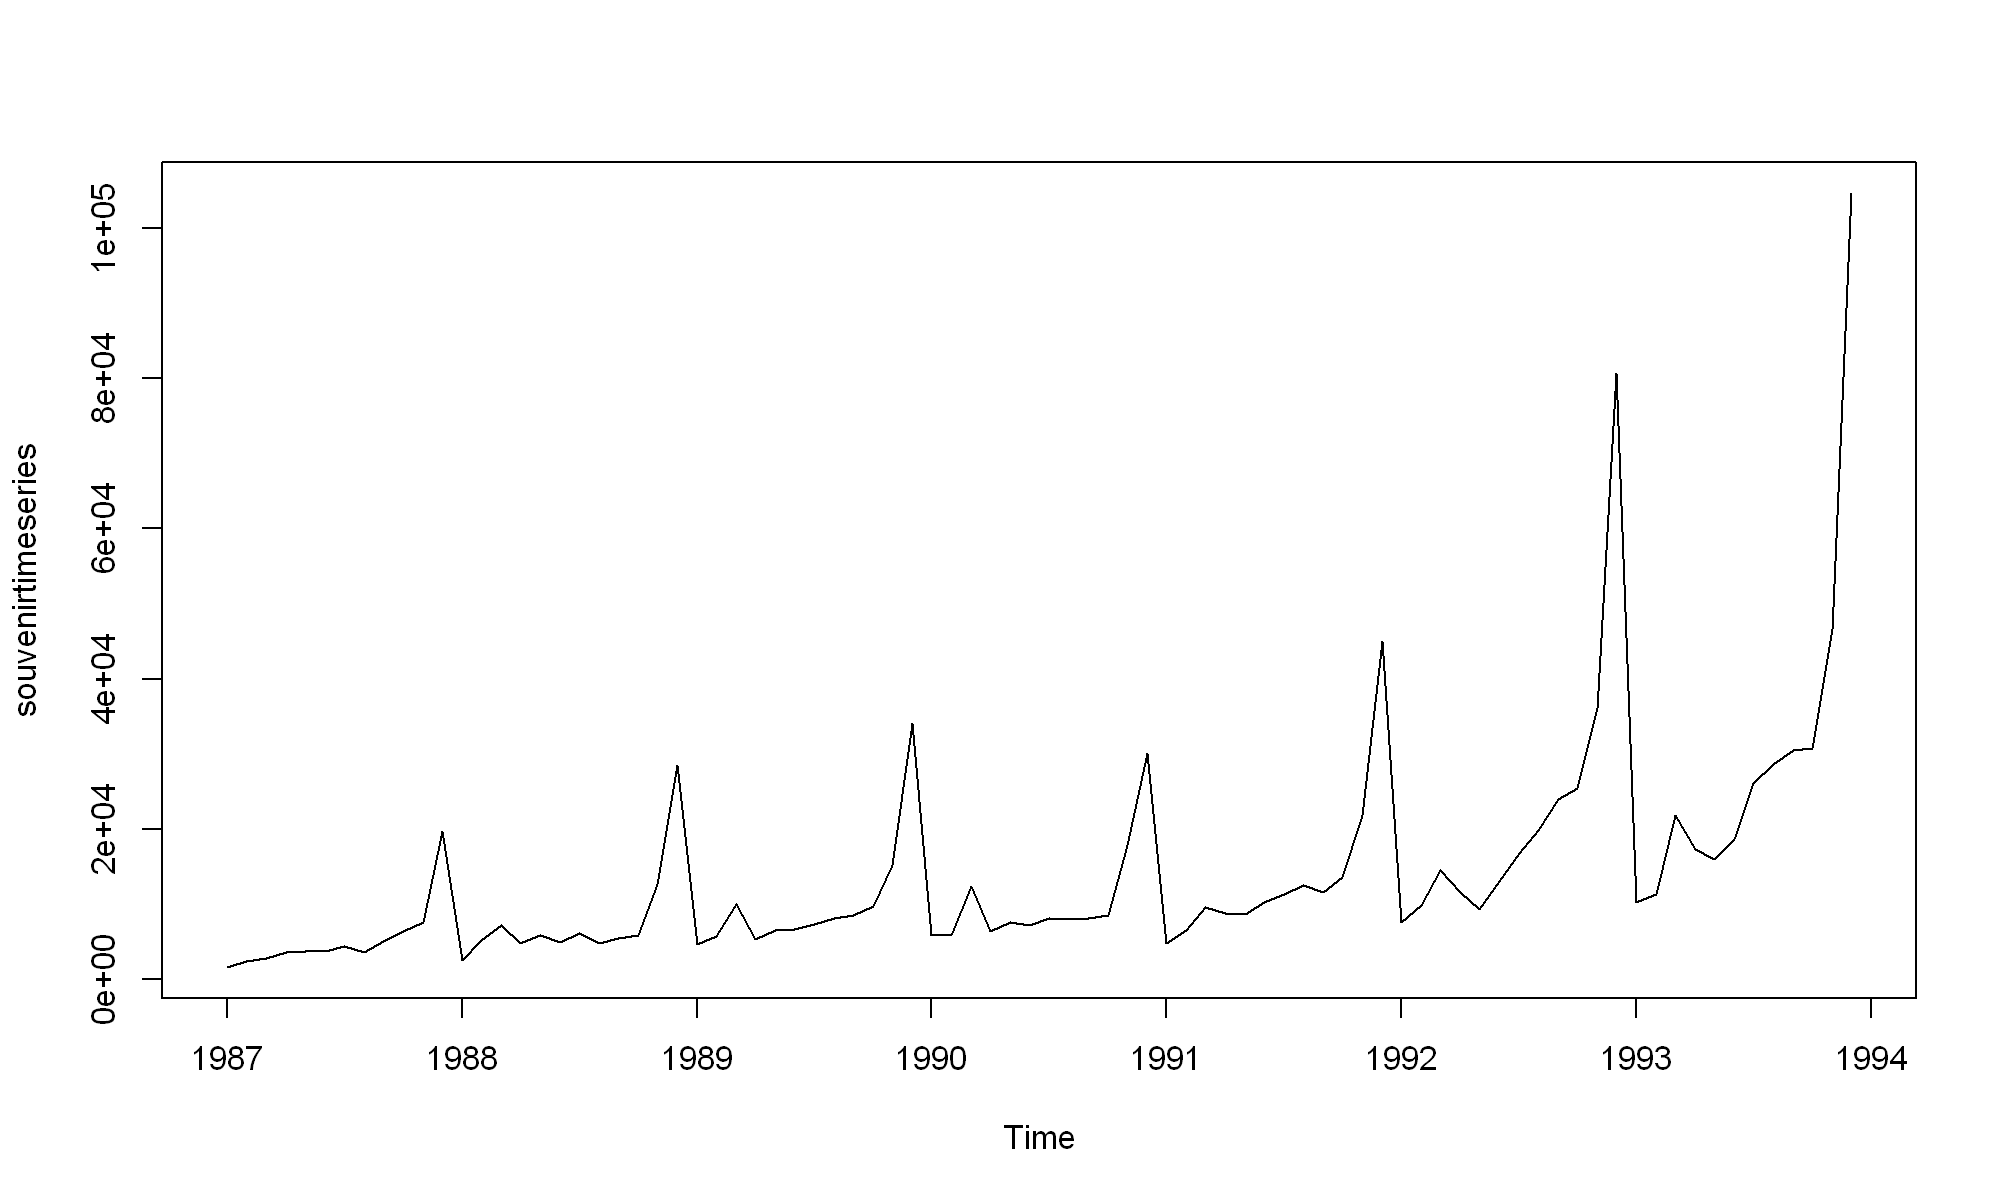

In [181]:
plot.ts(souvenirtimeseries) 

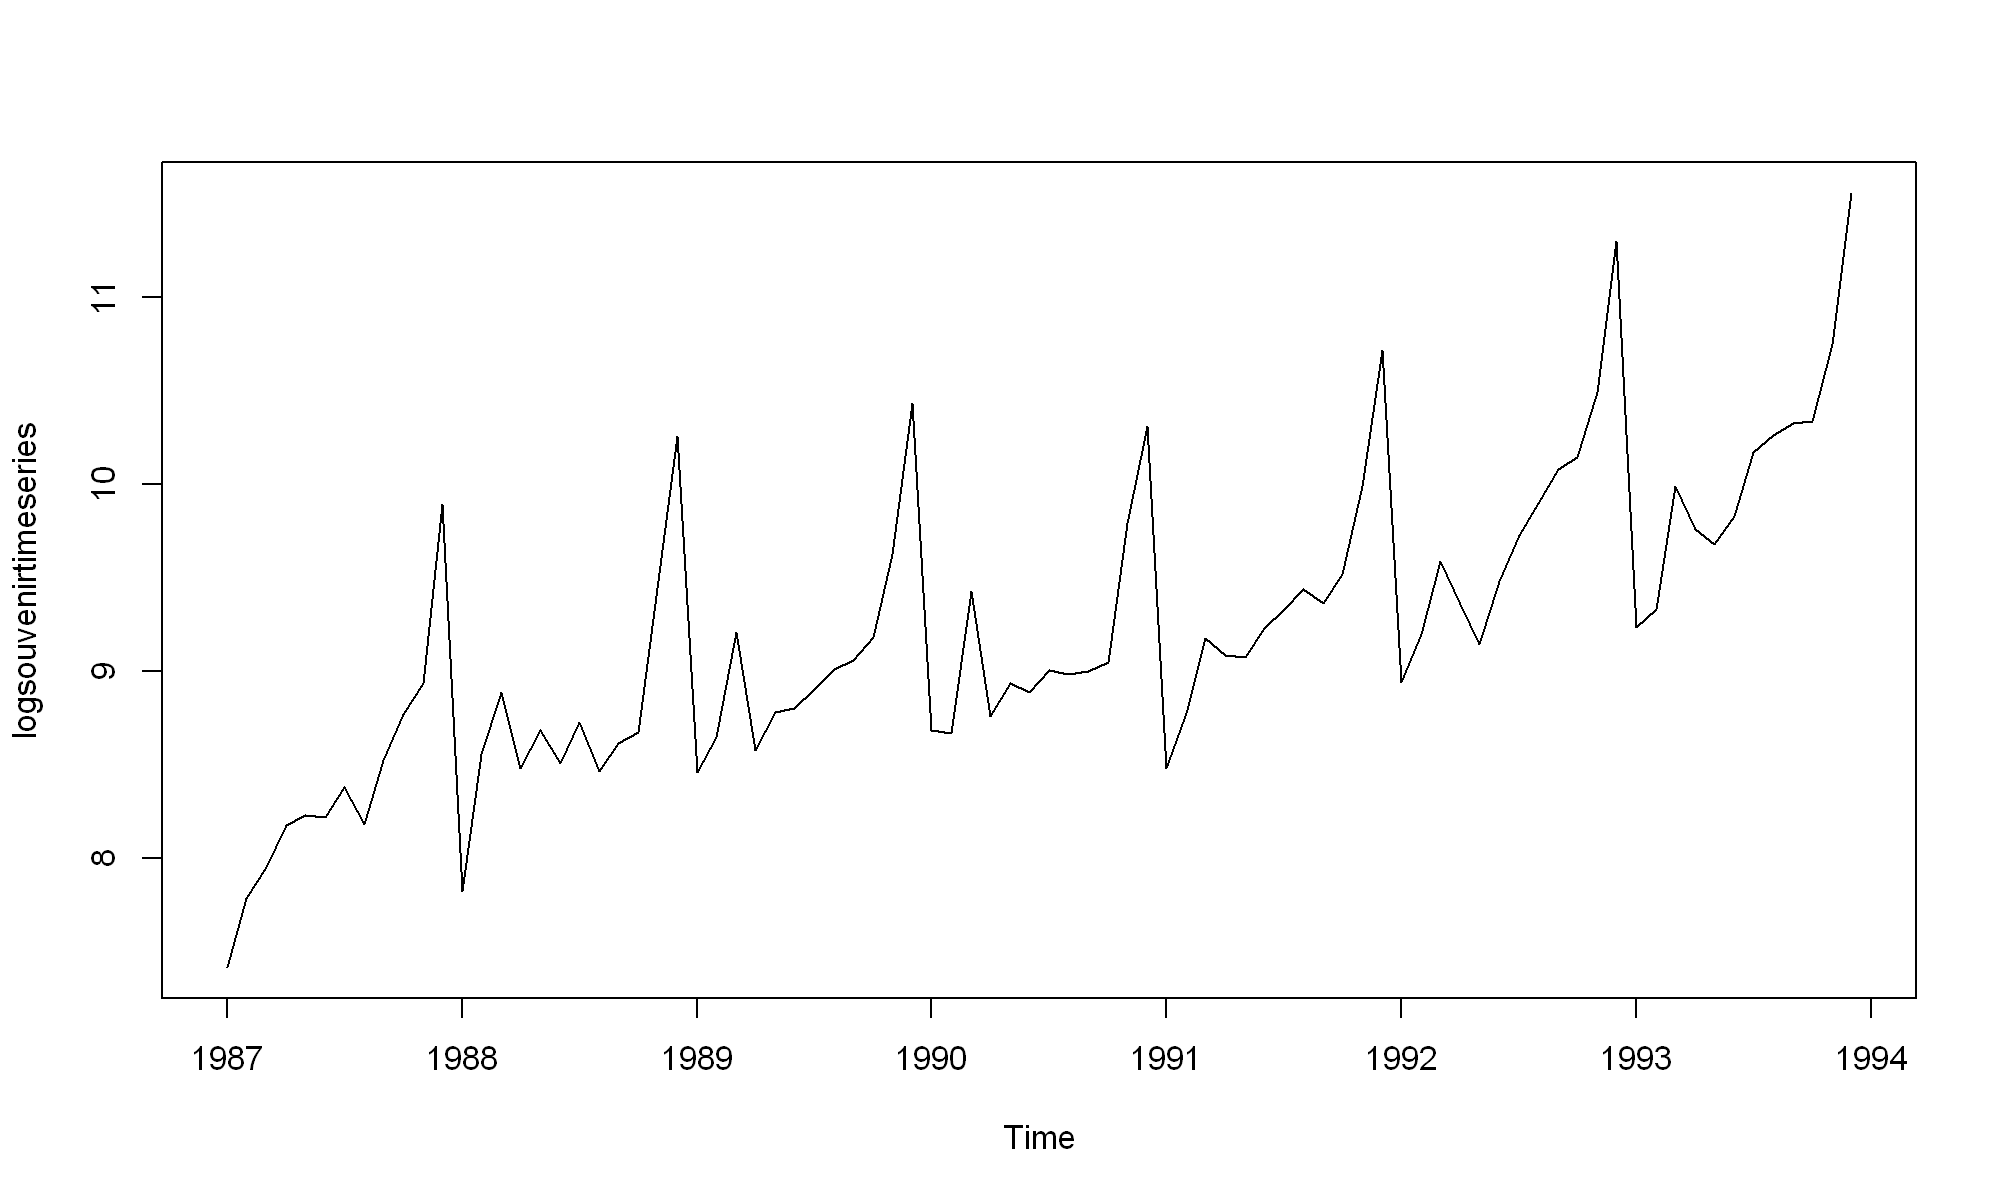

In [182]:
logsouvenirtimeseries <- log(souvenirtimeseries)
plot.ts(logsouvenirtimeseries)

In [183]:
souvenirforecasts <- HoltWinters(logsouvenirtimeseries)
souvenirforecasts

Holt-Winters exponential smoothing with trend and additive seasonal component.

Call:
HoltWinters(x = logsouvenirtimeseries)

Smoothing parameters:
 alpha: 0.413418
 beta : 0
 gamma: 0.9561275

Coefficients:
           [,1]
a   10.37661961
b    0.02996319
s1  -0.80952063
s2  -0.60576477
s3   0.01103238
s4  -0.24160551
s5  -0.35933517
s6  -0.18076683
s7   0.07788605
s8   0.10147055
s9   0.09649353
s10  0.05197826
s11  0.41793637
s12  1.18088423

* $s_1,\dots s_{12}$는 계절성분의 평활상수 이다.

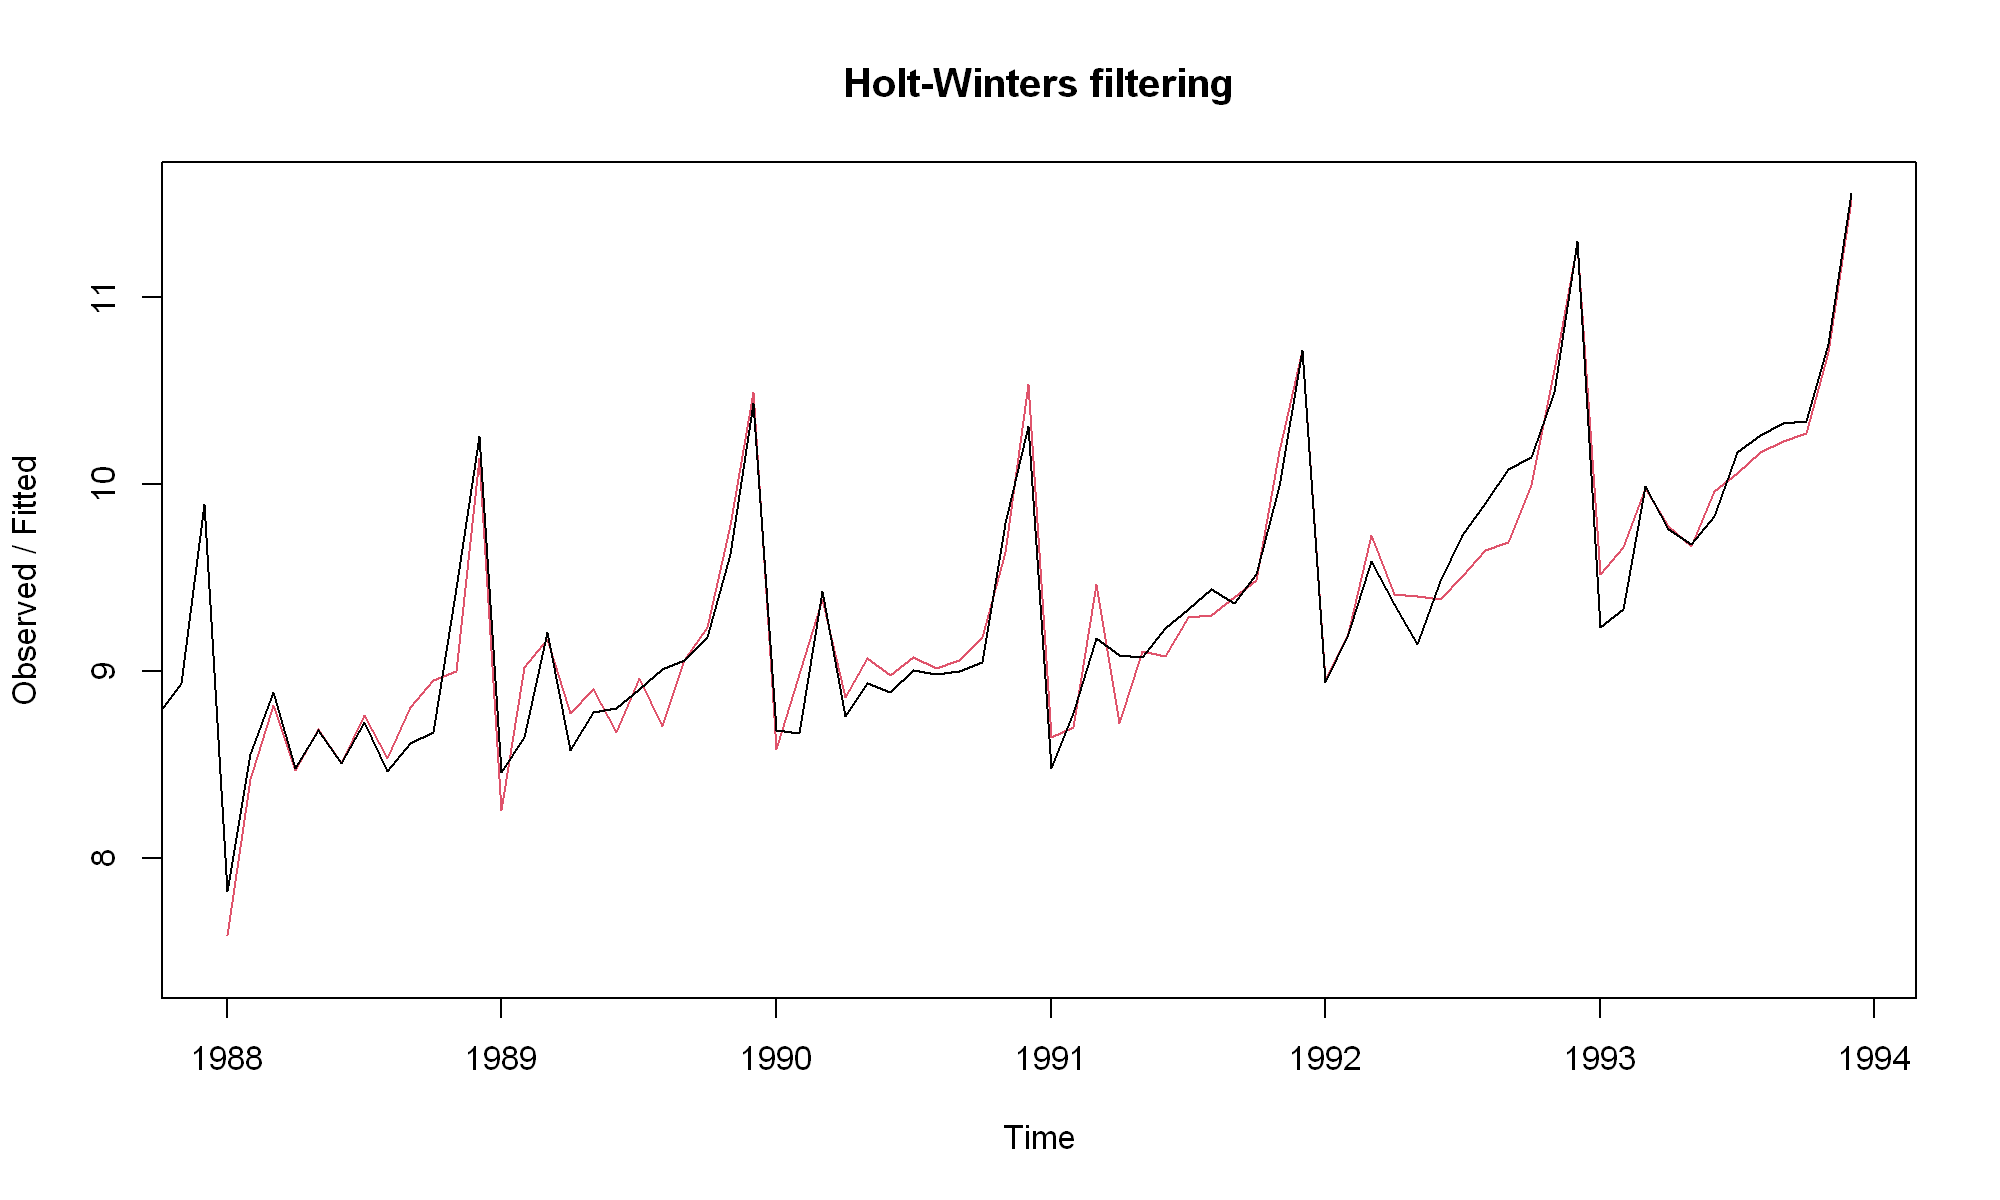

In [184]:
plot(souvenirforecasts)

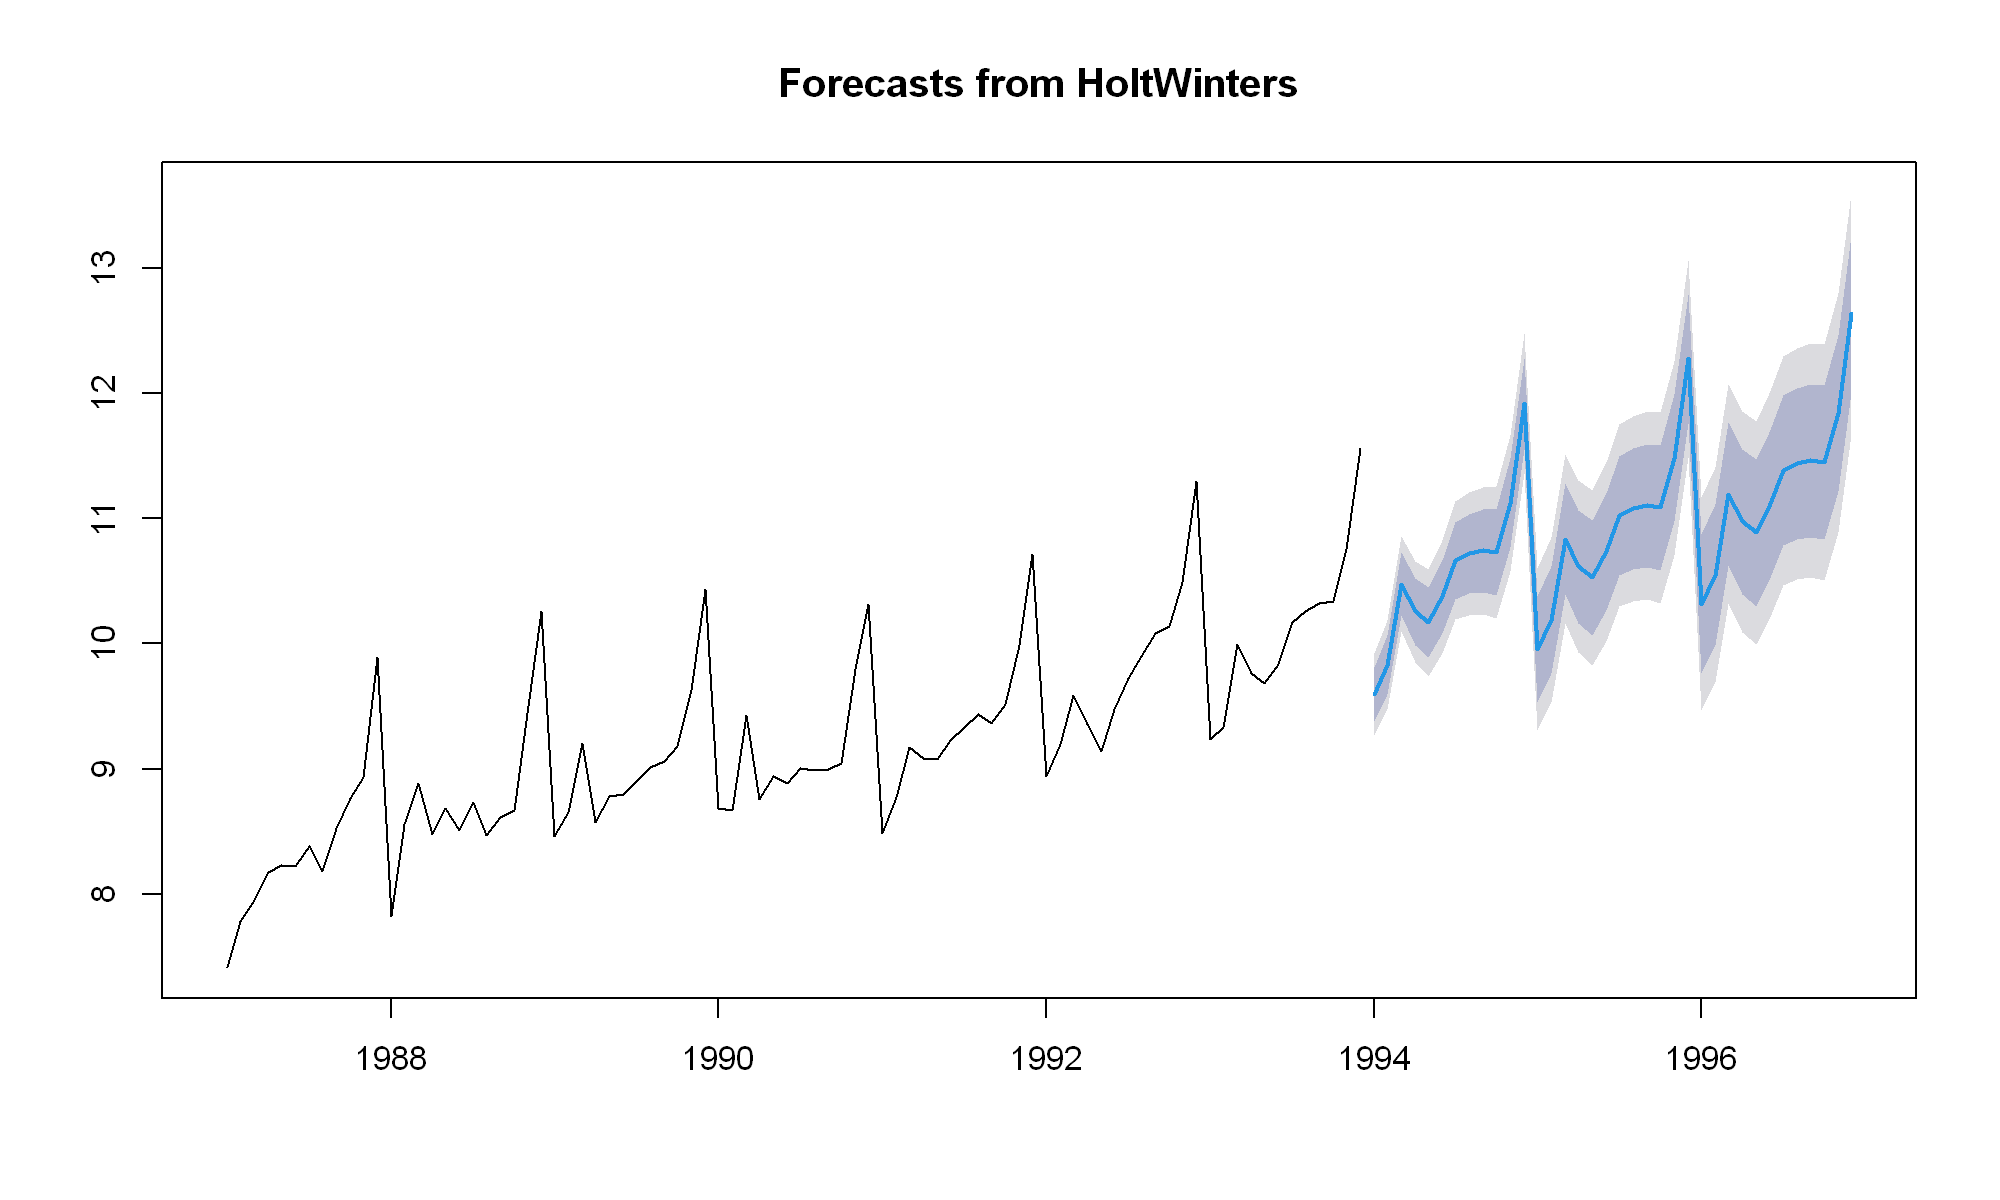

In [185]:
souvenirforecasts2 <- forecast(souvenirforecasts, h=36)
plot(souvenirforecasts2)

In [186]:
z <- scan("koreapass.txt")
pass <- ts(z, start=c(1981,1), frequency=12) 

pass

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
1981,112696,103070,122800,142496,150064,136128,143033,158223,138626,148761,140539,117693
1982,133390,117378,136309,149476,157107,147160,153156,164352,139584,165633,147054,129396
1983,137638,132128,141178,154545,169127,156056,167749,200228,154371,169199,144594,126590
1984,132362,131123,146756,160249,175131,169655,178023,193169,171479,186443,172378,150952
1985,156240,144008,177073,186693,187296,190206,196132,218560,183651,189003,177325,159672
1986,163846,158125,193446,193743,205408,210435,219326,249612,205442,234143,216913,185724
1987,195346,183669,215524,224547,238201,238304,249401,274307,224528,229684,217576,182898
1988,199252,193565,230360,242953,274802,271599,293280,328824,236158,305662,312164,267947
1989,309654,279943,324963,319020,352602,356546,376214,398079,355931,363955,339887,308085


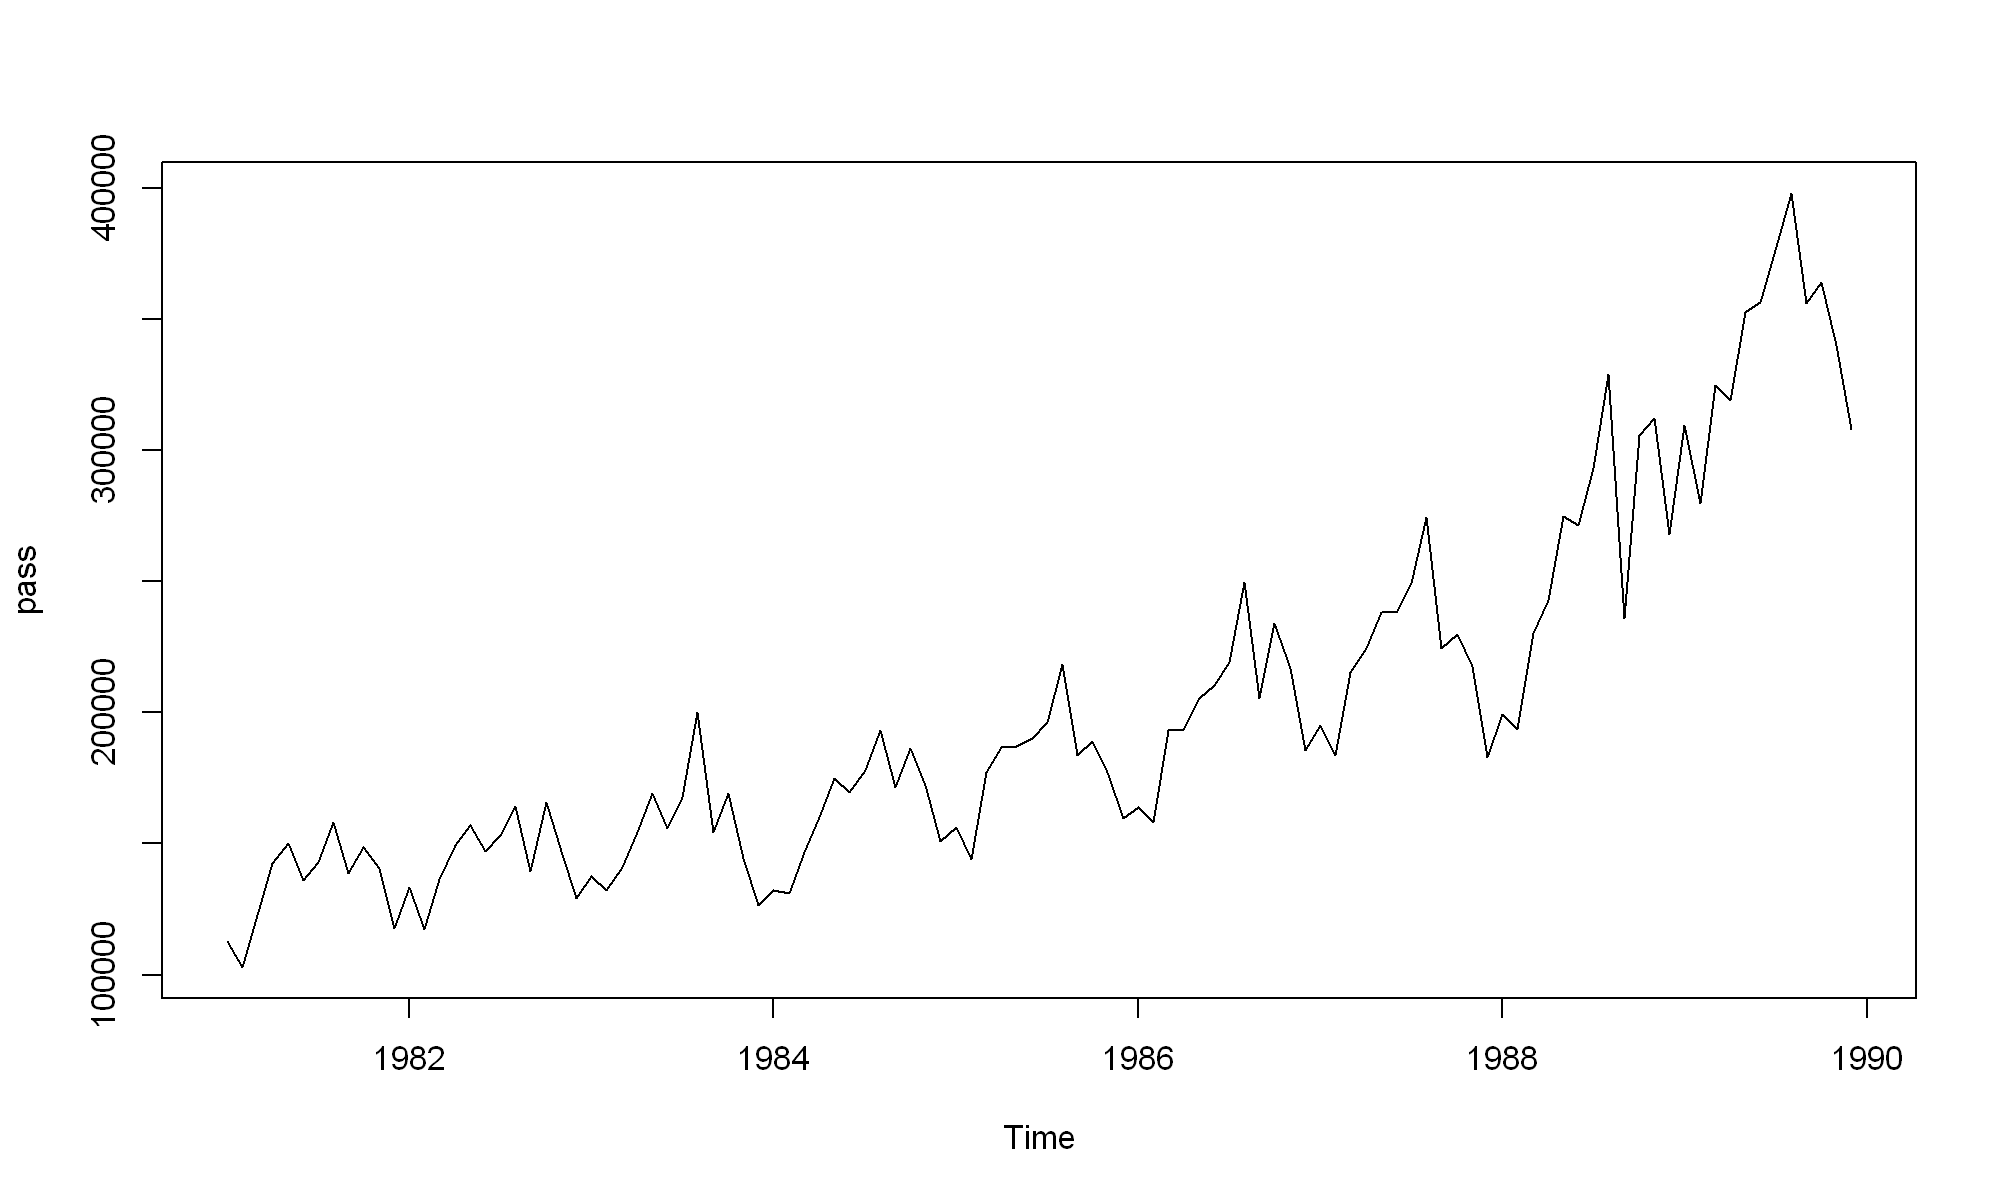

In [187]:
plot.ts(pass)

* 가법모형 적용

In [188]:
fit6 = HoltWinters(pass, seasonal="additive") 
fit6

Holt-Winters exponential smoothing with trend and additive seasonal component.

Call:
HoltWinters(x = pass, seasonal = "additive")

Smoothing parameters:
 alpha: 0.4810767
 beta : 0.0383379
 gamma: 0.7345988

Coefficients:
          [,1]
a   347794.753
b     3363.251
s1  -12186.666
s2  -33643.322
s3    4855.643
s4    5000.713
s5   29085.909
s6   22953.006
s7   32200.195
s8   49687.643
s9  -11655.430
s10  10218.813
s11  -4226.391
s12 -38683.394

* 잔차 그림

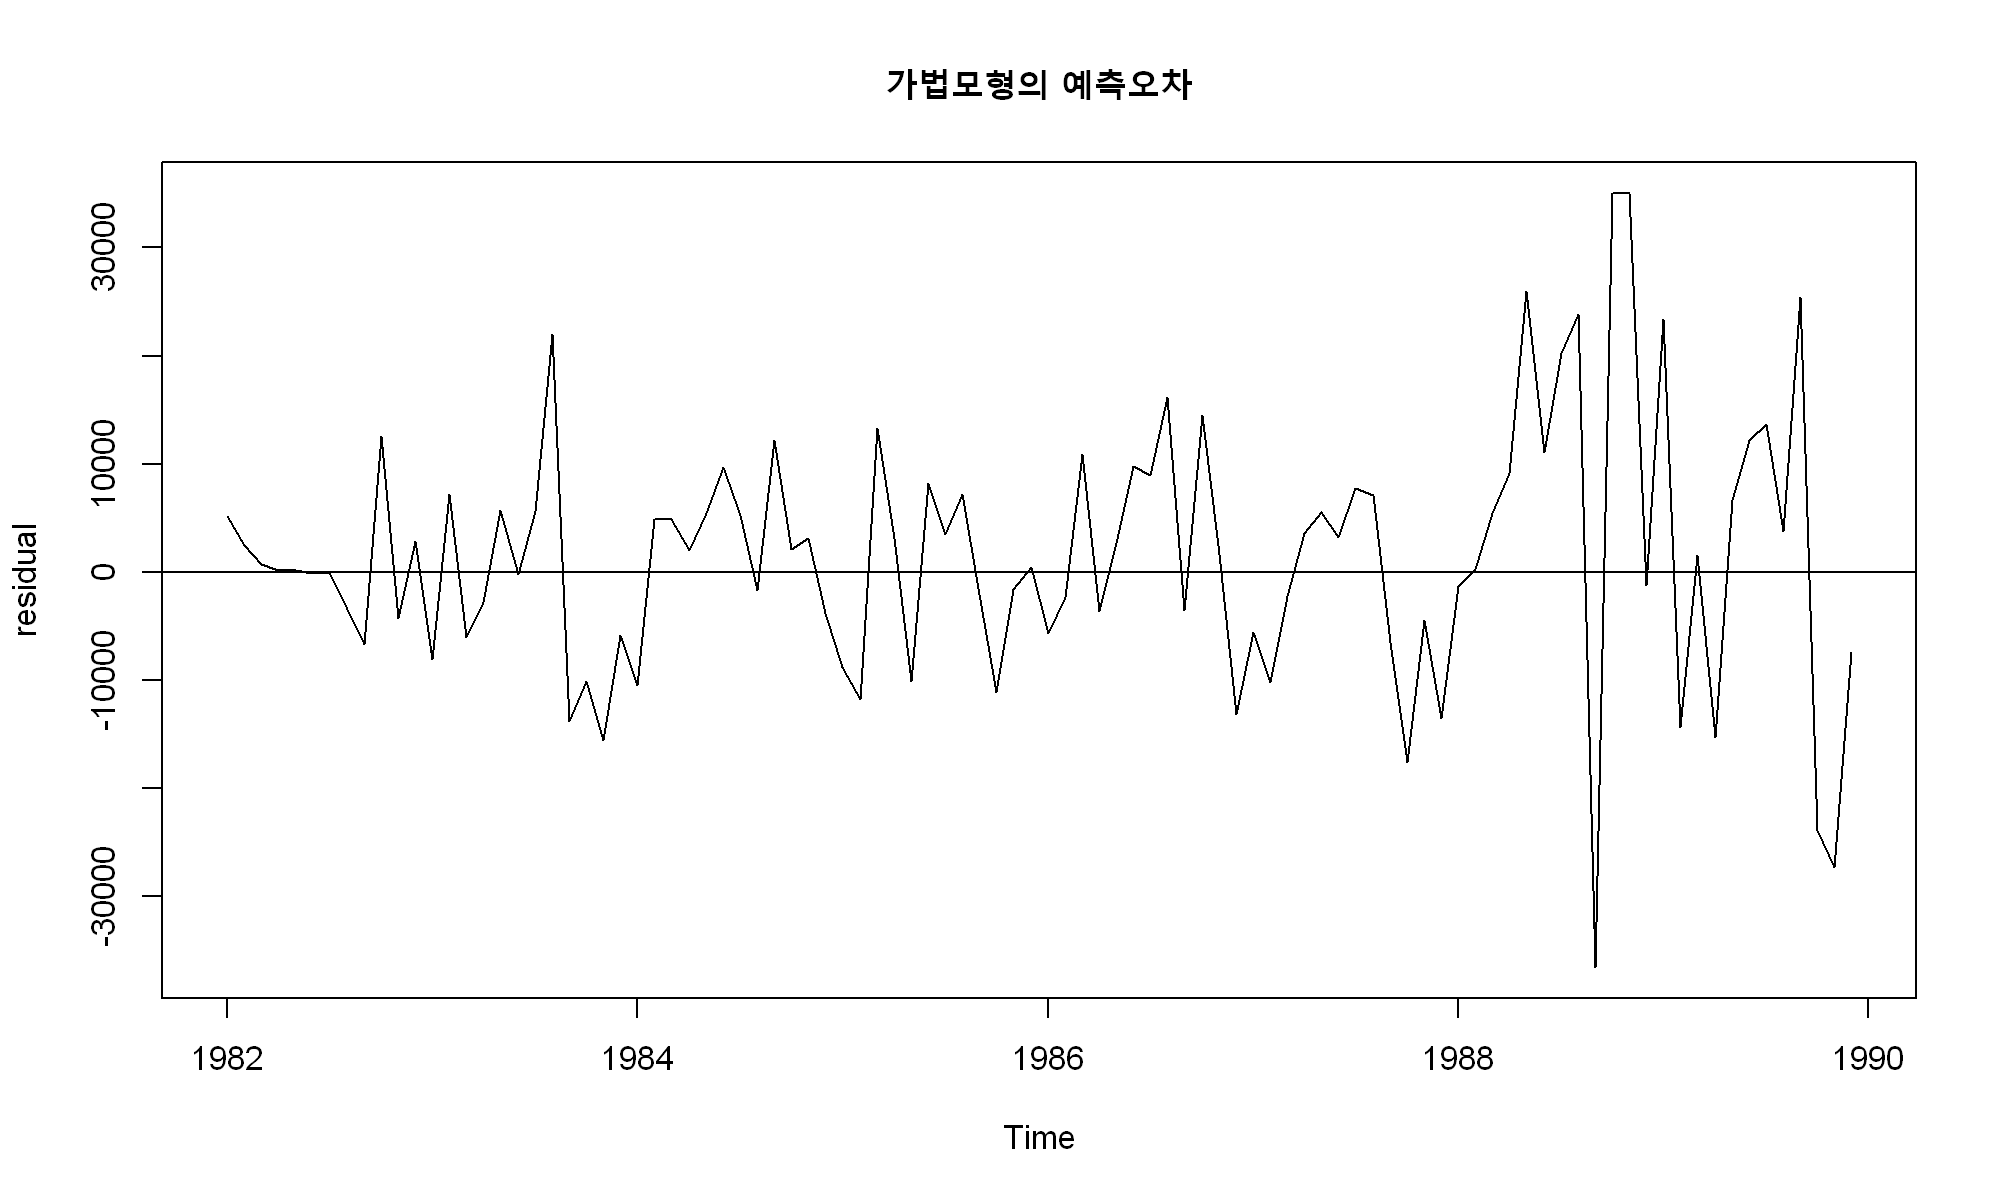

In [189]:
ts.plot(resid(fit6), ylab="residual", 
        main="가법모형의 예측오차"); abline(h=0)

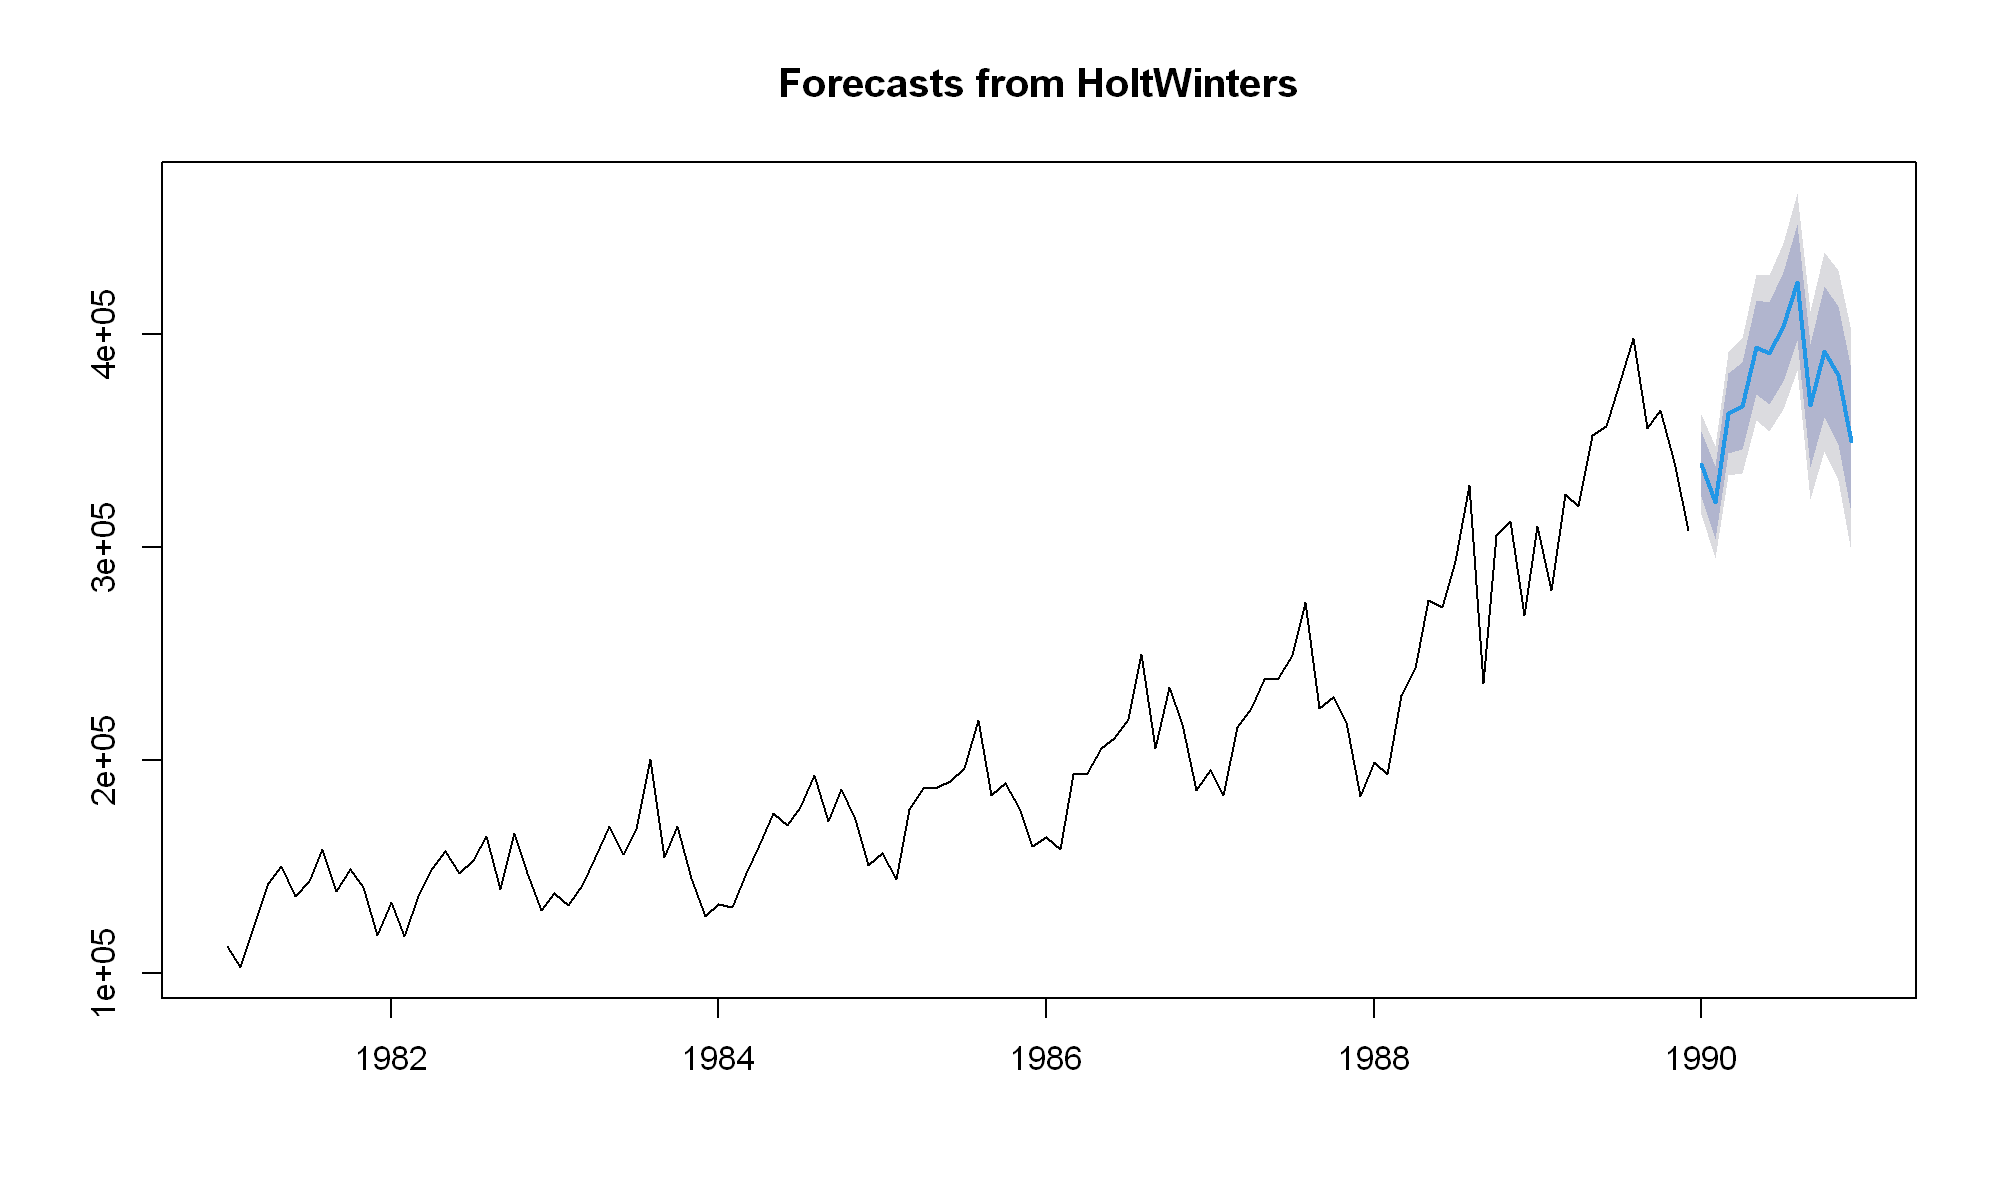

In [192]:
fit6_2=forecast(fit6, h=12)
plot(fit6_2)

* 승법모형 적용

In [193]:
fit7 =  HoltWinters(pass, seasonal="multiplicative") 
fit7

Holt-Winters exponential smoothing with trend and multiplicative seasonal component.

Call:
HoltWinters(x = pass, seasonal = "multiplicative")

Smoothing parameters:
 alpha: 0.5623303
 beta : 0.03452066
 gamma: 0.3506508

Coefficients:
            [,1]
a   3.560417e+05
b   3.517556e+03
s1  9.199511e-01
s2  8.489190e-01
s3  9.796617e-01
s4  1.016528e+00
s5  1.095078e+00
s6  1.060795e+00
s7  1.089621e+00
s8  1.178393e+00
s9  9.706046e-01
s10 1.065056e+00
s11 9.983082e-01
s12 8.552947e-01

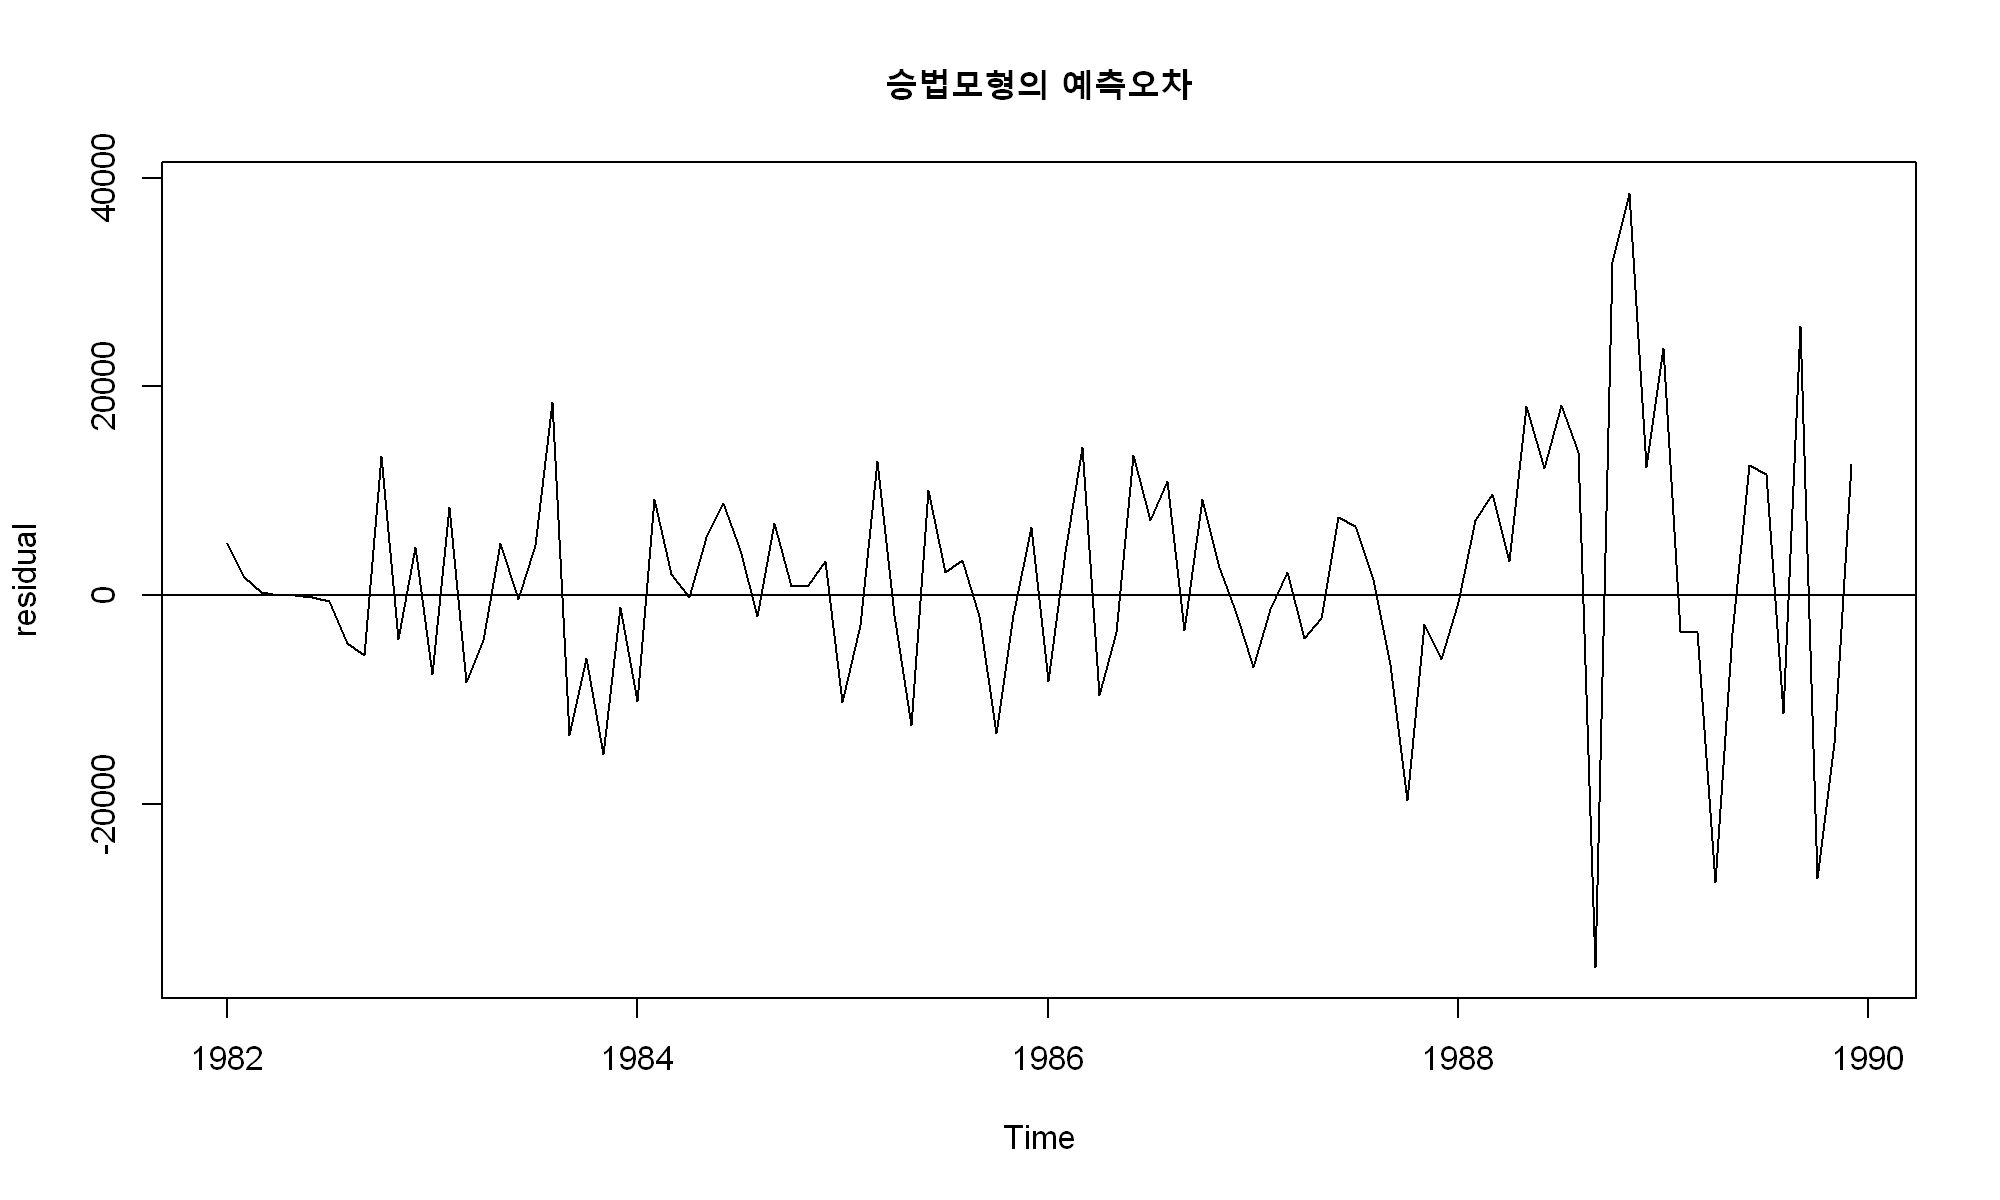

In [194]:
ts.plot(resid(fit7), ylab="residual", 
        main="승법모형의 예측오차"); abline(h=0)

In [197]:
fit6$SSE; fit7$SSE

[1] 13764737658

[1] 12633778874

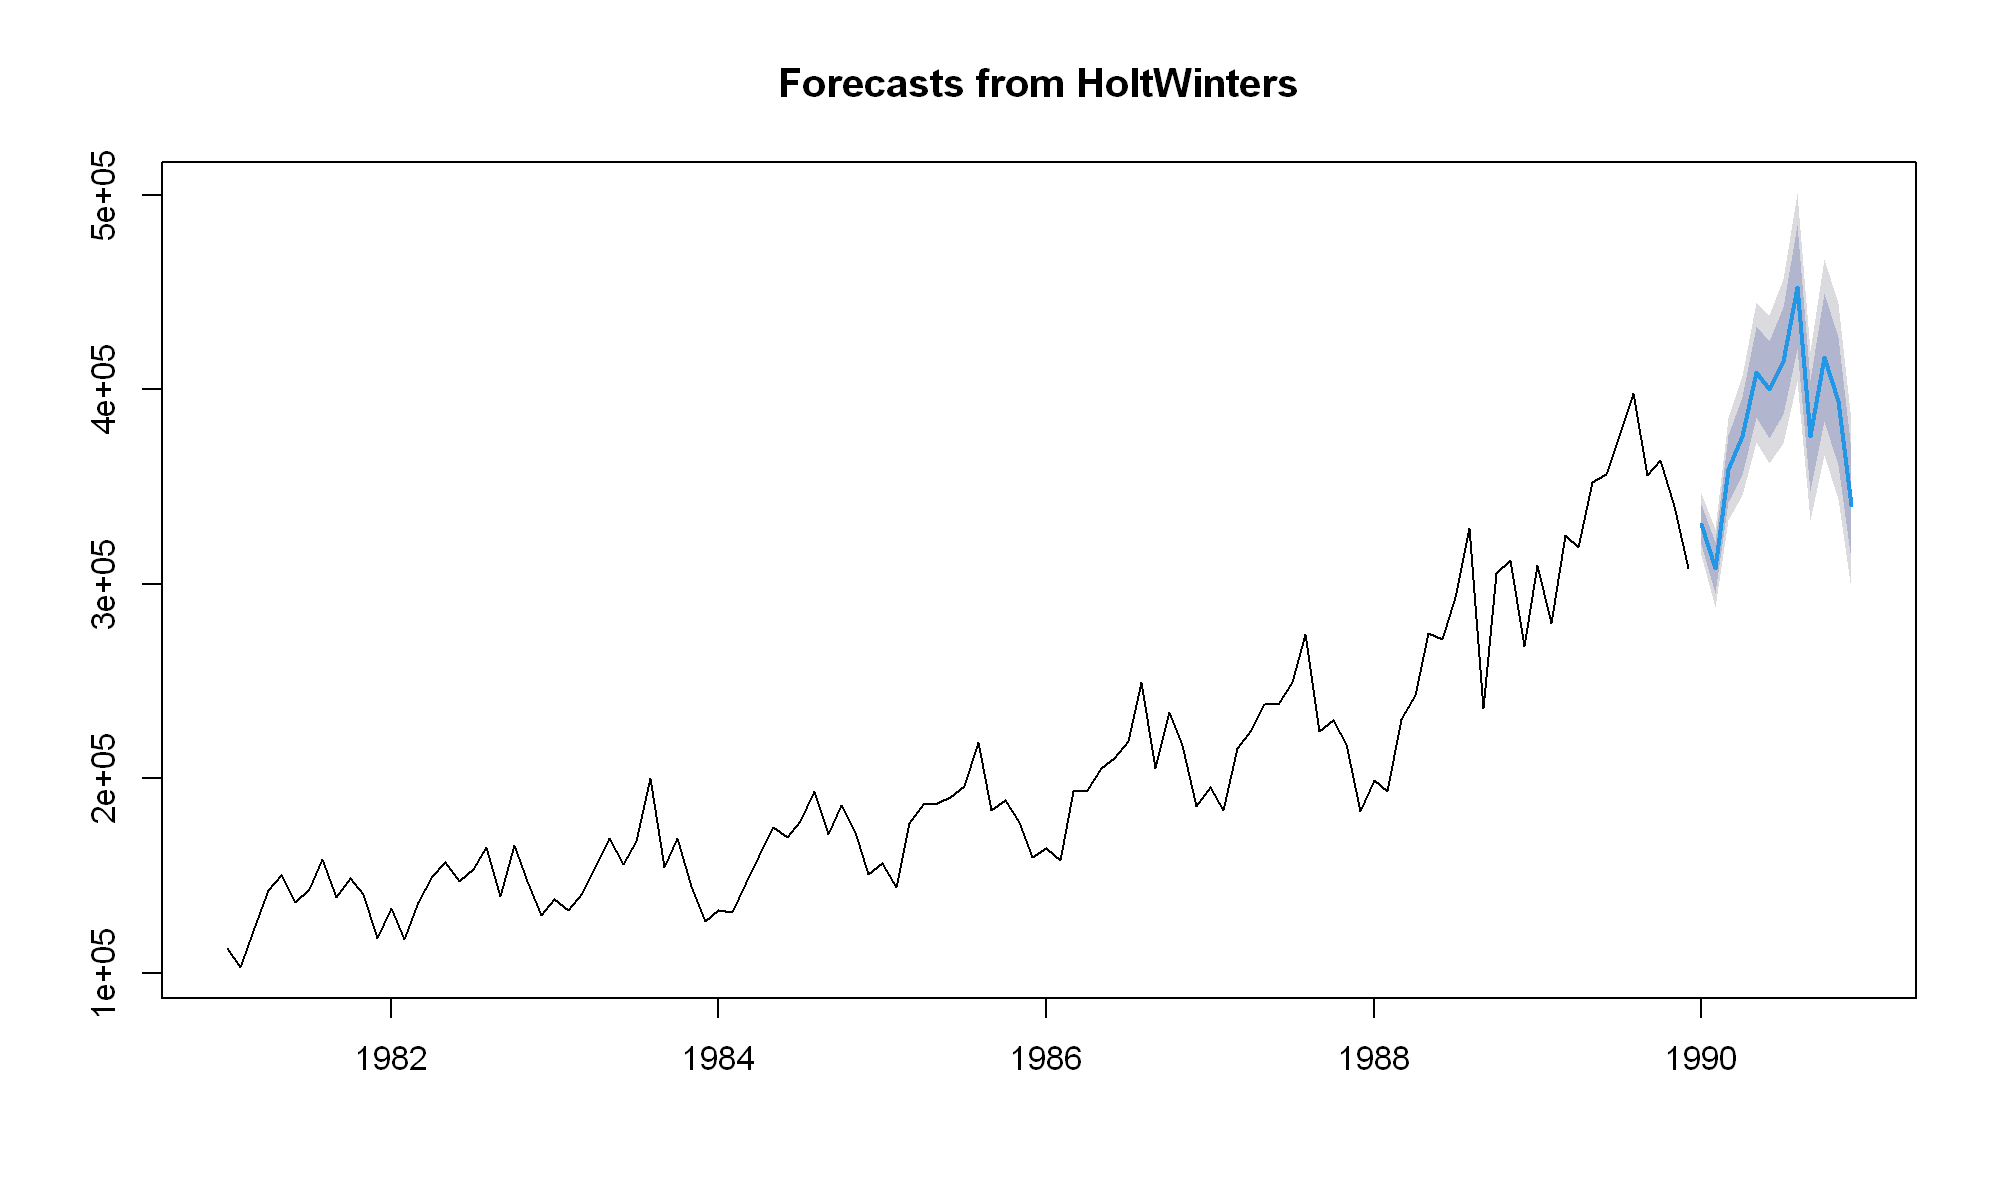

In [198]:
fit7_2=forecast(fit7, h=12)
plot(fit7_2)

***

# 4. 시계열 모형

## 가. 자기회귀 모형 (AR 모형, Autoregressive Model)

* $p$ 시점 전의 자료가 현재 자료에 영향을 주는 모형

$$Z_t = \phi_1 + Z_{t-1} + \dots \phi_pZ_{t-p} + \alpha_t$$

* $\alpha_t \sim WN(0,\sigma^2)$ 로 대표적인 정상시계열이다.

* 자기상관함수(ACF)는 지수적으로 빠르게 감소, 부분자기상관함수(PACF)는 $p+1$시점에서 절단점을 가진다. 

## 나.  이동평균 모형 (MA 모형, Moving Average Model) 

$$ Z_t =\alpha_t - \theta_1\alpha_{t-1}-\theta_2\alpha_{t-2}\dots -\theta_p \alpha_{t-p}$$

* 유한개 개수의 백색잡음의 결합이므로 언제나 정상성을 만족한다.

* 부분자기상관함수(PACF)는 지수적으로 빠르게 감소, 자기상관함수(ACF)는 $p+1$시점에서 절단점을 가진다. 

## 다. 자기회귀누적이동평균 모형 (ARIMA (p,d,q) 모형 , Autoregressive integrated moving average model)

* $p \to AR, \, q\to MA$ 와 대응된다.

* $ARIMA$ 모형은 비정상시계열 모형이다.

* $Z_t$가 비정상 시계열일 때 $d$번 차분한 시계열이 $ARMA(p,q)$ 이면 $Z_t$는  $ARIMA(p,d,q)$ 모형을 갖는다고 한다.

* $ARIMA(0,1,1)$ 일 경우 1차분 후 $MA(1)$을 이용

* $ARIMA(1,1,0)$ 일 경우 1차분 후 $AR(1)$을 이용

## Practice with R

* 데이터 로드 후 시도표
* 딱히 이렇다할 추세나 계절 성분은 보이진 않는다.

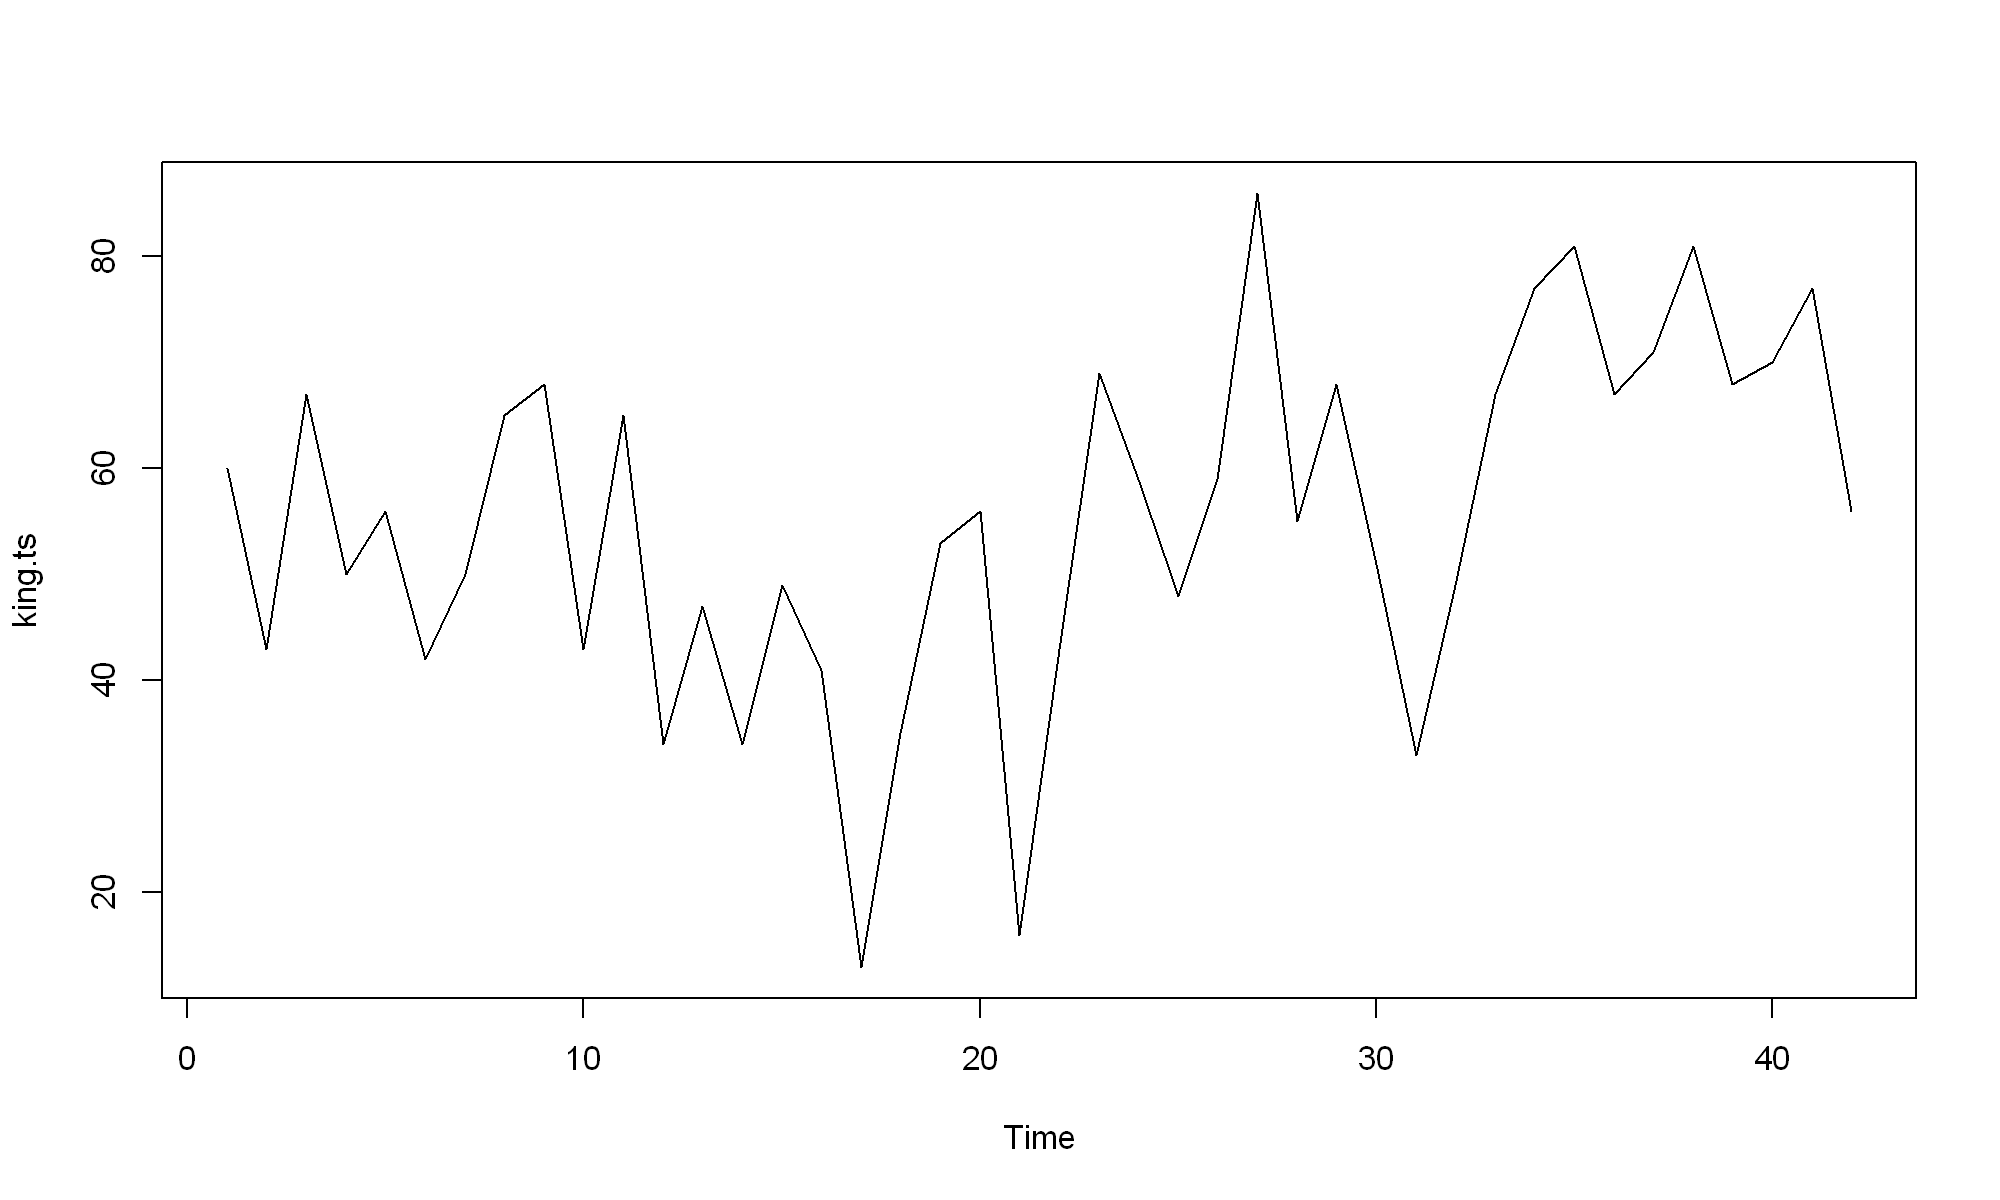

In [12]:
king <- scan("http://robjhyndman.com/tsdldata/misc/kings.dat",skip=3)
king.ts <- ts(king) ## 1년 주기로 데이터를 생성
plot(king.ts)

* acf값과 pacf값을 확인

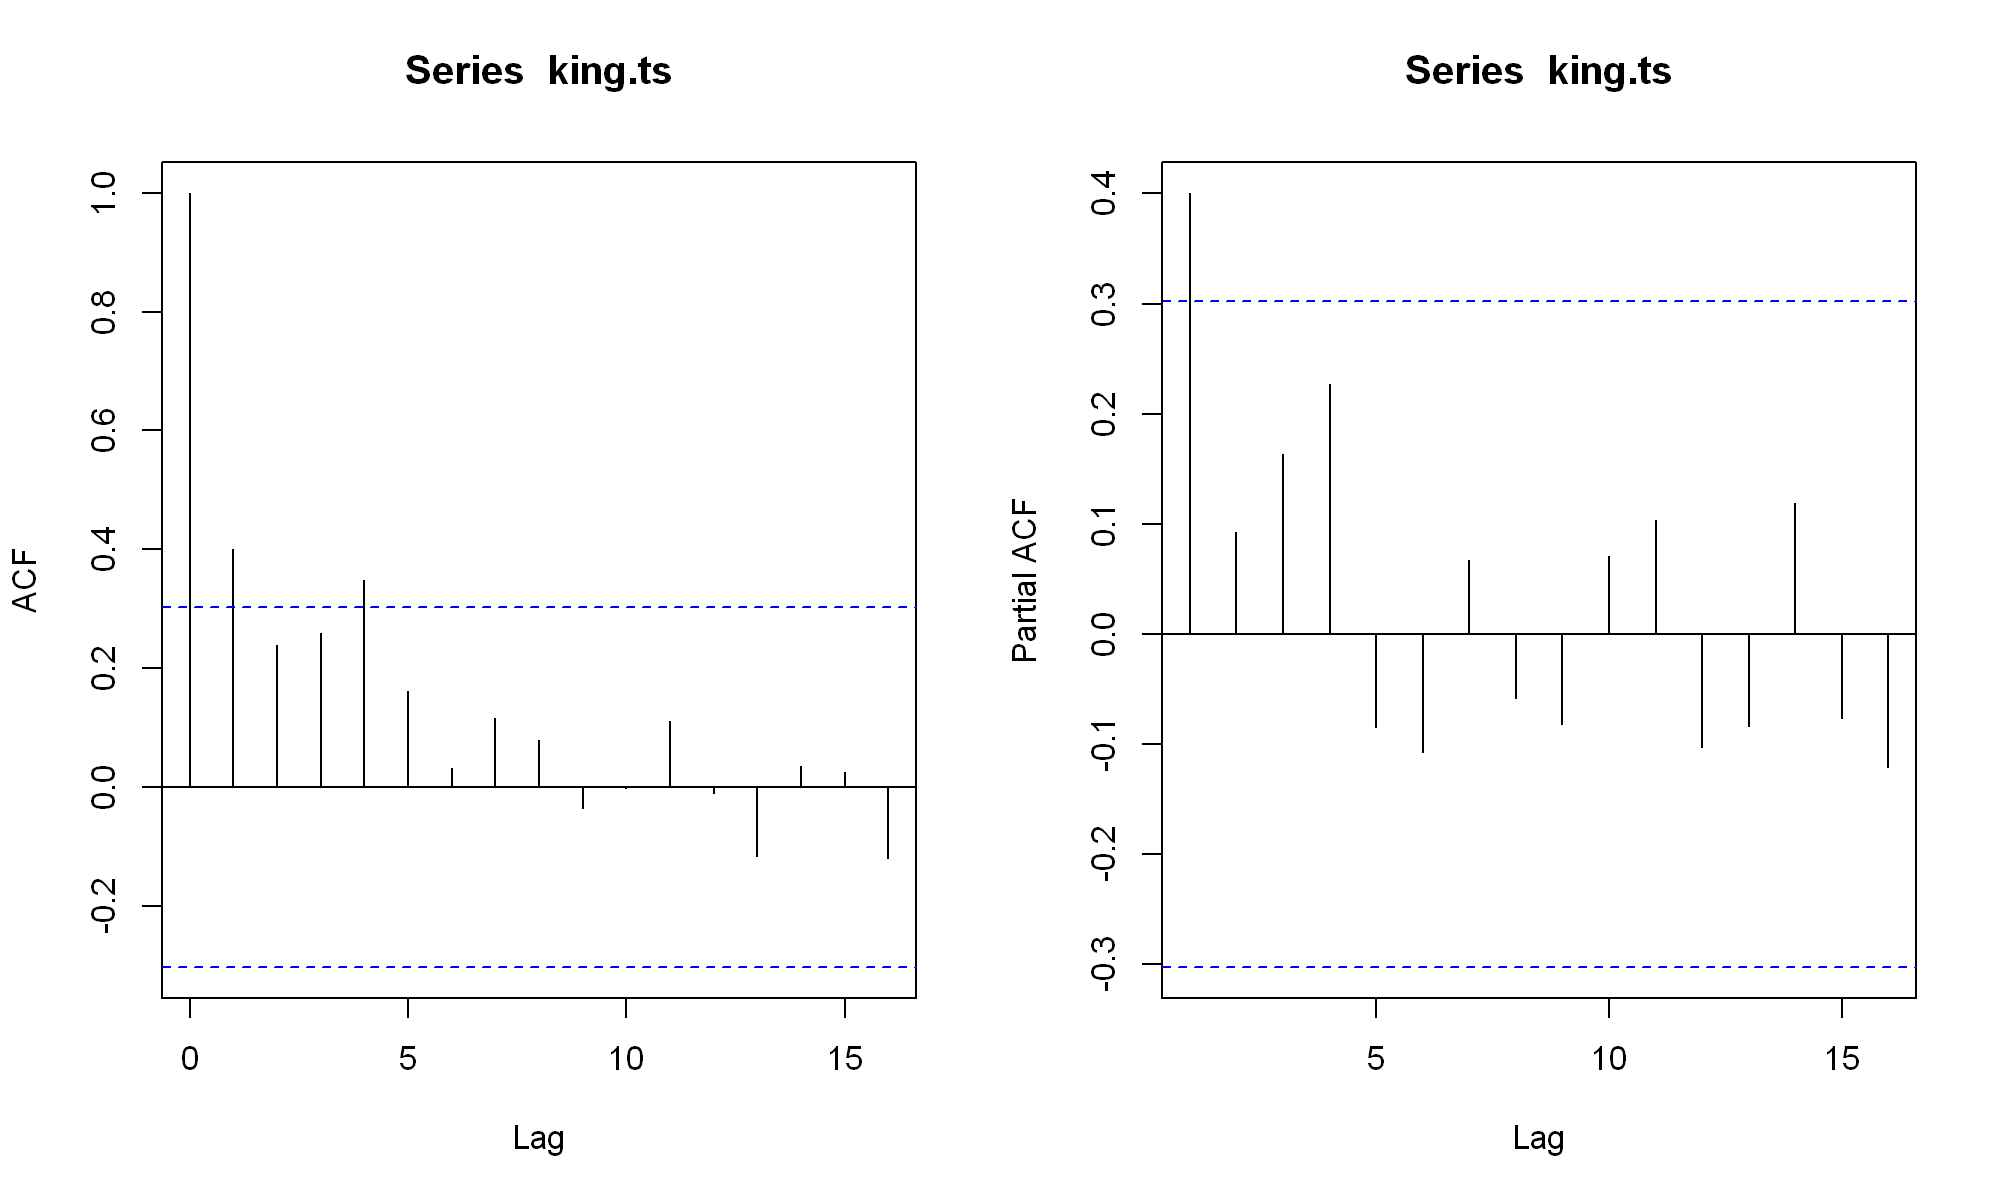

In [212]:
par(mfrow=c(1,2))
acf(king.ts); pacf(king.ts)

* 또한 PACF 도표를 그려 확인한 결과 $lag\, 2$에서 절단 점을 가지므로 $AR(1)$ 모형을 1차적으로 고려해볼 수 있다.


* 그러나 실제 ACF가 유의한지 아닌 지 검증을 수행하여 차분여부를 결정하자

In [14]:
library(fUnitRoots)

In [16]:
adfTest(king.ts,lags=0, type="c") ## type="c" 는 적합할 모형에 상수항(절편)이 존재하는 경우
                                  ## type= "nc"는 적합할 모형에 상수항이 0인 경우
                                  ## type= "ct" 적합할 모형에 추세와 절편이 존재하는 경우
adfTest(king.ts,lags=1, type="c")
adfTest(king.ts,lags=2, type="c")

Warning message in adfTest(king.ts, lags = 0, type = "c"):
"p-value smaller than printed p-value"



Title:
 Augmented Dickey-Fuller Test

Test Results:
  PARAMETER:
    Lag Order: 0
  STATISTIC:
    Dickey-Fuller: -4.0902
  P VALUE:
    0.01 

Description:
 Fri Nov 26 15:50:29 2021 by user: lee



Title:
 Augmented Dickey-Fuller Test

Test Results:
  PARAMETER:
    Lag Order: 1
  STATISTIC:
    Dickey-Fuller: -3.0002
  P VALUE:
    0.04631 

Description:
 Fri Nov 26 15:50:29 2021 by user: lee



Title:
 Augmented Dickey-Fuller Test

Test Results:
  PARAMETER:
    Lag Order: 2
  STATISTIC:
    Dickey-Fuller: -2.1483
  P VALUE:
    0.2665 

Description:
 Fri Nov 26 15:50:29 2021 by user: lee


* 시차 0,1,2에서 검정 결과 차분을 1회할 경우 정상성을 만족할 것으로 보인다.

* 검정결과만 보면 굳이 차분을 안해도 될 것 같긴하다.

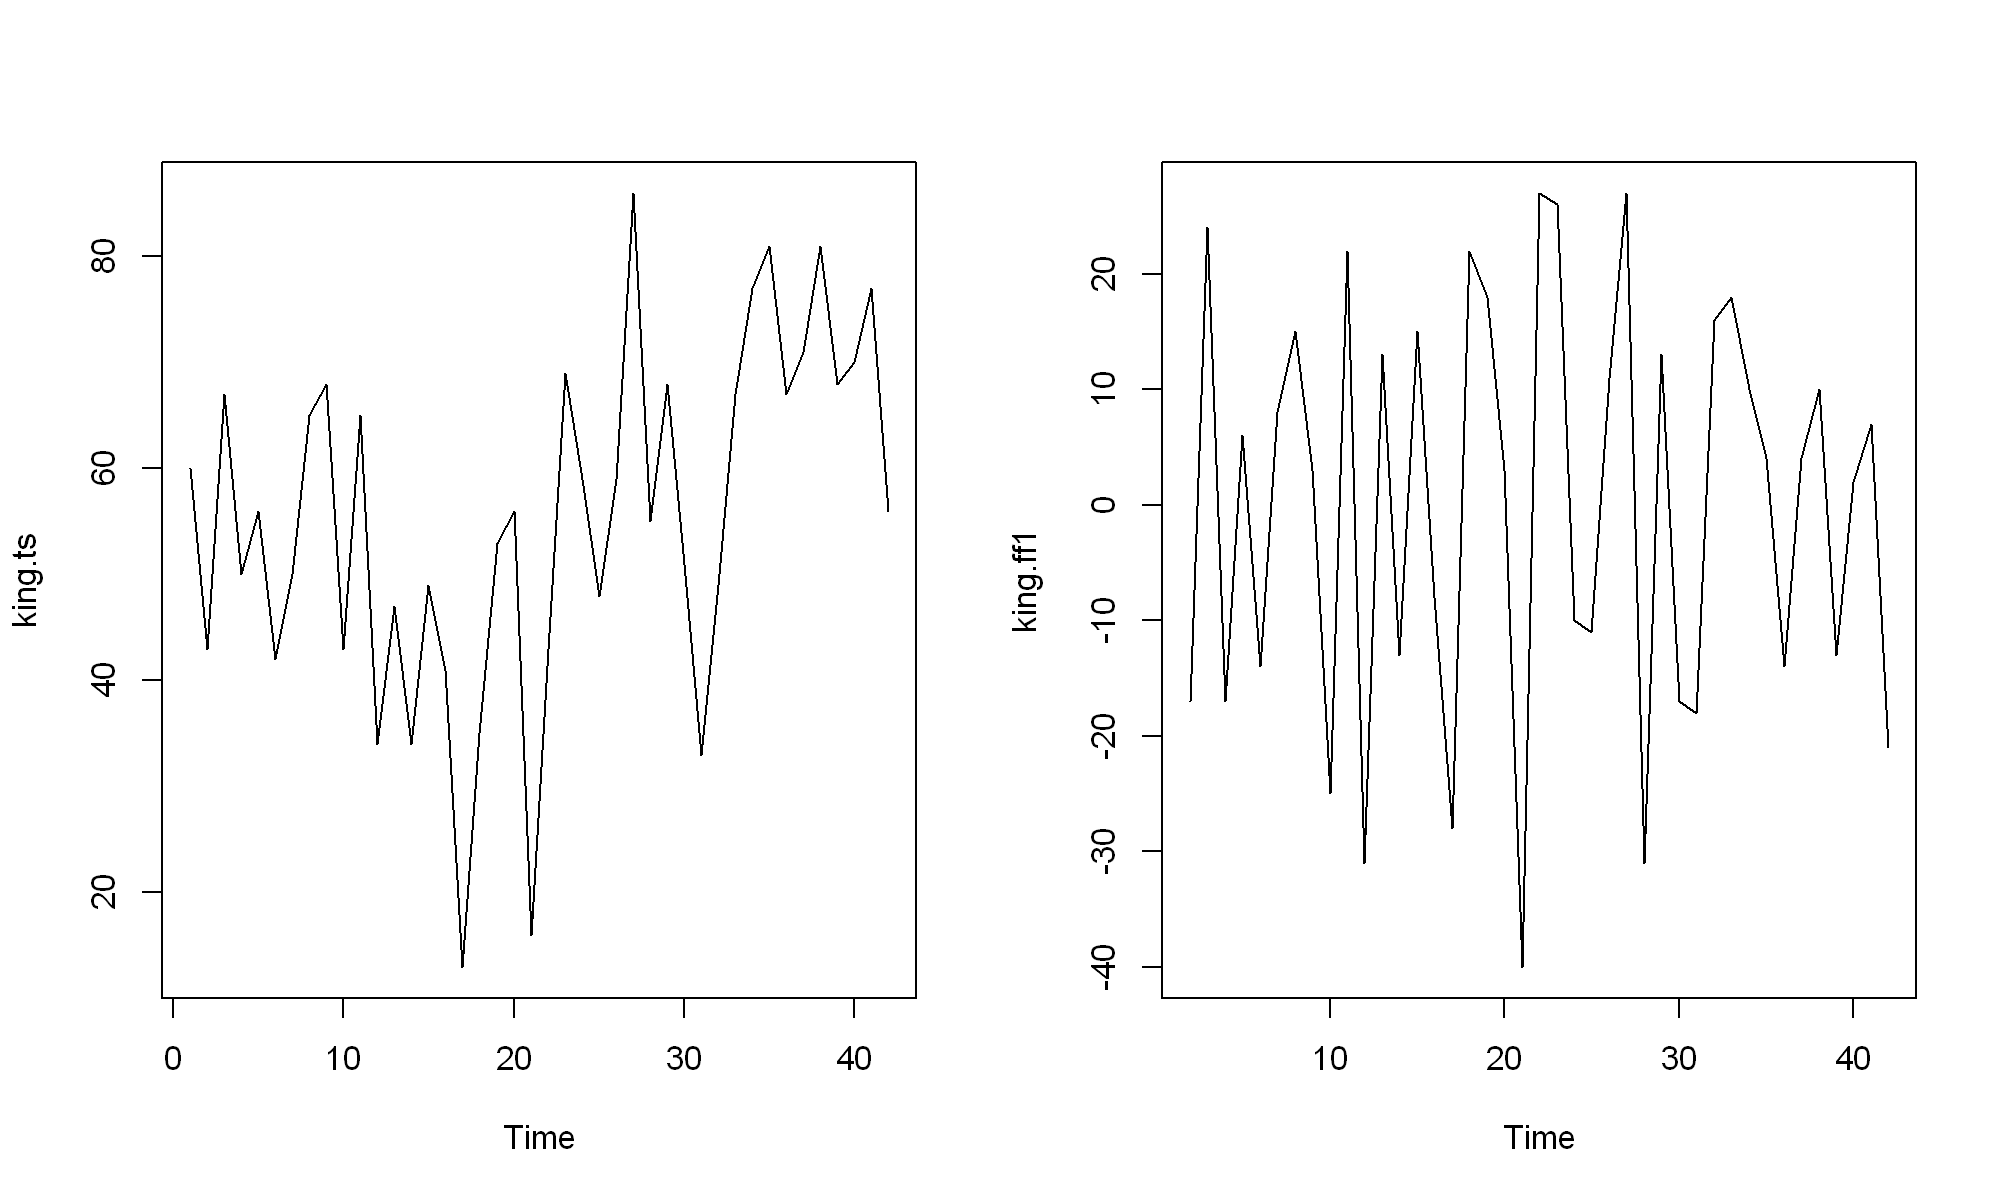

In [17]:
par(mfrow=c(1,2))
king.ff1 <- diff(king.ts,differences=1)
plot.ts(king.ts);plot.ts(king.ff1)

* 시도표를 그려보았을 때는 기존보다 평균과 분산이 어느 정도 일정해짐을 볼 수 있었다.

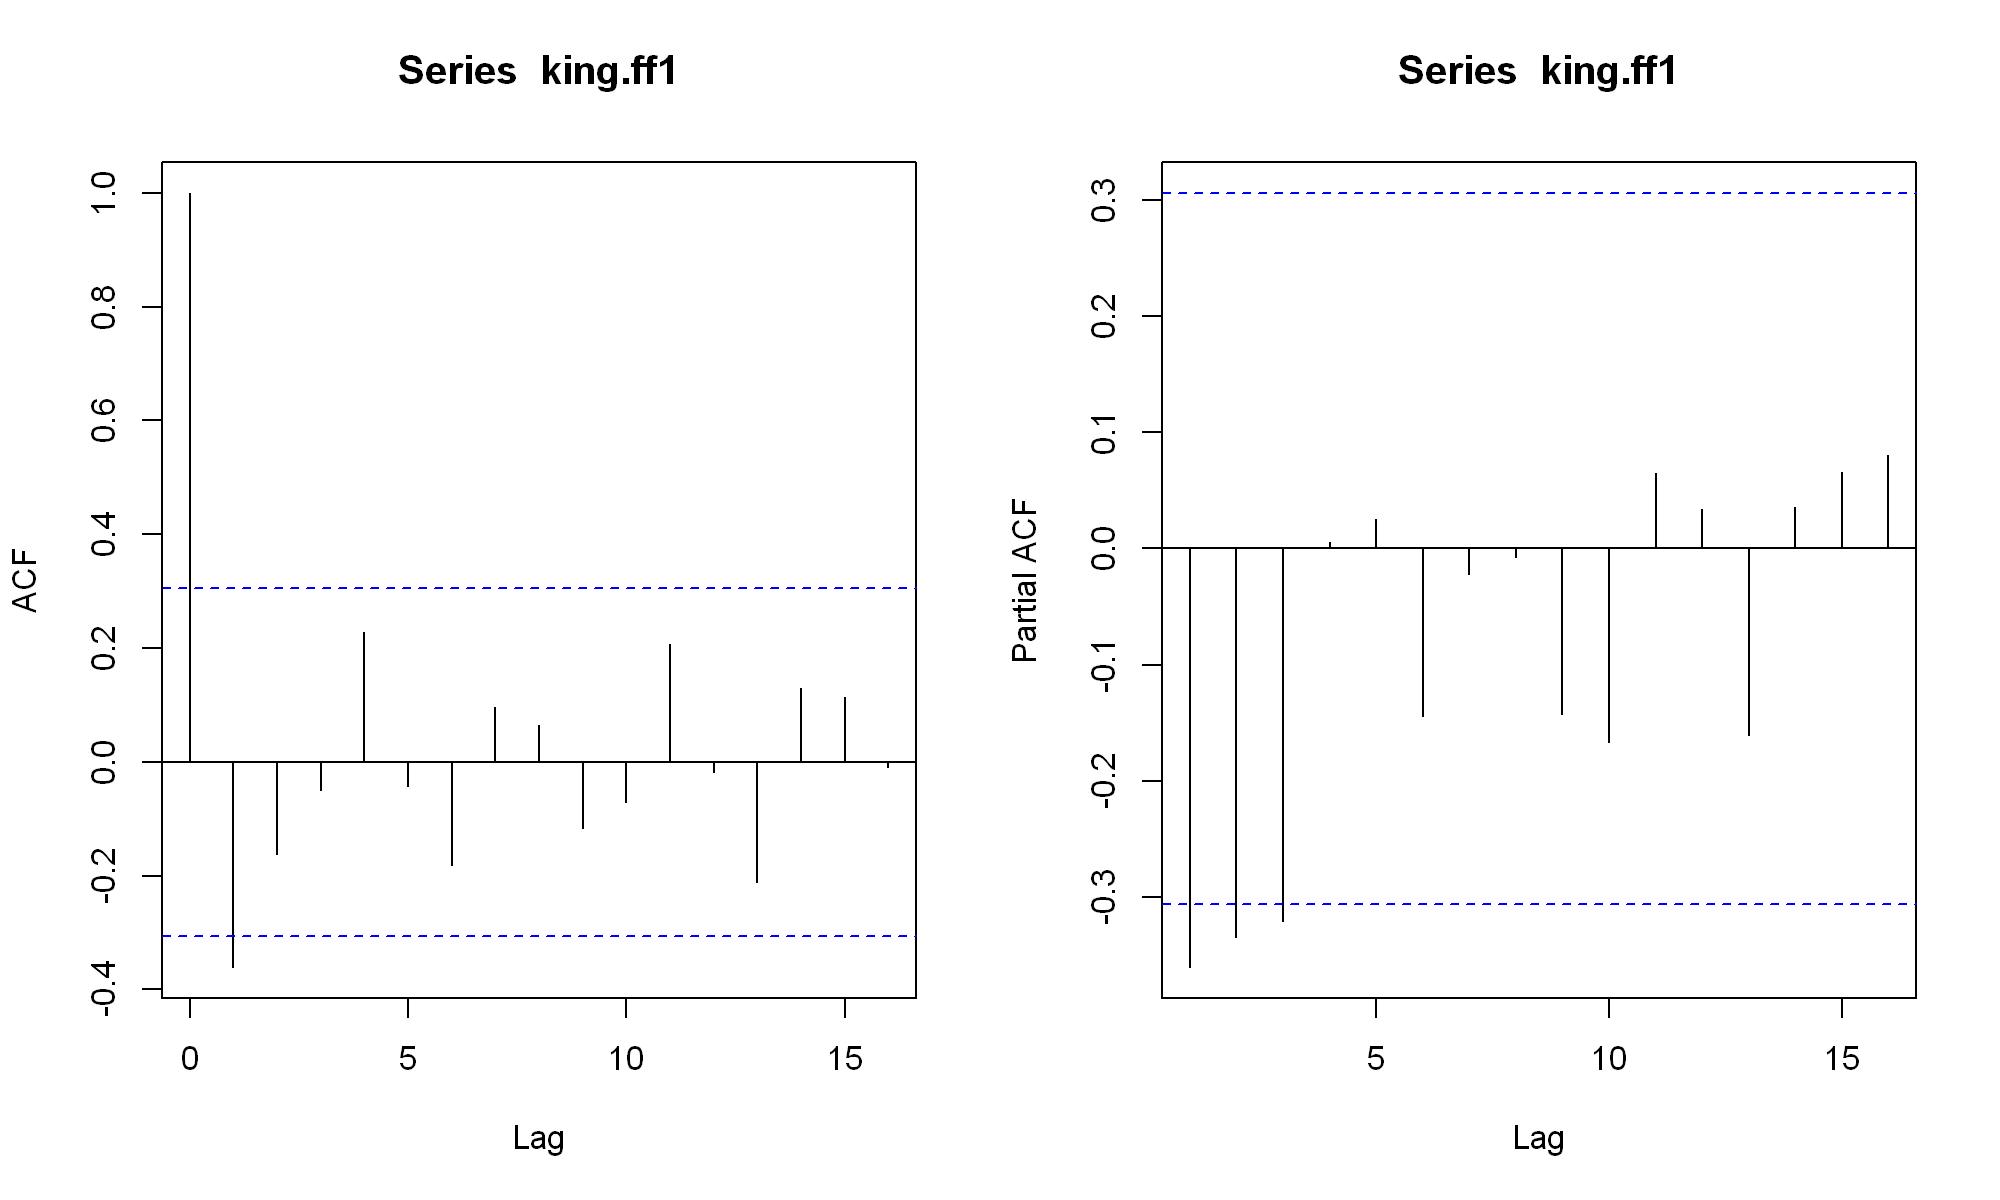

In [18]:
par(mfrow=c(1,2))
acf(king.ff1); pacf(king.ff1)

* acf 그래프를 본 결과 lag 2부터 절단점을 가진다. $\to MA(1)$
* pacf 그래프를 살펴본 결과 lag 4부터 절단점을 가진다. $\to AR(3)$

* 모형의 해석력을 고려하여 $MA(1)$을 선택하는 것이 좋겠지만, auto.arima함수를 이용하여 적절한 모형을 선택

In [19]:
library(forecast)

In [20]:
auto.arima(king) ##기존 데이터를 넣어 주어야함

Series: king 
ARIMA(0,1,1) 

Coefficients:
          ma1
      -0.7218
s.e.   0.1208

sigma^2 estimated as 236.2:  log likelihood=-170.06
AIC=344.13   AICc=344.44   BIC=347.56

* 함수를 이용하여 산출된 모형은 $ARIMA(0,1,1)$이다.

$$ Z_t = \varepsilon_t + 0.7218\times \varepsilon_{t-1}$$

* 따라서 $ARIMA(0,1,1)$ 모형을 적합

* 예측값을 살펴본 결과 43~52 번째 왕의 사망예측 나이는 67.75살로 추정된다.

   Point Forecast    Lo 80    Hi 80    Lo 95     Hi 95
43       67.75063 48.29647 87.20479 37.99806  97.50319
44       67.75063 47.55748 87.94377 36.86788  98.63338
45       67.75063 46.84460 88.65665 35.77762  99.72363
46       67.75063 46.15524 89.34601 34.72333 100.77792
47       67.75063 45.48722 90.01404 33.70168 101.79958
48       67.75063 44.83866 90.66260 32.70979 102.79146
49       67.75063 44.20796 91.29330 31.74523 103.75603
50       67.75063 43.59372 91.90753 30.80583 104.69543
51       67.75063 42.99472 92.50653 29.88974 105.61152
52       67.75063 42.40988 93.09138 28.99529 106.50596

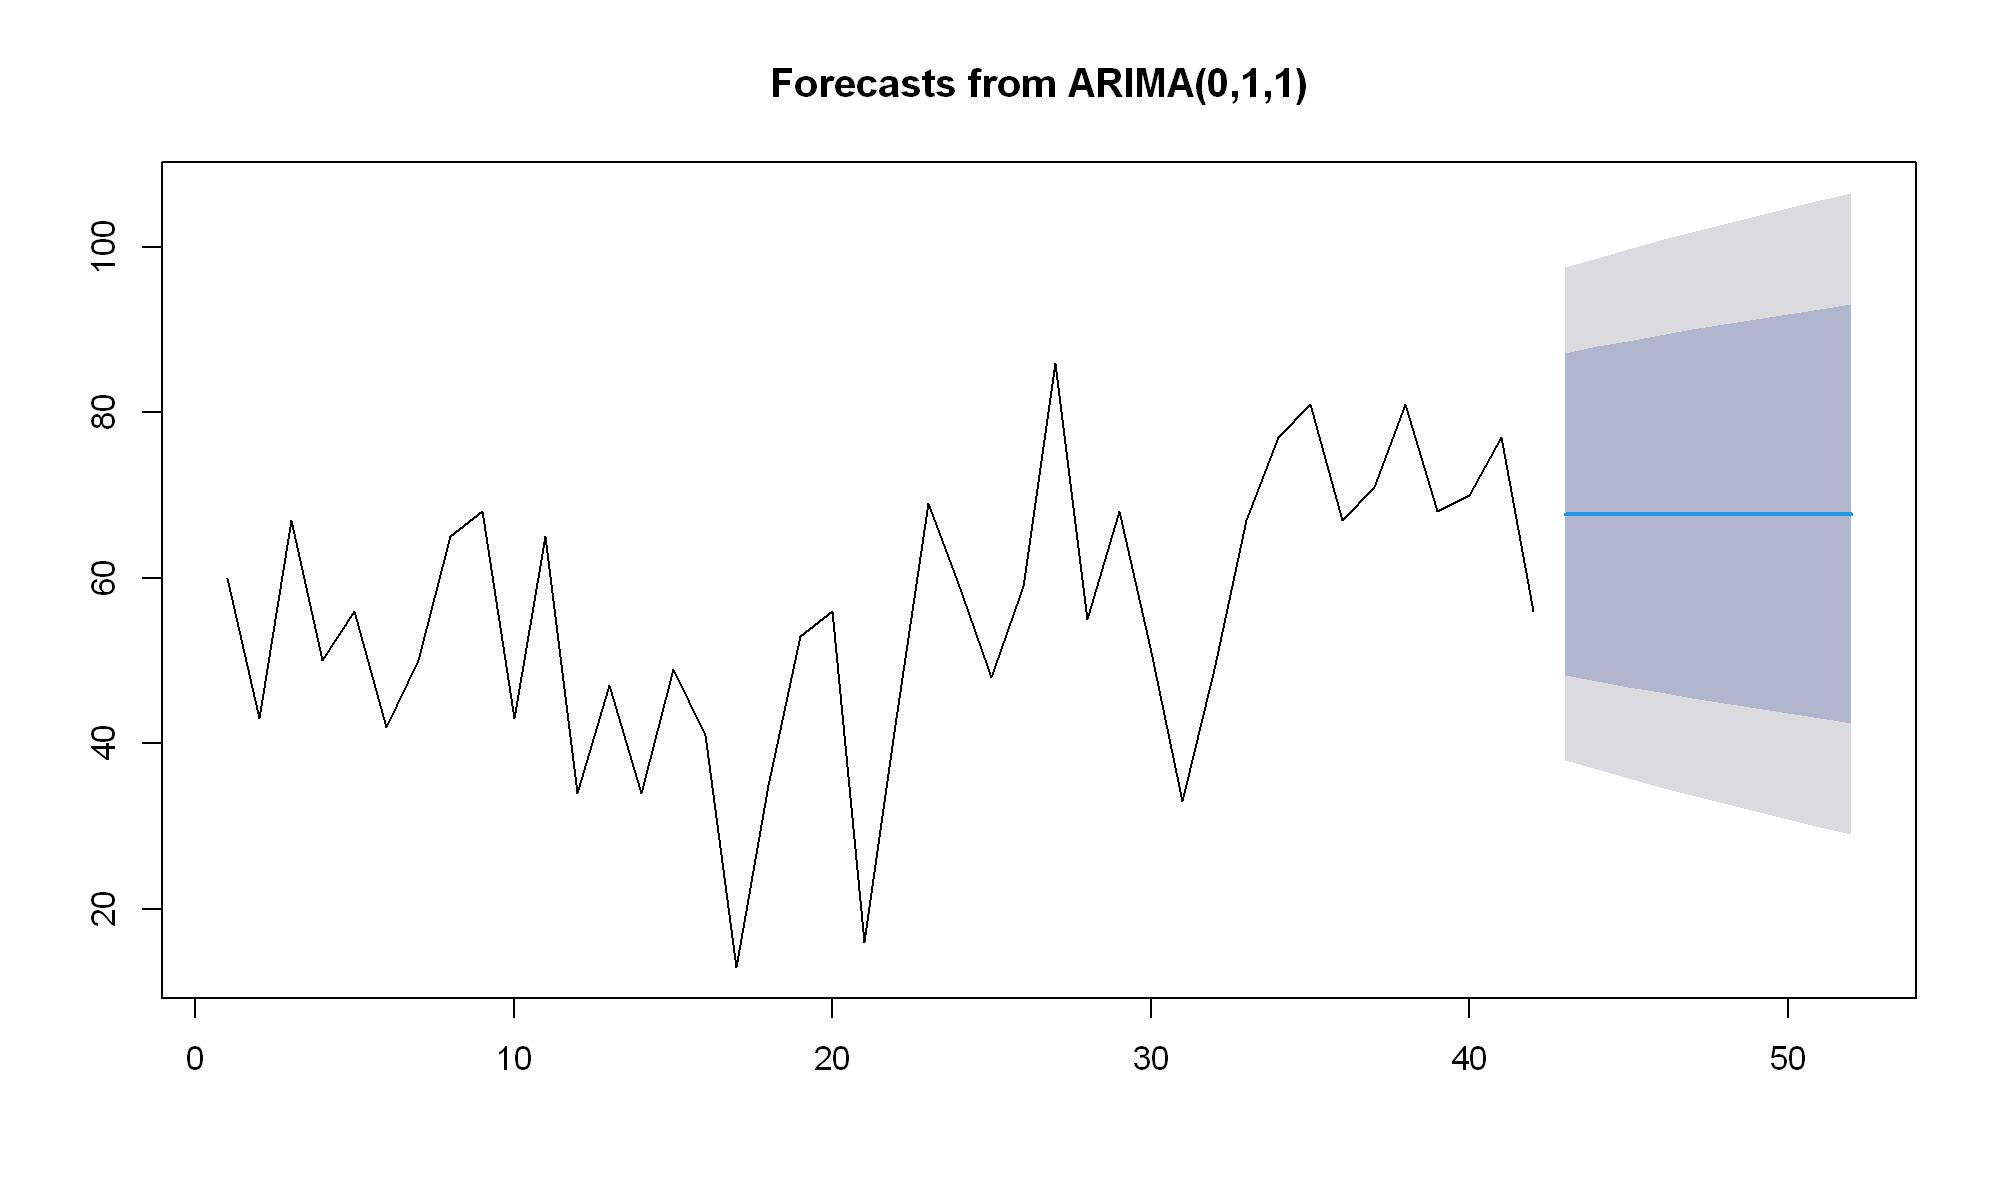

In [21]:
king.arima <- arima(king,order = c(0,1,1))
king.forecasts <- forecast(king.arima)
king.forecasts
plot(king.forecasts)